___

#### DS7333 Quantifying the World: Case Study 1
#### Rick Fontenot, Feby Thomas Cheruvathoor
___


Your case study is to build a linear regression model using L1 or L2 regularization (or both) the task to predict the Critical Temperature as closely as possible. In addition, include in your write-up which variable carries the most importance.

The approach for this Notebook will cover the following topics: 

1) EDA: check missing values, impute as needed, visualizations and summary statistics, outliers, multicollinearity
2) Cross Validation: split off validation set to compare overfitting on unseen data, use 10-fold CV with remaining data to tune models
3) Set up framework for residual checks on regression models
4) Linear Regression, L1, L2 models: compare error metrics and feature importance
5) Run tuned models on validation set and compare metrics to evaluate overfitting 
 

<a id="Prologue"></a>
# Preliminary Data Preparation
Cleaning raw data and new feature creation

- Imports
- load data
- Check missing values
- handling missing values
- check for duplicates

In [1]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
pd.set_option("display.max_columns", None, "display.max_rows", None)
import missingno as msno


### Load the raw data

NYC Airbnb data obtained from http://data.insideairbnb.com/united-states/ny/new-york-city/2021-08-04/data/listings.csv.gz

In [2]:
# Load Raw Data
listings=pd.read_csv("https://raw.githubusercontent.com/rickfontenot/airbnb/main/airbnb_nyc_listings.csv?token=ARN5NNHQQO5DGH6T72FBV2DBGD342")

listings.head()

id                        listing_url       scrape_id last_scraped  \
0  2595  https://www.airbnb.com/rooms/2595  20210804005827   2021-08-04   
1  3831  https://www.airbnb.com/rooms/3831  20210804005827   2021-08-04   
2  5121  https://www.airbnb.com/rooms/5121  20210804005827   2021-08-04   
3  5136  https://www.airbnb.com/rooms/5136  20210804005827   2021-08-04   
4  5178  https://www.airbnb.com/rooms/5178  20210804005827   2021-08-04   

                                                name  \
0                              Skylit Midtown Castle   
1  Whole flr w/private bdrm, bath & kitchen(pls r...   
2                                    BlissArtsSpace!   
3           Spacious Brooklyn Duplex, Patio + Garden   
4                   Large Furnished Room Near B'way　   

                                         description  \
0  Beautiful, spacious skylit studio in the heart...   
1  Enjoy 500 s.f. top floor in 1899 brownstone, w...   
2  <b>The space</b><br />HELLO EVERYONE AND THANK...   
3  We welcome you to stay in our lovely 2 br dupl...   
4  Please don’t expect the luxury here just a bas...   

                               neighborhood_overview  \
0  Centrally located in the heart of Manhattan ju...   
1  Just the right mix of urban center and local n...   
2                                                NaN   
3                                                NaN   
4    Theater district, many restaurants around here.   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/f0813a11-40b2...     2845   
1  https://a0.muscache.com/pictures/e49999c2-9fd5...     4869   
2  https://a0.muscache.com/pictures/2090980c-b68e...     7356   
3  https://a0.muscache.com/pictures/miso/Hosting-...     7378   
4  https://a0.muscache.com/pictures/12065/f070997...     8967   

                                 host_url    host_name  host_since  \
0  https://www.airbnb.com/users/show/2845     Jennifer  2008-09-09   
1  https://www.airbnb.com/users/show/4869  LisaRoxanne  2008-12-07   
2  https://www.airbnb.com/users/show/7356        Garon  2009-02-03   
3  https://www.airbnb.com/users/show/7378      Rebecca  2009-02-03   
4  https://www.airbnb.com/users/show/8967     Shunichi  2009-03-03   

                       host_location  \
0  New York, New York, United States   
1  New York, New York, United States   
2  New York, New York, United States   
3  Brooklyn, New York, United States   
4  New York, New York, United States   

                                          host_about host_response_time  \
0  A New Yorker since 2000! My passion is creatin...                NaN   
1  Laid-back Native New Yorker (formerly bi-coast...       within a day   
2   I am an artist(painter, filmmaker) and curato...       within a day   
3  Rebecca is an artist/designer, and Henoch is i...       within a day   
4  I used to work for a financial industry but no...     within an hour   

  host_response_rate host_acceptance_rate host_is_superhost  \
0                NaN                  NaN                 f   
1                50%                  88%                 f   
2               100%                  NaN                 f   
3                88%                  33%                 f   
4               100%                 100%                 f   

                                  host_thumbnail_url  \
0  https://a0.muscache.com/im/pictures/user/50fc5...   
1  https://a0.muscache.com/im/users/4869/profile_...   
2  https://a0.muscache.com/im/pictures/user/72a61...   
3  https://a0.muscache.com/im/users/7378/profile_...   
4  https://a0.muscache.com/im/users/8967/profile_...   

                                    host_picture_url  host_neighbourhood  \
0  https://a0.muscache.com/im/pictures/user/50fc5...             Midtown   
1  https://a0.muscache.com/im/users/4869/profile_...        Clinton Hill   
2  https://a0.muscache.com/im/pictures/user/72a61...  Bedford-Stuyvesant   
3  https://a0.musca

In [3]:
# Examin Data types
listings.dtypes


id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
description                                      object
neighborhood_overview                            object
picture_url                                      object
host_id                                           int64
host_url                                         object
host_name                                        object
host_since                                       object
host_location                                    object
host_about                                       object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                             object
host_is_superhost                               

**Boolean Variables**: 

The data comes with (4) variables with "t", "f". Pandas doesn't recognize this as a Boolean Value. What we need to do is replace them with actual boolean values (True/False) that pandas recognizes while preserving NA to be converted to boolean. 
- **host_is_superhost** (target variable)	
- host_has_profile_pic	
- host_identity_verified	
- has_availability	
- instant_bookable

In [4]:
#Create function to convert t/f to boolean, included if statement so it doesn't error if run multiple times
def tf_to_bool(dataframe, variable,name):
    if str(variable.dtypes)!='boolean':
        dataframe["temp_boolean"]=np.nan
        dataframe.temp_boolean = dataframe.temp_boolean.astype('boolean')
        dataframe.temp_boolean = np.where(
            variable == 't', True, np.where(
            variable ==  'f', False, np.nan))
        dataframe.temp_boolean = dataframe.temp_boolean.astype('boolean')
        dataframe = dataframe.drop(name, axis=1)    
        dataframe.rename({'temp_boolean': name}, axis=1, inplace=True)
        return dataframe
    else:
        return dataframe

listings = tf_to_bool(listings,listings.host_is_superhost,'host_is_superhost')
listings = tf_to_bool(listings,listings.host_has_profile_pic,'host_has_profile_pic')
listings = tf_to_bool(listings,listings.host_identity_verified,'host_identity_verified')
listings = tf_to_bool(listings,listings.has_availability,'has_availability')
listings = tf_to_bool(listings,listings.instant_bookable,'instant_bookable')

### Regular Expressions
**Price** : our other target variable, is currently an object data type. We need to convert this to a floating point integer. This requires the use of a regular expression to remove "$" and "," from string and convert to float.

In [5]:
print(listings.price.dtypes) #initial type is object
print(listings.price.loc[[299]]) #original value "$2,500.00"
listings.price = listings.price.replace('[\$,]', '', regex=True).astype(float)
print(listings.price.dtypes) #transformed type is float64
print(listings.price.loc[[299]]) #new value is 2500.0

object
299    $2,500.00
Name: price, dtype: object
float64
299    2500.0
Name: price, dtype: float64


**Percentage signs**
Columns with percentages need "%" removed to convert to numeric:
- host_response_rate
- host_acceptance_rate

In [6]:
print(listings.host_response_rate.dtypes) #initial type is object
print(listings.host_response_rate.loc[[299]]) #original value "100%"
listings.host_response_rate = listings.host_response_rate.replace('%', '', regex=True).astype(float)
listings.host_acceptance_rate = listings.host_acceptance_rate.replace('%', '', regex=True).astype(float)
print(listings.host_response_rate.dtypes) #transformed type is float64
print(listings.host_response_rate.loc[[299]]) #new value is 100.0

object
299    100%
Name: host_response_rate, dtype: object
float64
299    100.0
Name: host_response_rate, dtype: float64


**Date Variables**  need to be converted based on string format before updating the data type. All the date columns are using the same military date format which is a numerical representation of year-month-day seperated by a hyphon. EG 2012-01-01 is January first, two thousand twelve. The same strategy can be applied to each of the following date columns: 
- last_scraped
- host_since
- calendar_last_scraped
- first_review
- last_review

In [7]:
date_vars = ['last_scraped','host_since','calendar_last_scraped','first_review','last_review']
listings[date_vars] =  listings[date_vars].apply(pd.to_datetime, format='%Y-%m-%d', errors ='coerce')


**Text Parsing**  bathrooms_text in its current form is not atomized. Meaning it contains more than more piece of information. It contains the Numeric quantity bathrooms and string values describing if it is shared or private. Create dictionary to parse strings and create two new variables of correct type.<br>
<br />

This work goes beyond the scope of data type and into **Data Quality** and **New Features** If we decide to present this for credit, we will present this work again in those sections.<br>
<br/>
Two new columns are being created from *bathroom_text*: **num_baths** and **bath_type**
- **num_baths** will be a floating point value
- **bath_type** will be a categorical value.

In [8]:
#convert nAn values to 'NA' for parsing, will change back to nAn after splitting
listings['bathrooms_text'] = listings['bathrooms_text'].astype(object).replace(np.nan, 'NA')

#Create translation dictionary since description formats are not consistent
transdict = {'1 bath': '1 private', 
             'NA': 'NA',
             '1.5 baths': '1.5 private',
             '1 shared bath': '1 shared', 
             '1 private bath': '1 private',
             'Shared half-bath': '0.5 shared',
             '2 baths': '2 private',
             '1.5 shared baths': '1.5 shared',
             '3 baths': '3 private',
             'Half-bath': '0.5 private',
             '2.5 baths': '2.5 private', 
             '2 shared baths': '2 shared',
             '0 baths' : '0 private',
             '4 baths':'4 private', 
             '0 shared baths': '0 shared',
             'Private half-bath': '0.5 private',  
             '4.5 baths' :'4.5 private', 
             '5.5 baths': '5.5 private' , 
             '2.5 shared baths': '2.5 shared',
             '3.5 baths': '3.5 private', 
             '15.5 baths': '15.5 private', 
             '5 baths': '5 private', 
             '3 shared baths': '3 shared', 
             '4 shared baths': '4 shared',
             '6 baths': '6 private', 
             '3.5 shared baths': '3.5 private', 
             '6 shared baths' : '6 shared',
             '6.5 shared baths': '6.5 shared', 
             '4.5 shared baths' :'4.5 private',
             '5.5 shared baths' : '5.5 private', 
             '7.5 baths': '7.5 private', 
             '5 shared baths': '5 shared',
             '6.5 baths': '6.5 private', 
             '8 baths': '8 private', 
             '7 shared baths':'7 shared', 
             '7 baths': '7 private', 
             '10 baths': '10 private'}

#use trandict to iterate over bathrooms_text column
listings['bathrooms_text'] = [transdict[letter] for letter in listings['bathrooms_text']]

#use str.split to create two new columns 'num_baths' and 'bath_type'
listings[['num_baths','bath_type']] = listings['bathrooms_text'].str.split(' ', 1, expand = True)

#For num_baths convert 'NA' values back to nan and convert type to float
listings['num_baths'] = listings['num_baths'].astype(object).replace( 'NA',np.nan)
listings['num_baths'] = listings['num_baths'].astype(np.float16)

#For bath type convert 'NA' values back to nan and convert type to category
listings.bath_type.fillna(value=np.nan, inplace=True)
listings['bath_type'] = listings['bath_type'].astype('category')
 


### Dropping bathroom_text 
num_baths and bath_type now represent the data that was contained in bathroom_text

In [9]:
#Confirm conversions for bathroom text
print(listings.num_baths.dtypes) #transformed type is float16
print(listings.num_baths.unique())
print(listings.bath_type.dtypes) #transformed type is category
print(listings.bath_type.unique()) 

#Drop original bathrooms_text column now that replaced by two new variables
listings.drop('bathrooms_text', axis=1, inplace=True)

float16
[ 1.   nan  1.5  0.5  2.   3.   2.5  0.   4.   4.5  5.5  3.5 15.5  5.
  6.   6.5  7.5  8.   7.  10. ]
category
['private', NaN, 'shared']
Categories (2, object): ['private', 'shared']


### Check Work
Check current data types for all variables before converting to desired types

In [10]:
print(listings.dtypes)

id                                                       int64
listing_url                                             object
scrape_id                                                int64
last_scraped                                    datetime64[ns]
name                                                    object
description                                             object
neighborhood_overview                                   object
picture_url                                             object
host_id                                                  int64
host_url                                                object
host_name                                               object
host_since                                      datetime64[ns]
host_location                                           object
host_about                                              object
host_response_time                                      object
host_response_rate                                     

### Data Type Dictionary
In this step we are coercing the pandas to recognize the columns in the data type that best represents each particular type of observation.<br>
<br />
To do so Data Type dictionary is created and convert all variables to proper format and bit sizes based on the key value pair.

In [11]:
convert_dict = {'id': 'Int16',
'scrape_id': 'Int64',
'last_scraped': 'datetime64[ns]',
'host_id': 'Int16',
'host_name': str,
'host_since': 'datetime64[ns]',
'calendar_last_scraped': 'datetime64[ns]',
'host_response_time': 'category',
'host_response_rate': 'float64',
'host_acceptance_rate': 'float64',
'host_is_superhost': bool,
'host_neighbourhood': 'category',
'host_listings_count': 'Int16',
'host_total_listings_count': 'Int16',
'host_verifications': str,
'host_has_profile_pic': bool,
'host_identity_verified': bool,
'neighbourhood': str,
'neighbourhood_cleansed': 'category',
'neighbourhood_group_cleansed': 'category',
'property_type': 'category',
'room_type': 'category',
'accommodates': 'Int16',
'bedrooms': 'Int16',
'beds': 'Int16',
'amenities': str,
'price': 'float64',
'minimum_nights': 'Int16',
'maximum_nights': 'Int16',
'minimum_minimum_nights': 'Int16',
'maximum_minimum_nights': 'Int16',
'minimum_maximum_nights': 'Int16',
'maximum_maximum_nights': 'Int16',
'minimum_nights_avg_ntm': 'Int16',
'maximum_nights_avg_ntm': 'Int16',
'has_availability': bool,
'availability_30': 'Int16',
'availability_60': 'Int16',
'availability_90': 'Int16',
'availability_365': 'Int16',
'number_of_reviews': 'Int16',
'number_of_reviews_ltm': 'Int16',
'number_of_reviews_l30d': 'Int16',
'first_review': 'datetime64[ns]',
'last_review': 'datetime64[ns]',
'review_scores_rating': 'float64',
'review_scores_accuracy': 'float64',
'review_scores_cleanliness': 'float64',
'review_scores_checkin': 'float64',
'review_scores_communication': 'float64',
'review_scores_location': 'float64',
'review_scores_value': 'float64',
'instant_bookable': bool,
'calculated_host_listings_count': 'Int16',
'calculated_host_listings_count_entire_homes': 'Int16',
'calculated_host_listings_count_private_rooms': 'Int16',
'calculated_host_listings_count_shared_rooms': 'Int16',
'reviews_per_month': 'float64',
'num_baths': 'float64',
'bath_type': 'category'
               }
  
listings = listings.astype(convert_dict, errors='ignore')
print(listings.dtypes)

id                                                       int64
listing_url                                             object
scrape_id                                                Int64
last_scraped                                    datetime64[ns]
name                                                    object
description                                             object
neighborhood_overview                                   object
picture_url                                             object
host_id                                                  int64
host_url                                                object
host_name                                               object
host_since                                      datetime64[ns]
host_location                                           object
host_about                                              object
host_response_time                                    category
host_response_rate                                     

### Removing columns we cannot interpret 
There's a lot of information for each listing. We only want to keep the most relevant data. The data set did not come with a definition of terms. Some columns we are not able to work out what they represent. Thus we will remove these columns and not present them in the Data Meaning and Type. 


- minimum_minimum_nights                             
- maximum_minimum_nights                             
- minimum_maximum_nights                             
- maximum_maximum_nights                             
- minimum_nights_avg_ntm                             
- maximum_nights_avg_ntm   
- calculated_host_listings_count_entire_homes
- calculated_host_listings_count_private_rooms
- calculated_host_listings_count_shared_rooms

In [12]:
listings.drop(['minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights',
               'maximum_maximum_nights' ,'minimum_nights_avg_ntm','maximum_nights_avg_ntm',
               'calculated_host_listings_count_shared_rooms', 'calculated_host_listings_count_entire_homes',
               'calculated_host_listings_count_private_rooms'], axis=1, inplace = True)

### Removing columns we don't intend to work with
There's a lot of information for each listing. We only want to keep the most relevant data. There are columns we do not intend to use in our analysis 
- listing_url
- scrape_id
- name
- picture_url
- host_url
- host_thumbnail_url
- host_picture_url

In [13]:
listings.drop(['listing_url','scrape_id','picture_url','host_url','host_thumbnail_url',
               'host_total_listings_count','host_picture_url','calendar_last_scraped'], axis=1, inplace = True)

### Check missing values
This check is done to ensure we've preserved the data integrity and its missing values.

In [14]:
listings.isna().sum()

id                                    0
last_scraped                          0
name                                 13
description                        1236
neighborhood_overview             14133
host_id                               0
host_name                             0
host_since                           23
host_location                       119
host_about                        15032
host_response_time                15676
host_response_rate                15676
host_acceptance_rate              15186
host_neighbourhood                 6871
host_listings_count                  23
host_verifications                    0
neighbourhood                         0
neighbourhood_cleansed                0
neighbourhood_group_cleansed          0
latitude                              0
longitude                             0
property_type                         0
room_type                             0
accommodates                          0
bathrooms                         36724


### Function to convert null values in neighbourhood to np.nan data type
Although the neighbourhood variable showed 0 NA in the isna() summary tables we noticed through viewing the data that many were missing. After iterating through 10 tests against the strange na type upon import, we wrote a custom function to replace them with proper np.nan so that it would show up in the missing value reports and could be imputed.


In [15]:
# Missing values for neighbourhood not recognized by .isna, replace them with np.nan for further analysis.
def f(row):
    if str(row['neighbourhood']) == 'nan':
        val = np.nan
    else:
        val = row['neighbourhood']
    return val

listings['neighbourhood'] = listings.apply(f, axis=1)

# Then run .isna summary again
listings.isna().sum()


id                                    0
last_scraped                          0
name                                 13
description                        1236
neighborhood_overview             14133
host_id                               0
host_name                             0
host_since                           23
host_location                       119
host_about                        15032
host_response_time                15676
host_response_rate                15676
host_acceptance_rate              15186
host_neighbourhood                 6871
host_listings_count                  23
host_verifications                    0
neighbourhood                     14132
neighbourhood_cleansed                0
neighbourhood_group_cleansed          0
latitude                              0
longitude                             0
property_type                         0
room_type                             0
accommodates                          0
bathrooms                         36724


## Preserving variables with missing values

For variables with  less than 1,000 missing values (less than 2.7% of observations), we chose not to impute. It may be the case that the lack of data is data in and of itself. Guests may be influenced by the lack of data when choosing a listing. During our analyses we will consider this. In certain cases we may filter. <br><br /> Those variables are:
* name
* host_since
* host_location
* host_thumbnail_url
* host_picture_url
* host_listings_count
* host_total_listings_count
* host_is_superhost
* host_has_profile_pic
* host_identity_verified
* has_availability
* instant_bookable
* num_baths (new variable)
* bath_type (new variable)

### Drop columns with 100% missing values (i.e. blank variables)

Easy decision to remove columns with no information. Getting rid of here so we don't have to discuss this in our data meaning and type write up. Didn't think you'd mind this step taking place here. 

In [16]:
listings.drop(['bathrooms','calendar_updated','license'], axis=1, inplace = True)

### Handling missing values in "Object" (string) data type 
Airbnb allows hosts to give detailed written descriptions. In some observations these text fields are blank. As mentioned before lack of data can be data in and of itself. Thus we don't want to disgard these observations. So we made a decision to give descriptions that are blank a string of "Missing".
For missing values in object and category data type variables, we didn't find correlations to other missing values or correlations to other missing values to impute. In ordered to perserve the rows we replaced missing values with "missing".

In [17]:
# Replace missing values in object data type variables.

listings.description.fillna("missing", inplace=True)
listings.neighborhood_overview.fillna("missing", inplace=True)
listings.host_about.fillna("missing", inplace=True)

### Handling missing values in "Category" data type

Similar to the text fields information can be missing. But we'd like to presrve the row. Thus for missing values in a category data type we used the following function. 

In [18]:
# Replace missing values in category data type variables.

# Function to impute null value with new category
def impute_nan_create_category(listings,ColName):
     listings[ColName] = np.where(listings[ColName].isnull(),"missing",listings[ColName])

## Call function to create new category for variables
for Columns in ['host_response_time', 'host_neighbourhood', 'neighbourhood']:
    impute_nan_create_category(listings,Columns)

### Handing missing values in "Numerical" data type
For missing value in numerical data type variables, since we could not find any correlations between the particular variables with others, we replaced all of the missing value with its mean, except for bedrooms that we replaced with it median because we want to keep its data type as integer.  For reviews_per_month, we know it is calculated from number_of_reviews/(last_scraped - first_review), so we looked at those 3 variables values, and replace the missing values with the result from the calculation.

In [19]:
# Replace missing values in numerical variables with its mean.
listings.host_response_rate.fillna(listings.host_response_rate.mean(), inplace=True)
listings.host_acceptance_rate.fillna(listings.host_acceptance_rate.mean(), inplace=True)
listings.review_scores_rating.fillna(listings.review_scores_rating.mean(), inplace=True)
listings.review_scores_accuracy.fillna(listings.review_scores_accuracy.mean(), inplace=True)
listings.review_scores_checkin.fillna(listings.review_scores_checkin.mean(), inplace=True)
listings.review_scores_cleanliness.fillna(listings.review_scores_cleanliness.mean(), inplace=True)
listings.review_scores_communication.fillna(listings.review_scores_communication.mean(), inplace=True)
listings.review_scores_location.fillna(listings.review_scores_location.mean(), inplace=True)
listings.review_scores_value.fillna(listings.review_scores_value.mean(), inplace=True)

# Replace missing values in numerical variables with its median.
listings.bedrooms.fillna(listings.bedrooms.median(), inplace=True)

### Handling missing values in Ratios
The ratio calculated by review per month will produce and error when a listing does not have a reivew yet. 


In [20]:
# Replace missing value in reviews_per_month based on value in last_scraped, first_review, and number_of_reviews.

# Check for the three columns mentioned value for null reviews_per_month
review_pMonth_vs_numReview = listings[listings['reviews_per_month'].isnull()]
review_pMonth_vs_numReview = review_pMonth_vs_numReview[['last_scraped', 'first_review', 'number_of_reviews', 'reviews_per_month']]

# All missing values in reviews_per_month has 0 number_of_reviews
review_pMonth_vs_numReview.number_of_reviews.unique()

# Replace missing value in reviews_per_month with zero
listings.reviews_per_month = listings.reviews_per_month.fillna(0)

### Datetime variable missing values
For datetime data type variables, we decided to replace missing values with current date. This is a placeholder for potential future reviews. One of the new features we'll create is reviews_duration (last_review - first_review) and this method of imputation will result in 0 for reviews_duration on these missing values

In [21]:
listings.first_review = listings.first_review.fillna(date.today())
listings.last_review = listings.last_review.fillna(date.today())

In [22]:
listings.isna().sum()


id                                  0
last_scraped                        0
name                               13
description                         0
neighborhood_overview               0
host_id                             0
host_name                           0
host_since                         23
host_location                     119
host_about                          0
host_response_time                  0
host_response_rate                  0
host_acceptance_rate                0
host_neighbourhood                  0
host_listings_count                23
host_verifications                  0
neighbourhood                       0
neighbourhood_cleansed              0
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bedrooms                            0
beds                              594
amenities   

## Check for Duplicate Data

In [23]:
# Check for duplicate rows
print('Duplicate rows: ',listings.duplicated(subset=listings.columns.difference(['id'])
, keep='first').sum())


Duplicate rows:  0


This function checks for duplicate records within the data frame. None were found. We removed the ID column to prevent the primary key from deceiving the function. In the sections above we already removed columns that were near duplicates. Such as;


- minimum_minimum_nights                             
- maximum_minimum_nights                             
- minimum_maximum_nights                             
- maximum_maximum_nights                             
- minimum_nights_avg_ntm                             
- maximum_nights_avg_ntm   
- calculated_host_listings_count_entire_homes
- calculated_host_listings_count_private_rooms
- calculated_host_listings_count_shared_rooms

## New Feature: Reviews Duration

Create this from the time difference of last review minus first review. This may be a more accurate representation of how long someone has been an active host than the original host_since variable provided in the dataset which appears to be based on sign up date, not activity.

In [24]:
listings['reviews_duration'] = listings.last_review - listings.first_review
# Format is timedelta, extract the numer of days like this:
listings.reviews_duration = listings.reviews_duration.astype('timedelta64[D]')

## New Feature: Price per accomodation

In [25]:
listings['price_per_accomodation'] = listings.price / listings.accommodates
listings.price_per_accomodation.replace([np.inf, -np.inf], np.nan, inplace=True)

## New Features: room_privacy & domicile_type

**property_type** has two bits of information nested in it. It lets the guest know the privacy status of a listings and domicile type e.g., house, condo, villa, hotel etc. To atomize this information we will use the same strategy as bathroom text to parce out the information. 

In [26]:
#create dictionary of terms
prop_type_transdict = {'Entire rental unit' : 'entire rental-unit',
'Entire guest suite' : 'entire guest-suite', 
'Private room in rental unit' : 'private-room rental-unit',
'Private room in townhouse' : 'private-room townhouse',
'Private room in condominium (condo)': 'private-room condo', 
'Private room in loft': 'private-room loft', 
'Entire loft': 'entire loft',
'Private room in residential home': 'private-room home',
'Entire condominium (condo)': 'entire condo',
'Entire residential home': 'entire home',
'Entire townhouse': 'entire townhouse',
'Private room in bed and breakfast': 'private-room bnb',
'Entire guesthouse': 'entire guesthouse', 
'Private room in guest suite': 'private-room guest-suite',
'Bus': 'entire Bus',
'Room in boutique hotel': 'private-room boutique-hotel',
'Shared room in loft': 'shared-room loft',
'Shared room in rental unit':'shared-room rental-unit', 
'Shared room in residential home': 'shared-room home', 
'Private room': 'private-room room', 
'Private room in hostel':'private-room hostel',
'Entire place': 'entire place',
'Private room in guesthouse': 'private-room guesthouse',
'Boat': 'entire boat',
'Entire serviced apartment': 'entire serviced-apartment',
'Room in aparthotel': 'private-room aparthotel',
'Shared room in earth house': 'shared-room earth-house',
'Floor': 'entire floor',
'Shared room in hostel': 'shared-room hostel', 
'Room in serviced apartment': 'private-room serviced-apartment',
'Entire cottage': 'entire cottage',
'Shared room in condominium (condo)': 'shared-room condo',
'Private room in serviced apartment': 'private-room serviced-apartment',
'Room in hotel': 'private-room hotel',
'Private room in boat': 'private-room boat',
'Cave': 'entire cave', 
'Tiny house': 'entire tiny-house',
'Private room in floor': 'private-room floor',
'Entire bungalow': 'entire bungalow',
'Shared room in townhouse': 'shared-room townhouse',
'Houseboat': 'entire houseboat',
'Private room in bungalow': 'private-room bungalow',
'Entire villa': 'entire villa',
'Private room in resort': 'private-room resort',
'Shared room in guest suite': 'shared-room guest-suite',
'Private room in castle': 'private-room castle',
'Private room in villa': 'private-room villa',
'Shared room in floor':'shared-room floor',
'Shared room in serviced apartment':'shared-room serviced-apartment',
'Entire bed and breakfast': 'entire bnb',
'Entire home/apt': 'entire home',
'Private room in tiny house':'private-room tiny-house', 
'Private room in tent':'private-room tent',
'Private room in in-law': 'private-room in-law',
'Private room in barn': 'private-room barn',
'Camper/RV': 'entire rv',
'Room in resort':'private-room resort',
'Shared room in bed and breakfast': 'shared-room bnb',
'Private room in farm stay': 'private-room farm',
'Private room in casa particular': 'private-room home',
'Private room in dorm': 'private-room dorm',
'Room in bed and breakfast':'private-room bnb',
'Private room in camper/rv': 'private-room rv',
'Shared room in island': 'shared-room island',
'Shared room in bungalow': 'shared-room bungalow',
'Private room in earth house': 'private-room earth-house',
'Private room in cottage': 'private-room cottage',
'Lighthouse': 'entire lighthouse', 
'Private room in train': 'private-room train',
'Barn': 'entire barn',
'Private room in lighthouse': 'private-room lighthouse',
'Castle': 'entire castle',
'Tent': 'entire tent',
'Tower': 'entire tower',
'Casa particular': 'entire home'}

#use prop_type_trandict to iterate over bathrooms_text column
listings['property_type'] = [prop_type_transdict[letter] for letter in listings['property_type']]

#use str.split to create two new columns 'room_privacy' and 'domicile_type'
listings[['room_privacy','domicile_type']] = listings['property_type'].str.split(expand=True)

#convert new columns to category data type
listings['room_privacy'] = listings['room_privacy'].astype('category')
listings['domicile_type'] = listings['domicile_type'].astype('category')

### Results of property_type atomization

(3) levels of privacy extracted. 
1. Entire
    denoting guests will have the domicile to themselves.
2. private-room 
    guests will have a room to themselves but shared access to common areas with other guests or hosts
3. shared-room
    guests will possibly share a room with other guests or hosts and shared access to common areas. <br><br />

(38) different categories of domicile 
- casa particular I reduced to home (spanish for private residence)
- private room in law i left as room in law. Refers to in law suite. This is your own space on a property but is on the same property as another domicile.
- bed and breakfast is bnb
- Floor i left as floor. I could grasp the meaning of that either
- Villa remains villa since I think that describes a particular domicile that differs from home
- rental unit could be merged into apartment but it could also mean a home so i left as is. 
- serviced-apartment is probably something unique and deserves its own class outside of apartment
- townhouse remains townhouse since I think that describes a particualr domicile that differs from home. 
- aparthotel remains due to lack of understanding 

<AxesSubplot:xlabel='count', ylabel='domicile_type'>

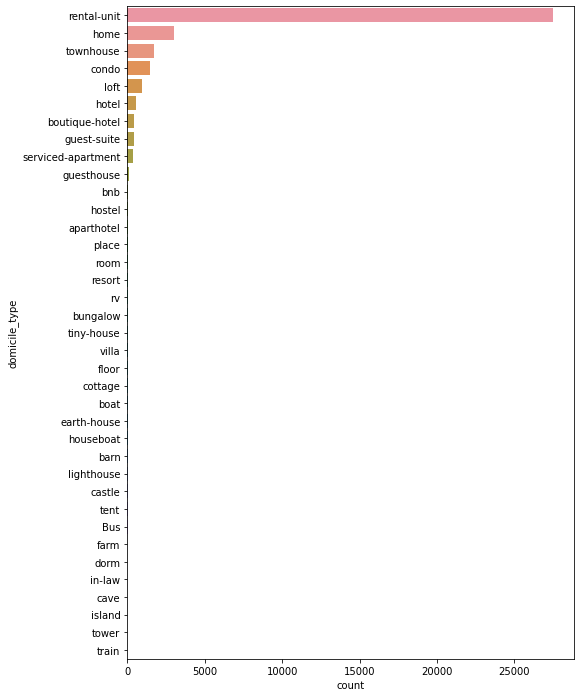

In [27]:
plt.figure(figsize = (8,12))
sns.countplot(y="domicile_type", data=listings, order = listings['domicile_type'].value_counts().index, orient='h')


### Key Observations:

Top Five domiciles types:
- Rental-Unit
- Home
- Townhouse
- Condo
- Loft

It appears many people are listing units that they might not own but, have certain rights to list on Airbnb. This makes sense for NYC many people rent apartments, instead of owning homes. To make money on the side they might stay with family or friends and list the unit.

<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

___
<a id="dataClass"></a>
# Data Preparation Part 1: *Classification of Superhost Status*
___
#### [15 points total] 

><a id="defineClass"></a> 
> ##  Define and Prepare Your Class Variables 
> 
Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. 

> #### [10 points]

<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

In [28]:
#Check remaining missing values and drop records
listings.isna().sum()

id                                  0
last_scraped                        0
name                               13
description                         0
neighborhood_overview               0
host_id                             0
host_name                           0
host_since                         23
host_location                     119
host_about                          0
host_response_time                  0
host_response_rate                  0
host_acceptance_rate                0
host_neighbourhood                  0
host_listings_count                23
host_verifications                  0
neighbourhood                       0
neighbourhood_cleansed              0
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bedrooms                            0
beds                              594
amenities   

Relatively small amount of missing values remaining after imputing in sections above. After dropping records with missing values we have 34460 records and 58 features with superhost as the target

In [29]:
listings = listings.dropna()
listings.shape


(35953, 59)

Examining Remaining columns, we will keep 'id' as an identifier and remove the following columns that are identifiers, repeate info contained in other columns, or not applicable to classification models due to too many unique values:

last_scraped
name
description
neighborhood_overview
host_id
host_name
host_since
host_location
host_about
host_verifications
neighbourhood
room_type
amenities
number_of_reviews_ltm
number_of_reviews_l30d
first_review
last_review
calculated_host_listings_count

In [30]:
listings.head()

id last_scraped                                               name  \
0  2595   2021-08-04                              Skylit Midtown Castle   
1  3831   2021-08-04  Whole flr w/private bdrm, bath & kitchen(pls r...   
3  5136   2021-08-04           Spacious Brooklyn Duplex, Patio + Garden   
4  5178   2021-08-04                   Large Furnished Room Near B'way　   
5  5203   2021-08-04                 Cozy Clean Guest Room - Family Apt   

                                         description  \
0  Beautiful, spacious skylit studio in the heart...   
1  Enjoy 500 s.f. top floor in 1899 brownstone, w...   
3  We welcome you to stay in our lovely 2 br dupl...   
4  Please don’t expect the luxury here just a bas...   
5  Our best guests are seeking a safe, clean, spa...   

                               neighborhood_overview  host_id    host_name  \
0  Centrally located in the heart of Manhattan ju...     2845     Jennifer   
1  Just the right mix of urban center and local n...     4869  LisaRoxanne   
3                                            missing     7378      Rebecca   
4    Theater district, many restaurants around here.     8967     Shunichi   
5  Our neighborhood is full of restaurants and ca...     7490    MaryEllen   

  host_since                      host_location  \
0 2008-09-09  New York, New York, United States   
1 2008-12-07  New York, New York, United States   
3 2009-02-03  Brooklyn, New York, United States   
4 2009-03-03  New York, New York, United States   
5 2009-02-05  New York, New York, United States   

                                          host_about host_response_time  \
0  A New Yorker since 2000! My passion is creatin...            missing   
1  Laid-back Native New Yorker (formerly bi-coast...       within a day   
3  Rebecca is an artist/designer, and Henoch is i...       within a day   
4  I used to work for a financial industry but no...     within an hour   
5  Welcome to family life with my oldest two away...            missing   

   host_response_rate  host_acceptance_rate host_neighbourhood  \
0           86.330958             75.619603            Midtown   
1           50.000000             88.000000       Clinton Hill   
3           88.000000             33.000000  Greenwood Heights   
4          100.000000            100.000000     Hell's Kitchen   
5           86.330958             75.619603    Upper West Side   

   host_listings_count                                 host_verifications  \
0                    6  ['email', 'phone', 'reviews', 'offline_governm...   
1                    1  ['email', 'phone', 'reviews', 'offline_governm...   
3                    1                      ['email', 'phone', 'reviews']   
4                    1          ['email', 'phone', 'facebook', 'reviews']   
5                    1  ['email', 'phone', 'facebook', 'google', 'revi...   

                       neighbourhood neighbourhood_cleansed  \
0            New York, United States                Midtown   
1  Brooklyn, New York, United States     Bedford-Stuyvesant   
3                            missing            Sunset Park   
4            New York, United States                Midtown   
5            New York, United States        Upper West Side   

  neighbourhood_group_cleansed  latitude  longitude             property_type  \
0                    Manhattan  40.75356  -73.98559        entire rental-unit   
1                     Brooklyn  40.68494  -73.95765        entire guest-suite   
3                     Brooklyn  40.66265  -73.99454        entire rental-unit   
4                    Manhattan  40.76457  -73.98317  private-room rental-unit   
5                    Manhattan  40.80380  -73.96751  private-room rental-unit   

         room_type  accommodates  bedrooms  beds  \
0  Entire home/apt             1         1     1   
1  Entire home/apt             3         1     3   
3  Entire home/apt             4         2     2   
4     Private room             2         1     1   
5   

<a id="hostdata"></a>
### Make Host Centric Data from listings data 

In MiniLab we found aggregating the data by host_id produced better results. 

In [31]:
temp = listings

rating_avg = temp.groupby('host_id')['review_scores_rating'].mean()
rating_avg= rating_avg.to_frame().rename(columns={'review_scores_rating':'rating_avg'}).reset_index()

rating_max = temp.groupby('host_id')['review_scores_rating'].max()
rating_max= rating_max.to_frame().rename(columns={'review_scores_rating':'rating_max'}).reset_index()

reviews_total = temp.groupby('host_id')['number_of_reviews'].sum()
reviews_total= reviews_total.to_frame().rename(columns={'number_of_reviews':'reviews_total'}).reset_index()

host_response_time_max = temp.groupby('host_id')['host_response_time'].max()
host_response_time_max= host_response_time_max.to_frame().rename(columns={'host_response_time':'response_time_max'}).reset_index()

host_response_rate_median = temp.groupby('host_id')['host_response_rate'].median()
host_response_rate_median= host_response_rate_median.to_frame().rename(columns={'host_response_rate':'response_rate_median'}).reset_index()

acceptance_rate_median = temp.groupby('host_id')['host_acceptance_rate'].median()
acceptance_rate_median= acceptance_rate_median.to_frame().rename(columns={'host_acceptance_rate':'acceptance_rate_median'}).reset_index()

total_nyc_listings = temp.groupby('host_id')['calculated_host_listings_count'].median()
total_nyc_listings= total_nyc_listings.to_frame().rename(columns={'calculated_host_listings_count':'total_nyc_listings'}).reset_index()

accommodates_median = temp.groupby('host_id')['accommodates'].median()
accommodates_median= accommodates_median.to_frame().rename(columns={'accommodates':'accommodates_median'}).reset_index()

price_median = temp.groupby('host_id')['price'].median()
price_median= price_median.to_frame().rename(columns={'price':'price_median'}).reset_index()

availability_60_median = temp.groupby('host_id')['availability_60'].median()
availability_60_median= availability_60_median.to_frame().rename(columns={'availability_60':'availability_60_median'}).reset_index()

reviews_duration_median = temp.groupby('host_id')['reviews_duration'].median()
reviews_duration_median= reviews_duration_median.to_frame().rename(columns={'reviews_duration':'reviews_duration_median'}).reset_index()

superhost_max = temp.groupby('host_id')['host_is_superhost'].max()
superhost_max= superhost_max.to_frame().rename(columns={'host_is_superhost':'superhost_max'}).reset_index()

data_frames = [rating_avg, rating_max, reviews_total, host_response_time_max, host_response_rate_median, acceptance_rate_median, 
total_nyc_listings, accommodates_median, price_median, availability_60_median, reviews_duration_median, superhost_max]

from functools import reduce
host_df = reduce(lambda  left,right: pd.merge(left,right,on=['host_id'], how='outer'), data_frames)

host_df.head(10)

host_id  rating_avg  rating_max  reviews_total response_time_max  \
0     2420    4.574993    4.574993              0    within an hour   
1     2438    0.000000    0.000000              1           missing   
2     2571    4.910000    4.910000             34    within an hour   
3     2782    4.574993    4.574993              0      within a day   
4     2787    4.721874    5.000000            147    within an hour   
5     2845    4.758331    5.000000             50           missing   
6     2868    4.000000    4.000000              2      within a day   
7     2881    4.830000    4.880000            578    within an hour   
8     3757    4.574993    4.574993              0      within a day   
9     4396    4.555000    4.650000            138      within a day   

   response_rate_median  acceptance_rate_median  total_nyc_listings  \
0            100.000000               89.000000                 1.0   
1             86.330958               75.619603                 1.0   
2            100.000000               29.000000                 1.0   
3             80.000000               44.000000                 1.0   
4            100.000000               94.000000                 8.0   
5             86.330958               75.619603                 3.0   
6             67.000000                0.000000                 1.0   
7            100.000000               98.000000                 2.0   
8             50.000000               33.000000                 1.0   
9             96.000000               59.000000                 2.0   

   accommodates_median  price_median  availability_60_median  \
0                  5.0         802.0                    21.0   
1                  4.0          95.0                     0.0   
2                  4.0         139.0                     6.0   
3                  4.0          95.0                     0.0   
4                  2.0         149.0                    60.0   
5                  1.0         150.0                    36.0   
6                  2.0          60.0                    26.0   
7                  2.0          50.0                     6.5   
8                  2.0         350.0                     3.0   
9                  1.5          99.0                    13.0   

   reviews_duration_median  superhost_max  
0                      0.0           True  
1                      0.0          False  
2                   1579.0           True  
3                      0.0          False  
4                    343.0          False  
5                    622.0          False  
6                   -225.0          False  
7                   1910.0           True  
8                      0.0          False  
9                   1266.5          False

### Convert Response Time (Categorical) to Ordinal for modeling
Code as integer with 0 representing the quickest response time to 3 representing the longest response time, and 4 for missing values

In [32]:
host_df['response_time'] = np.where((host_df['response_time_max'] == 'within an hour'), 0, 
(np.where(host_df['response_time_max'] == 'within a few hours', 1, 
(np.where(host_df['response_time_max'] == 'within a day', 2, 
(np.where(host_df['response_time_max'] == 'a few days or more', 3, 4)))))))

host_df.head()

host_id  rating_avg  rating_max  reviews_total response_time_max  \
0     2420    4.574993    4.574993              0    within an hour   
1     2438    0.000000    0.000000              1           missing   
2     2571    4.910000    4.910000             34    within an hour   
3     2782    4.574993    4.574993              0      within a day   
4     2787    4.721874    5.000000            147    within an hour   

   response_rate_median  acceptance_rate_median  total_nyc_listings  \
0            100.000000               89.000000                 1.0   
1             86.330958               75.619603                 1.0   
2            100.000000               29.000000                 1.0   
3             80.000000               44.000000                 1.0   
4            100.000000               94.000000                 8.0   

   accommodates_median  price_median  availability_60_median  \
0                  5.0         802.0                    21.0   
1                  4.0          95.0                     0.0   
2                  4.0         139.0                     6.0   
3                  4.0          95.0                     0.0   
4                  2.0         149.0                    60.0   

   reviews_duration_median  superhost_max  response_time  
0                      0.0           True              0  
1                      0.0          False              4  
2                   1579.0           True              0  
3                      0.0          False              2  
4                    343.0          False              0

In [33]:
# Drop categorical version of response time
host_df = host_df.drop('response_time_max',axis=1)



### Examine correlation matrix on host level data: 

<AxesSubplot:>

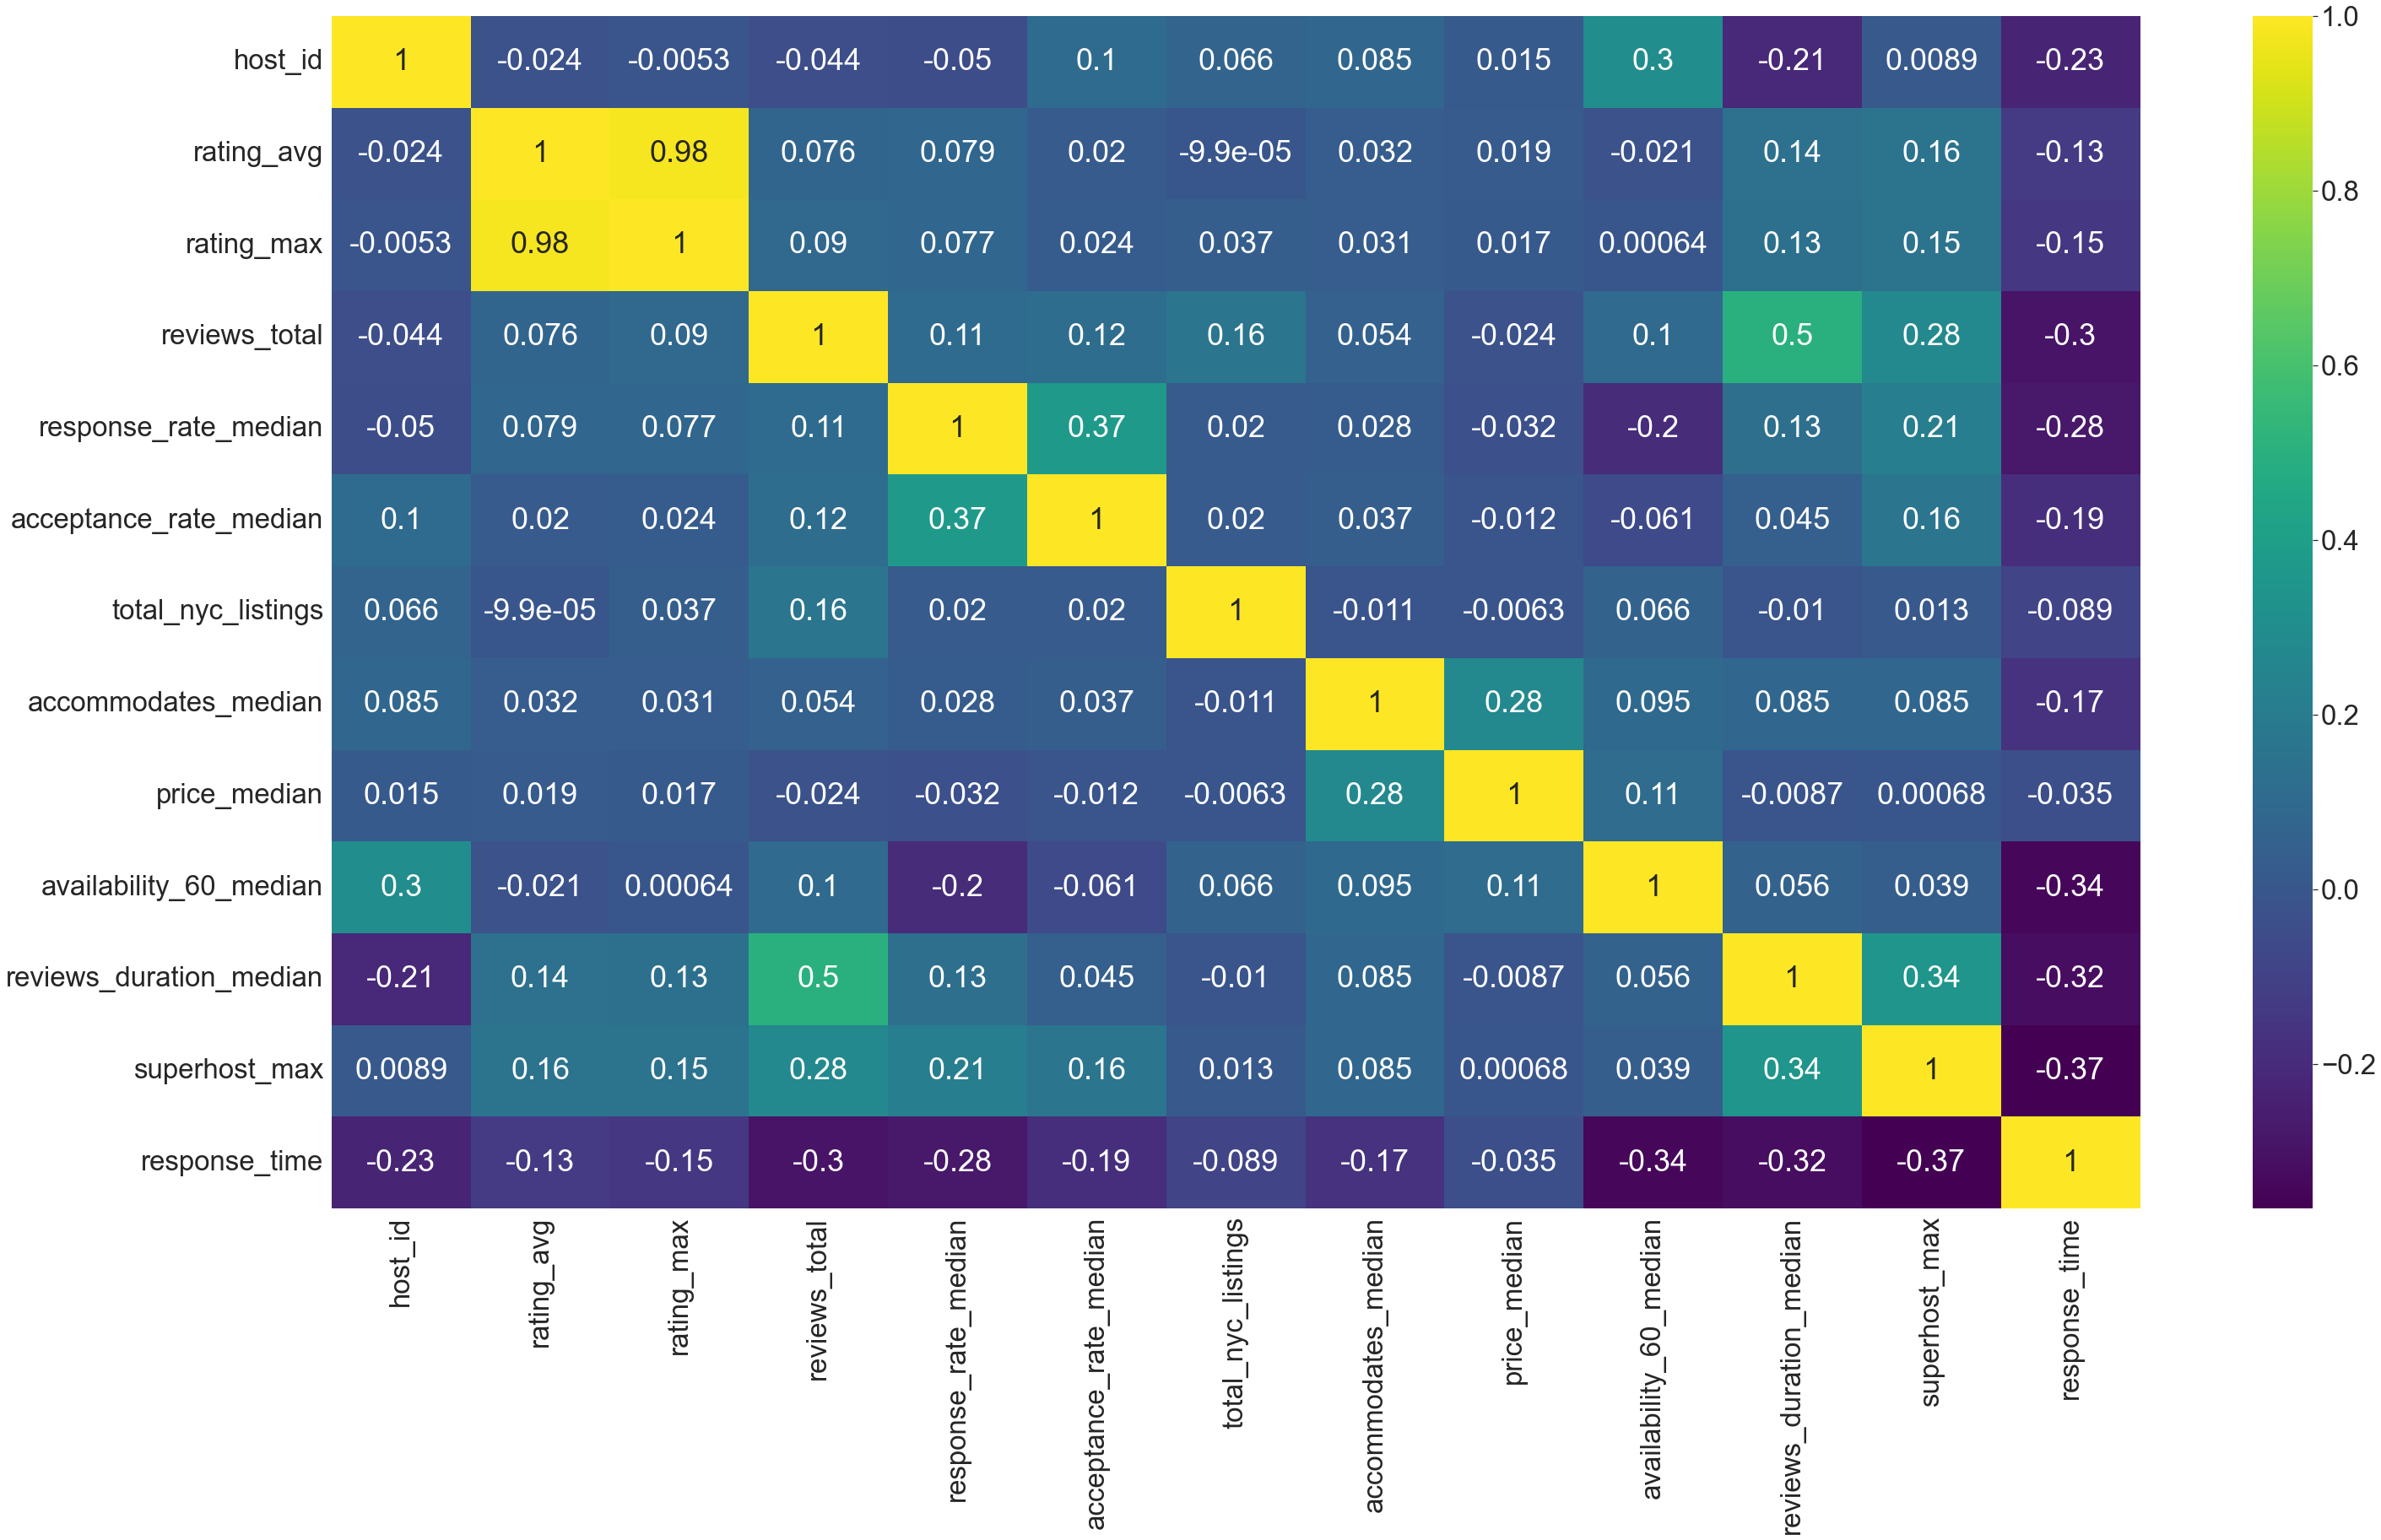

In [34]:
plt.figure(figsize=(48,26))
sns.set(font_scale=3)
sns.heatmap(host_df.corr(),annot=True,cmap='viridis')

**rating_max** and **rating_avg** are very highly correlated. 
>We will drop **rating_max**

In [35]:
host_df.drop('rating_max', axis=1, inplace=True)

<a id="describeClass"></a> 
> ## Data Preparation Part 2:
Describe The Final Dataset: *Classification*
>
(include a description of any newly formed variables you created).

> #### [5 points]

In [36]:
host_df.shape

(25230, 12)

### Shape of final dataset
The final dataset that we will model with has 24,397 unqiue observations. with 15 columns that we will describe below. 

### Final Dataset Columns

* host_id - Host ID is a four-digit number that serves as a primary key for a host. Hosts are those who have rights to a certain property through ownership, leases or granted managerial authority. There is no limit to the number of properties they can list on Airbnb. Guests and Hosts have the abilitly to read one another’s profiles. Guests might be influenced by a Hosts reviews or status as a super host. Data type of int64. <br>
<br />
* rating_avg - The average score for all listings grouped by host_id from review_scores_rating. Guests who have stayed at a listing may rate the listing on a scale from 0-5. This score is averaged across all the hosts listings within NYC. 
* reviews_total - The total number of reviews a host has recieved. This number is aggregated across all listings associated with a host_id. <br>
<br />
* response_rate_median - This column takes the median value for a hosts reponse time across all their listings within NYC grouped by host id. The original column is a precentage of how often a host replies to an inquirty sent to them on the Airbnb website. <br>
<br />
* acceptance_rate_median - This column was made from grouping all hosts_acceptance_rate by host id and finidng the median value for each host. The original column, host_accpetance_rate, is continous value from 0-100 and is a percentage of how often a host will accpet a guests request to stay vs reject this request. Hosts can accept or reject a guests request to stay. This could be a factor of scheduling and timing. Or a factor of a guests poor rating. Hosts and guests rate one another after a stay. The cumulative rating servers as a social credit on the website. This can influence a hosts decision to accept a guests request to stay at their place. <br>
<br />
* total_nyc_listings - This column represents the total number of listings a host has available in NYC. By grouping host_calculated_listings by host id. Represented by an integer value. <br>
<br />
* accommodates_median - This column is the median number of a guests a particular host is able to lodge in NYC. values are represented by an integer type. <br>
<br />
* price_median - The is the median price of all the listings in NYC associated with a particular host. Values are represented by an integer type <br>
<br />
* availability_60_median - This is the median number of days a host has made their listings available. Group by host_id the original column is availability_60 The number of nights the listing is available within the next 60 days. The availability could be a factor of bookings. Can also be a factor of the host living in the property, since some properties listed on Airbnb are hosts primary residence.   <br>  
<br />
* reviews_duration_median - <br>

<br />
* <b>superhost_max</b> - Our Target variable. If a host meets requirements for superhost in one of the listings than the host is superhost for all their listings. Boolean value True / False stating whether host meets condition of currently having the the status of “Superhost”. From Airbnb website “Every 3 months, each host is evaluated on their hospitality. Superhosts meet all of the criteria – they’re highly rated, experienced, reliable, and responsive.” They must meet certain criteria of; 4.8+ rating, 10+ stays, 1% cancellation rate, and 90% response rate.  The number one benefit of being a Superhost is that it improves the visibility of your listings. For one, there is a super host only filter. Superhost properties are more likely to be featured in Airbnb newsletters and curated lists on the Airbnb website. Becoming a super host and sporting the superhost badge builds trust and allows guests to stand out from the crowd. Having the superhost badge my allow hosts to increase their rates. From the host tools website, “Guests expect a higher level of service and a better experience from Superhosts, so it’s likely that they’re willing to pay more.” [From Airbnb website: How to become a SuperHost](https://www.airbnb.com/help/article/829/how-do-i-become-a-superhost).<br>
<br />

The following columns are categorical dummy variables columns representing host response time - This column's data type is category that approximates how long it takes for a host to reply to an inquiry. The strings have a ordinal relationship. The fastest to slowest response are denoated as: “within an hour”, “within a few hours”, “within a day”, “a few days or more”. This information is available on the website to prospective guest.
* response_time_max_missing -  This column reflects those hosts who do not have any response time data. Probably emblematic of a new host. <br />
* response_time_max_within a day - Those hosts with the longest response time. A host who will respond within a day <br>
* response_time_max_within a few hours - Host response time generally takes a few hours to respond to inquires <br />
* response_time_max_within an hour -  Those hosts that will respond the fastest, within an hour. <br />

<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>


 <a id="M&EClass"></a>
# Modeling and Evaluation
# *Target 1: Classification of Superhost* 
___

#### [70 points total]

><a id="MetricsClass"></a> 
> ## Modeling & Evaluation 1: Choose and explain your evaluation metrics: *Classification*
> 

i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

> #### [10 points]

The chosen evaluation metric is AUC, given the binary and imbalanced nature of the response variable. AUC is an appropriate metric for analyzing the results of the classification models because it is robust to binary and imbalanced classification problems. 

Due to the superhost target having significant class imbalance (18.5% superhost, 81.5% non-superhost) we would expect relatively high accuracy with even if we predicted all non-superhost. Our primary goal in these models was to determine the key factors that lead to becoming a superhost, not necessarily the classification itself. Because of that there is not a reason to prioritize sensitivity vs. specificity by shifting the probability cutoff to prioritize one class over the other. We chose to use AUC as the model evaluation metric since it will prioritize the most robust model over all possible values of the probability thresholds. 

<a id="SplitClass"></a> 
> ## Modeling & Evaluation 2: Choose the method you will use for dividing your data into training and testing splits: *Classification*
> 

i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate.

> #### [10 points]

### Methodology for dividing our data: Overal Methodology

Our work in Lab 2 includes a classification task and regression task. We applied a similar methodology across both methods. Due to unique constraints of each task some minor adjustments were made. 

The approach we applied to each task:

1) Set a side 10% of the data for validation. Randomization and stratification applied to ensure this set is representative of the data as whole. The validation set serves as an unseen source of data that will give us a good indication of how we might expect to perform in production. 

2) We scaled our independent variables. Scaling the allows each feature to contribute approximately proportionately to the final distance. Scaling allows us to understand rankings of feature importance.

3) Testing was done using 10-fold cross validation. Using a seed to ensure reproducible results. Cross-validation makes use of our limited data in order help estimate performance model against unseen data. In the folds randomization and stratification are techniques are used to ensure a representative sample across all folds. 

4) Apply grid search to in order to tune the parameters of each model to find the best results. 

5) Optimized models are then tested against data it has never seen before using the validation set. This step is performed only once. After running the validation set no adjustments to the model are made. The results of this validation step are then reported.  

6) Note that for vlaidation set stratified shuffle split was preferred over stratified k fold because it allowed us to split one 10% chunk, and since the data was only split once the overlapping behavior of the stratified shuffle split was not of any concern.
<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

# Split train and test datasets
- **host_df** is for classification task (Logistic regression included here)
- **listings** is for regression task

We're required to do:
- two classification tasks OR
- two regression tasks OR
- one classification task and one regression task

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

import time

## **host_df** for classification task

Split the host dataframe to preserve a validation set for comparing models after tuning on CV of initial train/test split. We are using the stratified shuffle split so the validation set is representative of classes, as well as random_state so the if this code is run multiple times we get the same splits for consistentcy

In [38]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_valid_index in split.split(host_df, host_df.superhost_max):
    host_modeling = host_df.iloc[train_index]
    host_validation = host_df.iloc[test_valid_index]

In [39]:
print("Size of modeling set (to be CV split): ",host_modeling.shape)
print("Size of hold back validation set: ",host_validation.shape)

Size of modeling set (to be CV split):  (22707, 12)
Size of hold back validation set:  (2523, 12)


In [40]:
#Create new X predictor matrix
X_host = host_modeling.drop(['superhost_max','host_id'],axis=1).values #droping rating_max
y_host = host_modeling['superhost_max'].values
y_host = y_host.astype(int)

#Scale new predictor matrix
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()
scl_obj.fit(X_host)
X_host = scl_obj.transform(X_host)

In [41]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold


num_cv_iterations = 10 #Change to 10 fold for final optimization (longer compute time)
num_instances = len(y_host)
cv_object = StratifiedKFold(n_splits=num_cv_iterations, shuffle=True, random_state=27)


Create predictor variable matrix (X) and target matrix (y) then

Scale predictor variables, so that coefficient weights can be compared for significance after modeling

In [42]:
#Create new X predictor matrix
X_host_validate = host_validation.drop(['superhost_max','host_id'],axis=1).values #droping rating_max
y_host_validate = host_validation['superhost_max'].values
y_host_validate = y_host_validate.astype(int)

#Scale new predictor matrix
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()
scl_obj.fit(X_host_validate)
X_host_validate = scl_obj.transform(X_host_validate)

> 
> ## Modeling & Evaluation 3: Create three different *Classification* models (e.g., random forest, KNN, and Logistic Regression).
> 

Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization

We will use Logistic Regression, KNN, and Random Forest to make predictions and understand key factors to attain superhost status

> #### [20 points]

<a id="LogRegClass"></a> 
# Logistic Regression: Superhost Classification

### Base Model with 10-fold stratified cross validation

Since our goal was to provide guidance on what the most important factors are to become a superhost, model interpretability is more important than classification. For this reason we chose accuracy as a more important metric than sensitivity or specificity. Using a Logistic Regression with host level data and no class weight gives us the best balance of accuracy (86%), interpretability, and fast run times in the event we add more data or cities in further analysis


Load libraries needed for modeling & create a scoring dictionary for metrics used to compare models

In [43]:
scorer = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0)
}

In [44]:
#lr does not have weights applied
start_time = time.time()
lr = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object

cv_results = sklearn.model_selection.cross_validate(lr, X_host, y_host, cv=cv_object, scoring=scorer) #lr does not have weights applied
print(cv_results)
print("Mean Accuracy = ",cv_results['test_accuracy'].mean())
print("Mean Sensitivity = ",cv_results['test_sensitivity'].mean())
print("Mean Specificity = ",cv_results['test_specificity'].mean())
print("Run Time: ",time.time() - start_time, "seconds")

{'fit_time': array([0.03100634, 0.02989054, 0.02597284, 0.02696967, 0.02497387,
       0.02589631, 0.0259676 , 0.02796698, 0.02597237, 0.02796698]), 'score_time': array([0.00259137, 0.00285053, 0.00230503, 0.00214124, 0.00302649,
       0.00320411, 0.00206065, 0.00287867, 0.00235415, 0.00223875]), 'test_accuracy': array([0.8678996 , 0.86085425, 0.85204756, 0.86129458, 0.86745927,
       0.86217525, 0.86129458, 0.86431718, 0.85550661, 0.86035242]), 'test_sensitivity': array([0.39164491, 0.41775457, 0.34725849, 0.36814621, 0.40469974,
       0.34725849, 0.38802083, 0.4073107 , 0.38903394, 0.38120104]), 'test_specificity': array([0.96451271, 0.95074153, 0.95444915, 0.96133475, 0.96133475,
       0.96663136, 0.95760466, 0.95707472, 0.95018548, 0.95760466])}
Mean Accuracy =  0.8613201310529043
Mean Sensitivity =  0.38423289273281114
Mean Specificity =  0.9581473765640018
Run Time:  0.31009387969970703 seconds


# Tune Hyperparameters with Grid Search on 10-fold cross validation set

Using <a id="LegRegGridSearch"></a> Grid Search to find the best logistic regression classification model.

<a href="#bottom">Back to bottom</a>

In [45]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

parameters = {
                'penalty': ['l1', 'l2', 'elasticnet', 'none'], 
                'C': [1, 10, 20],
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'class_weight': [None, 'balanced'],
             }


clf = LogisticRegression()

import warnings

with warnings.catch_warnings():
   warnings.simplefilter('ignore')
   grid_obj = GridSearchCV(lr, parameters, cv=cv_object, scoring='roc_auc')
   grid_obj = grid_obj.fit(X_host, y_host)

In [46]:
print(grid_obj.best_estimator_.get_params())

print('Model accuracy is',grid_obj.score(X_host, y_host))

{'C': 1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Model accuracy is 0.8703428699157325


Grid Search shows small improvement to accuracy using the "saga" solver 

# Make predictions on hold back validation set to compare metrics to the CV model

[0 0 0 ... 0 0 0]
Validation Set Accuracy:  0.8644470868014269


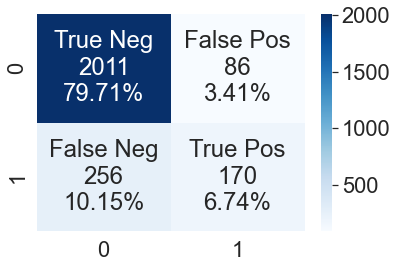

In [48]:
lr = LogisticRegression(penalty='l2', C=10, class_weight=None, solver='liblinear' ) # get object

lr_model_fit = lr.fit(X_host,y_host)
lr_validation_predictions = lr.predict(X_host_validate)

print(lr_validation_predictions)
from sklearn.metrics import accuracy_score
print("Validation Set Accuracy: ", accuracy_score(y_host_validate, lr_validation_predictions))

import seaborn as sns

def plot_confusion(cf_matrix):
    sns.set(font_scale=2)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
    cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
    zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


lr_cm = confusion_matrix(y_host_validate,lr_validation_predictions)
plot_confusion(lr_cm)

# Logistic Regression Feature Importance

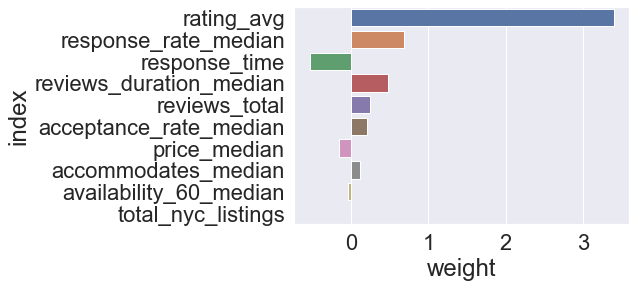

In [49]:
weights = lr_model_fit.coef_.T # take transpose to make a column vector
variable_names = host_validation.drop(['superhost_max','host_id'],axis=1).columns 

coefficients = pd.DataFrame(weights,variable_names)
coefficients = coefficients.rename(columns={coefficients.columns[0]: 'weight'})
coefficients = coefficients.sort_values(by='weight', key=abs, ascending=False)
coefficients.reset_index(level=0, inplace=True)

ax = sns.barplot(y="index", x="weight", data=coefficients)


# Validation set ROC Curve and AUC for Logistic Regression

0.8688569183340387


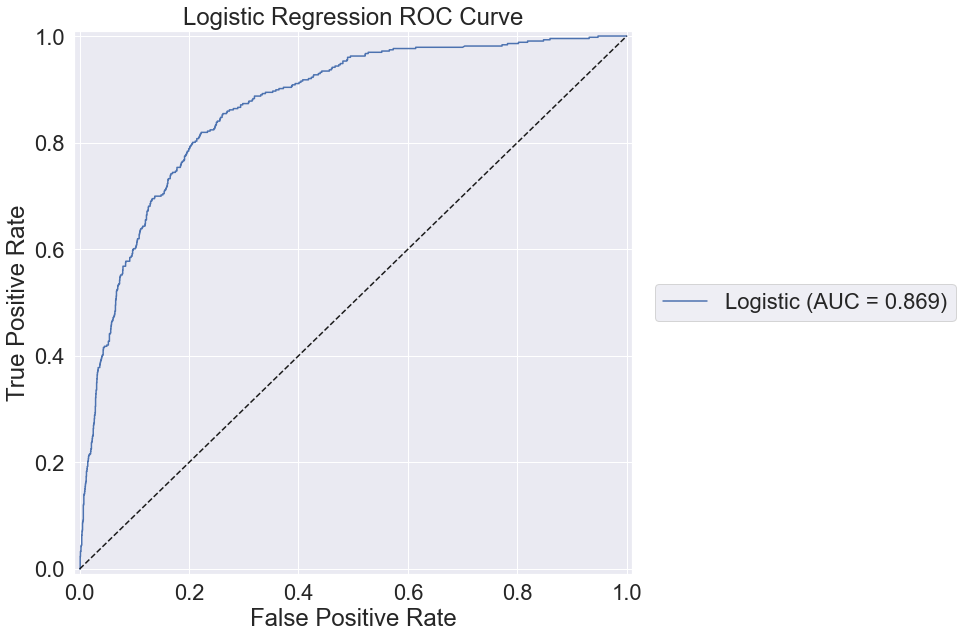

In [50]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Calculate probabilities on predictions (not just classifications) needed for AUC
lr_probabilities = lr.predict_proba(X_host_validate)


lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_host_validate, lr_probabilities[:,1])
lr_auc = roc_auc_score(y_host_validate, lr_probabilities[:,1])

print(lr_auc)

# Plot ROC curve
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(lr_fpr, lr_tpr, label='Logistic (AUC = %0.3f)' % lr_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

<a id="KNNClass"></a>
# KNN: Superhost Classification

### Methodology for dividing our data: Overal Methodology
<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

# Base KNN model using 10-fold stratified cross validation

In [51]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

cv_results = sklearn.model_selection.cross_validate(knn, X_host, y_host, cv=cv_object, scoring=scorer) #lr does not have weights applied

print(cv_results)
print("Mean Accuracy = ",cv_results['test_accuracy'].mean())
print("Mean Sensitivity = ",cv_results['test_sensitivity'].mean())
print("Mean Specificity = ",cv_results['test_specificity'].mean())

{'fit_time': array([0.29923415, 0.26329565, 0.26429296, 0.26728463, 0.26329565,
       0.26628733, 0.25830889, 0.26429248, 0.2613008 , 0.26429296]), 'score_time': array([0.23337579, 0.2353704 , 0.23237872, 0.23038387, 0.22539735,
       0.23437333, 0.22140789, 0.22739196, 0.22639465, 0.23138118]), 'test_accuracy': array([0.8665786 , 0.84456187, 0.83839718, 0.85380889, 0.86085425,
       0.83795685, 0.84896521, 0.84273128, 0.83920705, 0.84933921]), 'test_sensitivity': array([0.51697128, 0.45953003, 0.4386423 , 0.46475196, 0.47519582,
       0.4386423 , 0.47395833, 0.44386423, 0.42819843, 0.45430809]), 'test_specificity': array([0.9375    , 0.92266949, 0.91949153, 0.93273305, 0.93908898,
       0.91896186, 0.92527822, 0.92368839, 0.92262851, 0.92951775])}
Mean Accuracy =  0.8482400386408209
Mean Sensitivity =  0.4594062771975631
Mean Specificity =  0.9271557792837702


# Find range of optimal k with grid search

Using <a id="KnnGridSearch"></a> Grid Search to find the best KNN classification model.

<a href="#bottom">Back to bottom</a>

Best Parameters from search:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 30, 'p': 2, 'weights': 'uniform'}
Best Accuracy:  0.8766249945257005


Text(0, 0.5, 'Cross-Validated Accuracy')

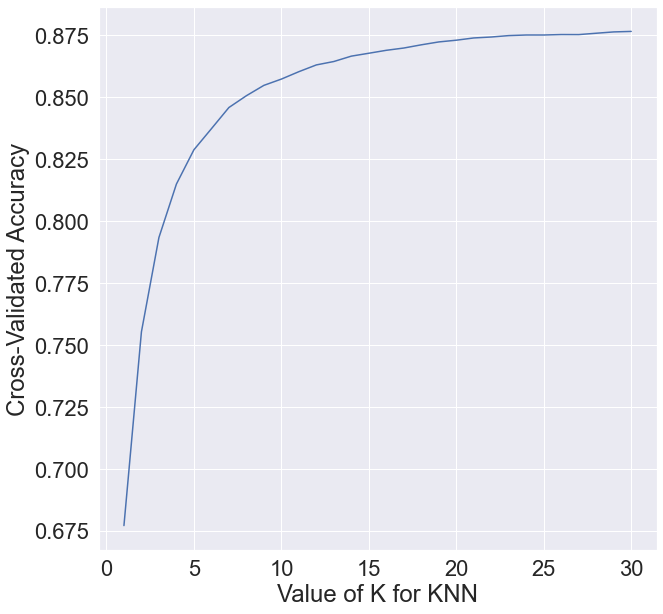

In [52]:
from sklearn.model_selection import GridSearchCV

k_range = list(range(1, 31))

param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(knn, param_grid, cv=cv_object, scoring='roc_auc')
grid.fit(X_host, y_host)

print("Best Parameters from search: ",grid.best_estimator_.get_params())
print("Best Accuracy: ",grid.best_score_)


plt.plot(k_range, grid.cv_results_['mean_test_score'])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

## Now that we know the basic relationship of k and accuracy run a grid search to optimize other parameters with a smaller grid range of k

In [53]:
param_grid2 = {
    'n_neighbors': [10,20,30,40],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
}

grid2 = GridSearchCV(knn, param_grid2, cv=cv_object, scoring='roc_auc')
grid2.fit(X_host, y_host)

print("Best Parameters from search: ",grid2.best_estimator_.get_params())
print("Best Accuracy: ",grid2.best_score_)

Best Parameters from search:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 40, 'p': 2, 'weights': 'distance'}
Best Accuracy:  0.885802954473969


## Now that we know manhattan distance as the metric improves accuracy, do one final grid search for optimal k again

Best Parameters from search:  {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 59, 'p': 2, 'weights': 'distance'}
Best Accuracy:  0.8866599851996672


Text(0, 0.5, 'Cross-Validated Accuracy')

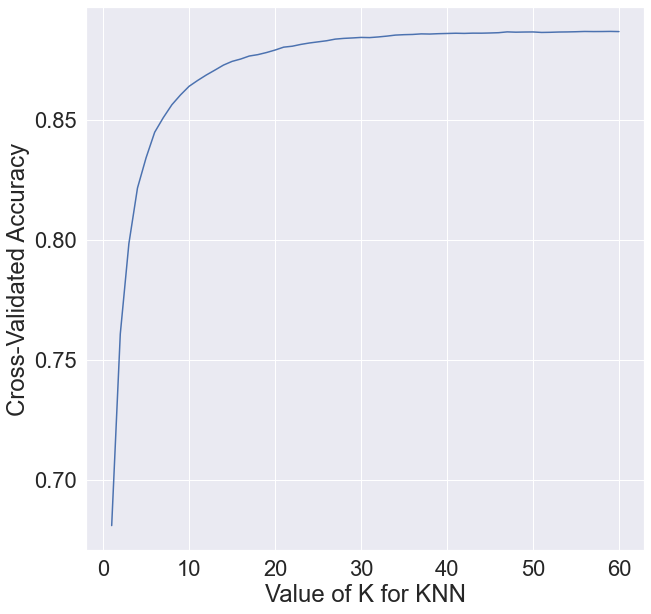

In [54]:
k_range = list(range(1, 61))

param_grid3 = {
    'n_neighbors': k_range,
    'weights': ['distance'],
    'metric': ['manhattan']
}

grid3 = GridSearchCV(knn, param_grid3, cv=cv_object, scoring='roc_auc')
grid3.fit(X_host, y_host)

print("Best Parameters from search: ",grid3.best_estimator_.get_params())
print("Best Accuracy: ",grid3.best_score_)


plt.plot(k_range, grid3.cv_results_['mean_test_score'])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

<a id="optimalK"></a>

# Check performance on validation set after tuning hyperparameters

Validation Set Accuracy:  0.8711850971066191


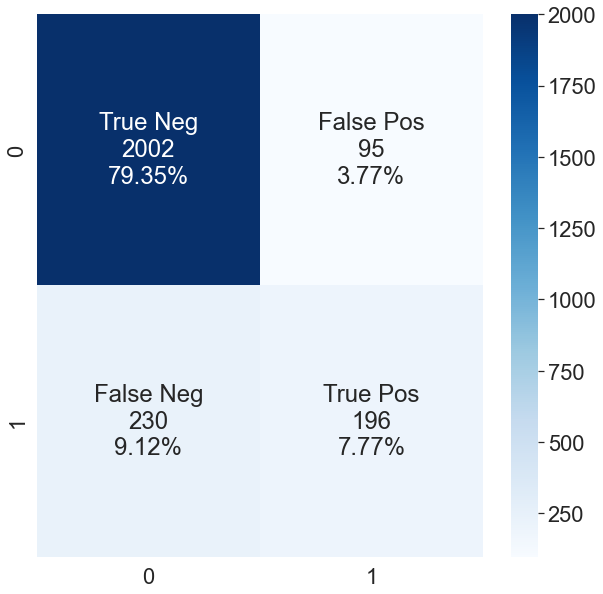

In [55]:
best_knn = KNeighborsClassifier(weights='distance', metric='manhattan', n_neighbors=60)

model_fit = best_knn.fit(X_host,y_host)
knn_validation_predictions = best_knn.predict(X_host_validate)

from sklearn.metrics import accuracy_score
print("Validation Set Accuracy: ", accuracy_score(y_host_validate, knn_validation_predictions))

knn_cm = confusion_matrix(y_host_validate,knn_validation_predictions)
plot_confusion(knn_cm)

# Validation set ROC Curve and AUC for best KNN

0.8922493792831699


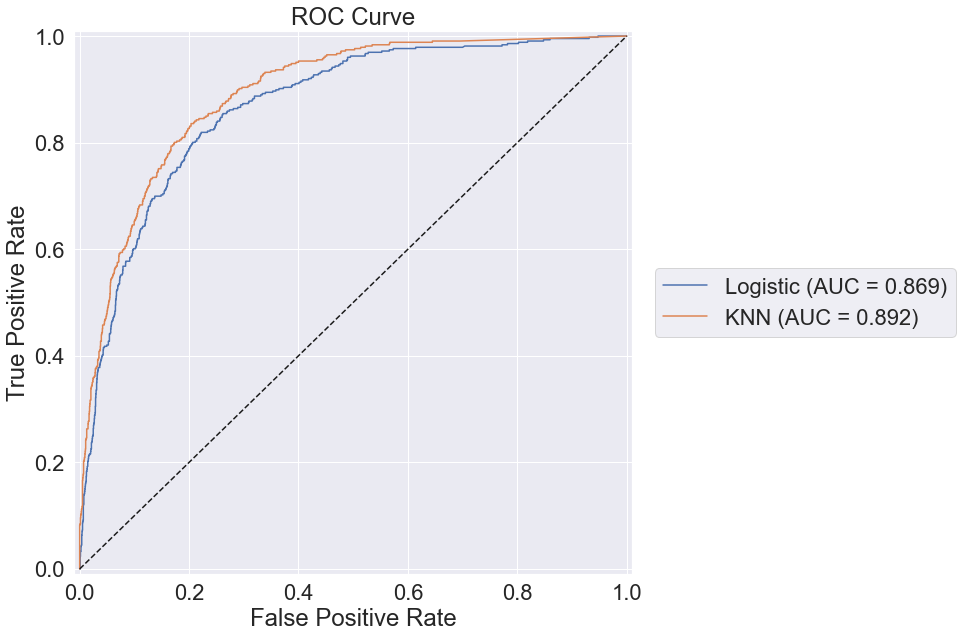

In [56]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Calculate probabilities on predictions (not just classifications) needed for AUC
knn_probabilities = best_knn.predict_proba(X_host_validate)

knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_host_validate, knn_probabilities[:,1])
knn_auc = roc_auc_score(y_host_validate, knn_probabilities[:,1])

print(knn_auc)

# Plot ROC curve
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(lr_fpr, lr_tpr, label='Logistic (AUC = %0.3f)' % lr_auc)
plt.plot(knn_fpr, knn_tpr, label='KNN (AUC = %0.3f)' % knn_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

<a id="RFClass"></a>
# Model #3 Random Forest classification of superhost
Base Model with 10-fold stratified cross validation
### Methodology for dividing our data: Overal Methodology 
<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

In [57]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

cv_results = sklearn.model_selection.cross_validate(rf, X_host, y_host, cv=cv_object, scoring=scorer, return_estimator=True) 
print("Mean Accuracy = ",cv_results['test_accuracy'].mean())
print("Mean Sensitivity = ",cv_results['test_sensitivity'].mean())
print("Mean Specificity = ",cv_results['test_specificity'].mean())

from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Mean Accuracy =  0.8833837099455497
Mean Sensitivity =  0.5369410900783291
Mean Specificity =  0.953697438091132
Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


# Tune Random Forest Hyperparameters with grid search
Note a full grid search on this range of parameters would take too much compute time so we are using randomcv search to pick random combinations of paraeters from the grid

Using <a id="RandForestGridSearch"></a> Grid Search to find the best random forest classification model.

<a href="#bottom">Back to bottom</a>

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [5, 8, 15, 25, 30, 'None'],
    'n_estimators': [50, 150, 300, 500, 800],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [1, 2, 5, 10] 
}

# Random search of parameters search across 100 different combinations, and use all available scores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 20, cv = cv_object, verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')
# Fit the random search model
rf_random.fit(X_host, y_host)

print("Best Accuracy: ",rf_random.best_score_)
print("Best Accuracy: ",rf_random.best_params_)


Fitting 10 folds for each of 20 candidates, totalling 200 fits


C:\Users\TripleDoubleNoAssits\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.91460489 0.91390916        nan 0.90990127 0.91583636 0.91627185
 0.90892318 0.91552208 0.90956304 0.91568353 0.90895125 0.91568367
 0.91552115        nan 0.91534409 0.91480328 0.90872231 0.91446968
 0.9157805  0.90947304]
  warnings.warn(


Best Accuracy:  0.9162718534543597
Best Accuracy:  {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': 15}


The random search was run multiple times with the following results:

Run 1 (10 iterations)
Best Accuracy:  0.8870068793540543
Best Accuracy:  {'n_estimators': 800, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_depth': 25}

Run 2 (20 iterations)
Best Accuracy:  0.8870979332893519
Best Accuracy:  {'n_estimators': 800, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_depth': 25}

split and depth are in middle of grid range, n_estimators and min leaf are at top edge of grid, expand those in new grid in code chunk below

Run 3 (expanded grid range)
# Best Accuracy:  0.9174946387787575
# Best Accuracy:  {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': 15}

Run 4 (expanded grid range same as 3, just checking repeatability)
Best Accuracy:  0.8870066718946438
Best Accuracy:  {'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 8}

Run 5 (added 'None' to grid range for max_depth)
Best Accuracy:  0.8869613627593761
Best Accuracy:  {'n_estimators': 500, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_depth': 30}

# Check performance of tuned random forest model on the validation set

[1 0 0 ... 0 0 0]
Validation Set Accuracy:  0.894966309948474
Validation Set Precision:  0.712401055408971
Validation Set Recall:  0.6338028169014085


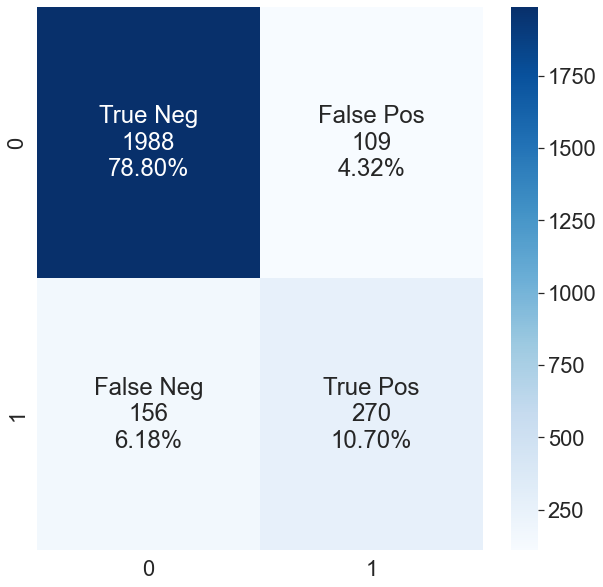

In [60]:
# Best Accuracy:  {'n_estimators': 800, 'min_samples_split':  5, 'min_samples_leaf': 10, 'max_depth': 15}

rf = RandomForestClassifier(max_depth=15, n_estimators=800, min_samples_split=5, min_samples_leaf=10)

training_model = rf.fit(X_host,y_host)
rf_validation_predictions = training_model.predict(X_host_validate)

print(rf_validation_predictions)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


print("Validation Set Accuracy: ", accuracy_score(y_host_validate, rf_validation_predictions))
print("Validation Set Precision: ", precision_score(y_host_validate, rf_validation_predictions))
print("Validation Set Recall: ", recall_score(y_host_validate, rf_validation_predictions))


cm = confusion_matrix(y_host_validate,rf_validation_predictions)
plot_confusion(cm)

# Feature Importance for Random Forest Model

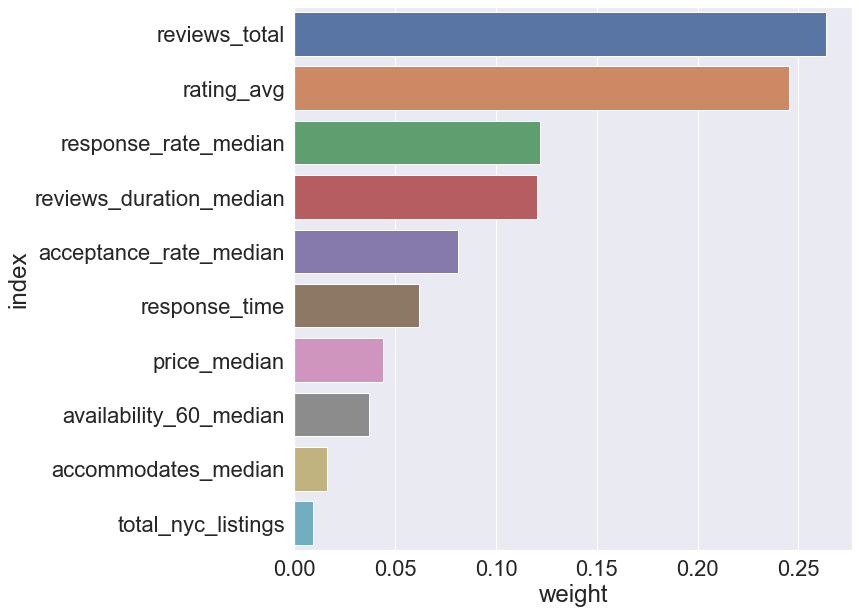

In [61]:

variable_names = host_modeling.drop(['superhost_max','host_id'],axis=1).columns

FeatureImportance = pd.DataFrame(training_model.feature_importances_,variable_names)
FeatureImportance = FeatureImportance.rename(columns={FeatureImportance.columns[0]: 'weight'})
FeatureImportance = FeatureImportance.sort_values(by='weight', key=abs, ascending=False)
FeatureImportance.reset_index(level=0, inplace=True)

plot = sns.barplot(y="index", x="weight", data=FeatureImportance)

# ROC Curve to compare 3 tuned models (trained with CV set, performance on validation set)

0.9146634696111816


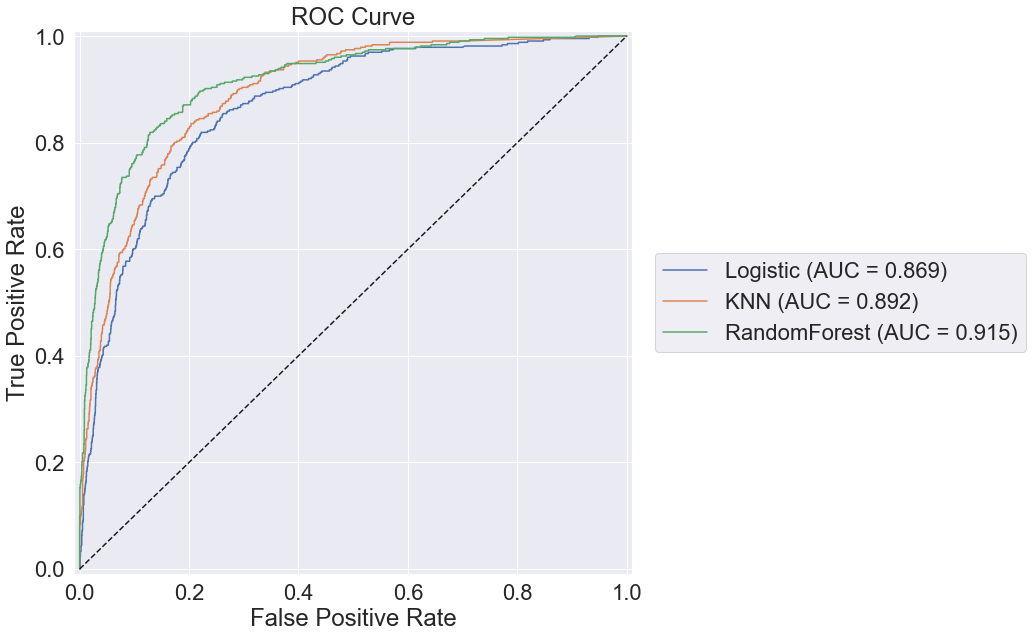

In [62]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Calculate probabilities on predictions (not just classifications) needed for AUC
rf_probabilities = rf.predict_proba(X_host_validate)

rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_host_validate, rf_probabilities[:,1])
rf_auc = roc_auc_score(y_host_validate, rf_probabilities[:,1])

print(rf_auc)

# Plot ROC curve
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(lr_fpr, lr_tpr, label='Logistic (AUC = %0.3f)' % lr_auc)
plt.plot(knn_fpr, knn_tpr, label='KNN (AUC = %0.3f)' % knn_auc)
plt.plot(rf_fpr, rf_tpr, label='RandomForest (AUC = %0.3f)' % rf_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

><a id="AnalClass"></a>
> ## Modeling and Evaluation 4: Analyze the results using your chosen method of evaluation: *Classification*
> 

Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

#### [10 points]
### Three modeling techniques were evaluated, Logistic Regression, KNN and Random Forest. For each technique a base model with default parameters. After tuning hyperparameters to improve upon base model the final models are compared using AUC on the validation set. 

### The AUC-ROC plot below was used was used to visualize the comparison. The ROC with the largest area under curve is the random forest model (AUC=0.91). Logistic and KNN have an AUC of 0.863 and 0.874 respectively. If we want to keep the false positive rate low, Random forest has a significant;y higher true positive rate at every threshold compared to other models

### In the next section we test for statistically significant differences between these models performance (AUC).



<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

0.9146634696111816


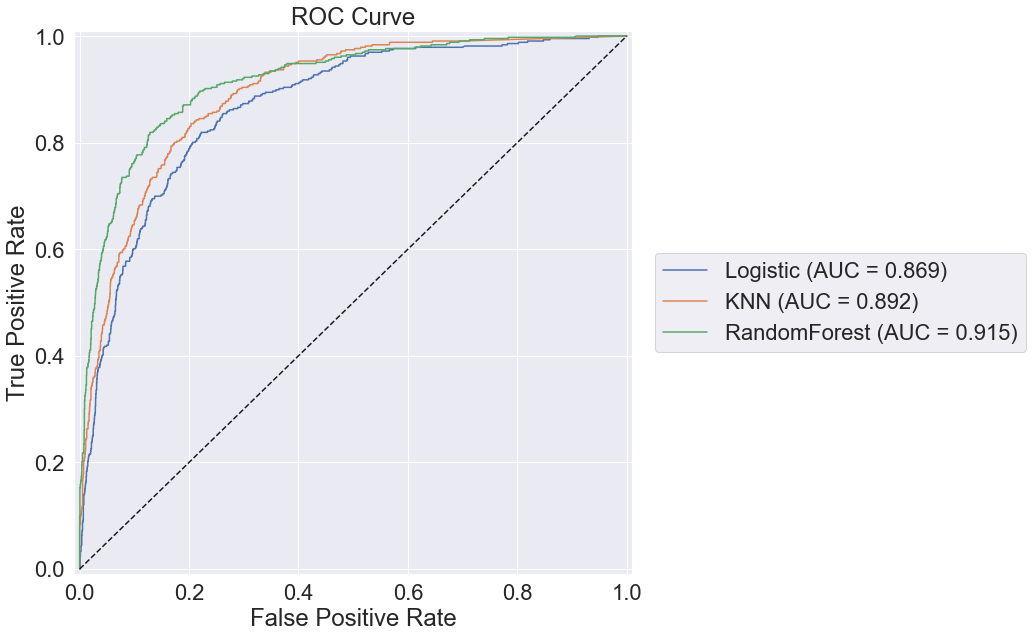

In [63]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Calculate probabilities on predictions (not just classifications) needed for AUC
rf_probabilities = rf.predict_proba(X_host_validate)

rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_host_validate, rf_probabilities[:,1])
rf_auc = roc_auc_score(y_host_validate, rf_probabilities[:,1])

print(rf_auc)

# Plot ROC curve
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(lr_fpr, lr_tpr, label='Logistic (AUC = %0.3f)' % lr_auc)
plt.plot(knn_fpr, knn_tpr, label='KNN (AUC = %0.3f)' % knn_auc)
plt.plot(rf_fpr, rf_tpr, label='RandomForest (AUC = %0.3f)' % rf_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

><a id="DissClass"></a>
> ## Modeling & Evaluation 5: Discuss the advantages of each model: *Classification*
> 

(if any) If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods.
<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

## Logistic Regression: 
The key advantage is the interpretability of feature coefficients. Using the coefficients for scaled data we can determine feature importance. The coefficients also tell us whether the feature has a positive or negative association with superhost status. Since our main goal of this analysis is to give guidance on the most important actions hosts can take to become a superhost (rather than just make classifications), this is a huge advantage.

Our model is quick to train. Feature weights make sense intuitively with host rating being the most important, and a negative weight for longer host response times. However Random Forest had better overall classification performance and showed the total number of reviews as most important. While Logistic's main advantage is interpretability, it may not perform as well if there are feature relationships that are not linear with the log odds.

## KNN: 
The advantage of KNN is that performance did improve compared to Logistic Regression. It is non-parametric and could be gaining performance by better predicting some non-linear relationships. However, the performance gain is not statistically significant and we lost the ease of feature importance interpretation. Recursive feature elimination is an alternative way to look at feature importance with KNN, but based on the dataset size and 10-fold cross validation, we found RFE to be too costly with computing time.

## Random Forest: 
The key advantage is that it provided the best AUC (and highest accuracy). It is able to balance the bias-variance trade-off, and fit non-parametric data, by averaging across multiple decision trees. The random forest model outperformed the KNN and logistic regression and with 95% confidence there is evidence of a significant difference between the random forest model and both the KNN and Logistic regression models. Another advantage was an alternative view of the feature importance which shows strongest weight on the total number of reviews increasing probability of becoming a superhost.

## Best Model:
Based on the ROC plot and the statistal tests of performance below, Random Forest is our best model




#### Check Significance of performance difference between models (AUC) by performing 5x2cv paired t tests


In [64]:
from mlxtend.evaluate import paired_ttest_5x2cv
import warnings

warnings.filterwarnings("ignore")

t, p = paired_ttest_5x2cv(estimator1=lr,
                          estimator2=rf,
                          X=X_host_validate, y=y_host_validate,
                          random_seed=27, scoring='roc_auc')

print('Logistic Regression vs. Random Forest')
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)


Logistic Regression vs. Random Forest
t statistic: -5.879
p value: 0.002


Random Forest vs Logistic Regression: With a **p-value of 0.002 (less than alpha=0.05)** we **reject** the null hypothesis and conclude with 95% confidence there is a significant difference in the performance of these models


In [65]:
from mlxtend.evaluate import paired_ttest_5x2cv

t, p = paired_ttest_5x2cv(estimator1=lr,
                          estimator2=best_knn,
                          X=X_host_validate, y=y_host_validate,
                          random_seed=27, scoring='roc_auc')

print('Logistic Regression vs. KNN')
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)


Logistic Regression vs. KNN
t statistic: -1.651
p value: 0.160


KNN vs. Logistic Regression: With a **p-value of 0.16 (greater than alpha=0.05)** we **fail to reject** the null hypothesis and for 95% confidence there is not sufficient evidence the performance difference is significant


In [66]:
from mlxtend.evaluate import paired_ttest_5x2cv

t, p = paired_ttest_5x2cv(estimator1=best_knn,
                          estimator2=rf,
                          X=X_host_validate, y=y_host_validate,
                          random_seed=27, scoring='roc_auc')

print('KNN vs Random Forest')
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)


KNN vs Random Forest
t statistic: -3.692
p value: 0.014


 Random Forest vs KNN: With a **p-value of 0.02 (less than alpha=0.05)** we **reject** the null hypothesis and conclude with 95% confidence there is a significant difference in the performance of these models

> <a id="ImpClass"></a>
> ## Modeling & Evaluation 6: Which attributes from your analysis are most important?: *Classification*
> 

Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.


> #### [10 points]
<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

The plot below shows a comparison of the feature importance of Logistic Regression vs. Random Forest. The rankings are very similar with one key difference: Random Forest shows the total number of reviews for a host to be the strongest factor in reaching superhost, while this feature is significantly lower in the rankings on Logistic Regression.

The %Superhost relationship with reviews_total may not exhibit a linear relationship to the log-odds, possibly explaining why non-parametric (Random Forest) places more importance and better performance than Logistic. 

For discussion on other important factors to attaining superhost status see the section below plots

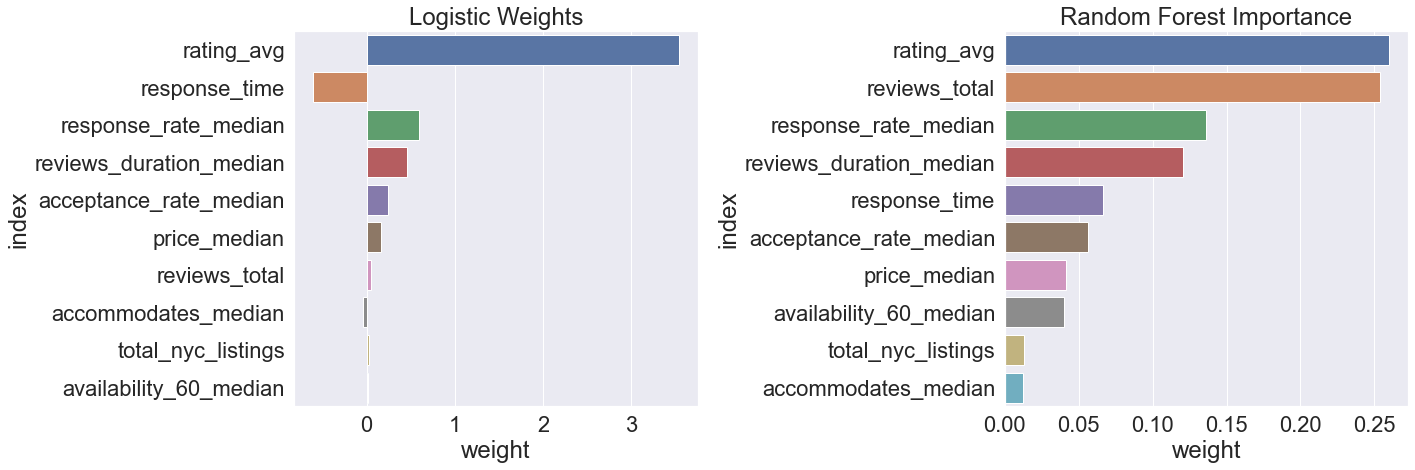

In [67]:
weights = lr_model_fit.coef_.T # take transpose to make a column vector
variable_names = host_validation.drop(['superhost_max','host_id'],axis=1).columns 

coefficients = pd.DataFrame(weights,variable_names)
coefficients = coefficients.rename(columns={coefficients.columns[0]: 'weight'})
coefficients = coefficients.sort_values(by='weight', key=abs, ascending=False)
coefficients.reset_index(level=0, inplace=True)

FeatureImportance = pd.DataFrame(training_model.feature_importances_,variable_names)
FeatureImportance = FeatureImportance.rename(columns={FeatureImportance.columns[0]: 'weight'})
FeatureImportance = FeatureImportance.sort_values(by='weight', key=abs, ascending=False)
FeatureImportance.reset_index(level=0, inplace=True)

plt.close('all')
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16.5, 6)
fig.tight_layout(pad=0.4, w_pad=10.5, h_pad=1.0)

ax = sns.barplot(y="index", x="weight", data=coefficients, ax=axes[0]).set_title("Logistic Weights")
ax = sns.barplot(y="index", x="weight", data=FeatureImportance, ax=axes[1]).set_title("Random Forest Importance")


### Interpret Feature Importance
<a id="TerpClass"></a>
#### [30 Points]

 *Note that all of these are new features we created with host level summary statistics based on research and domain knowledge of airbnb publicly disclosed portions of the superhost algorithm*

**Average Host Rating**:
The strongest predictor if superhost status for Logistic Regression is the overall star rating given by guests who have stayed at the property. Higher ratings produce higher probability of becoming a superhost and this makes since given that a rating above 4.8 is one of the stated criteria by Airbnb

**Number of Reviews**:
Although not the strongest predictor in Logistic Regression, this is by far the most important predictor in our Random Forest Model. The hgher total number of reviews a host receives does increase probability of reaching superhost status. This makes sense in the context of law of averages with small sample sizes. A 4.8 rating on a scale of 5 means hosts need a 96% rating, for hosts with a small number of reviews a single 3 or 4 guest rating would bring them below the airbnb criteria. A higher number of reviews could also indicate the property is popular or has been listed a long time and the host has more experience which could lead them to knowing to respond quickly and provide guests with top customer service

**Response Rate**:
The more often a host responds to guest booking requests and inquiries for information or assistance also increases the probability of becoming a superhost and is another key predictor of superhost status

**Response Time**:
In addition to a high reponse rate, the amount of time a host takes to respond also affects the chances of reaching superhost status. Instead of dummy encoding this variable as was done in the minilab, we changed this to an ordinal variable for these models. This oridnal feature shows that hosts responding within an hour are more likely to attain superhost status and the longer they take to respond the lower their probability of attaining superhost status.

**Acceptance Rate**:
While not a significant predictor, higher acceptance rate for guests slightly improves probability of superhost status. Counter to this idea, an experienced host may not accept guests who do not have experience or reviews to prevent problem guests. These competing trade-offs may explain why overall this variable is not a strong predictor overall

**Price**:
It's important to recognize that rental price is not a significant estimator for superhost status. By providing good customer service and property value, hosts at any price level can achieve superhost status to boost their listing visibility, bookings, and hopefully revenue.

**Accomodations**:
It's also important to recognize that the amount of guests a property accomdates does not significantly affect chances of reaching superhost status. Similar to pricing, good service and value can be rewarded with superhost status across all property sizes

**Availability**:
The amount of days a property available is also not significant in predicting superhost status. This variable could be interpreted two ways, low availability could be due to hosts only renting their home on weekends or convenient times, or it could indicate that the property is very in demand and has already booked up. In either case the low availability does not seem to significantly impact the chances of becoming a superhost if the quality of stays are highly rated

**Total Listings**:
Some hosts just rent their one personal residence, some hosts have tens of listings they manage professionally. The fact that the amount of listings per host is not a significant predictor of superhost status indicates that the quality of stay provided is what's important whether you host professionally or as a side gig.

<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

<a id="dataReg"></a>
___
# Data Preparation Part 1: *Regression*
___
#### [15 points total] 

## Variable Selection - Continous Variables
Corrplot was created to check for Multi-collinearity among continous variables

<AxesSubplot:>

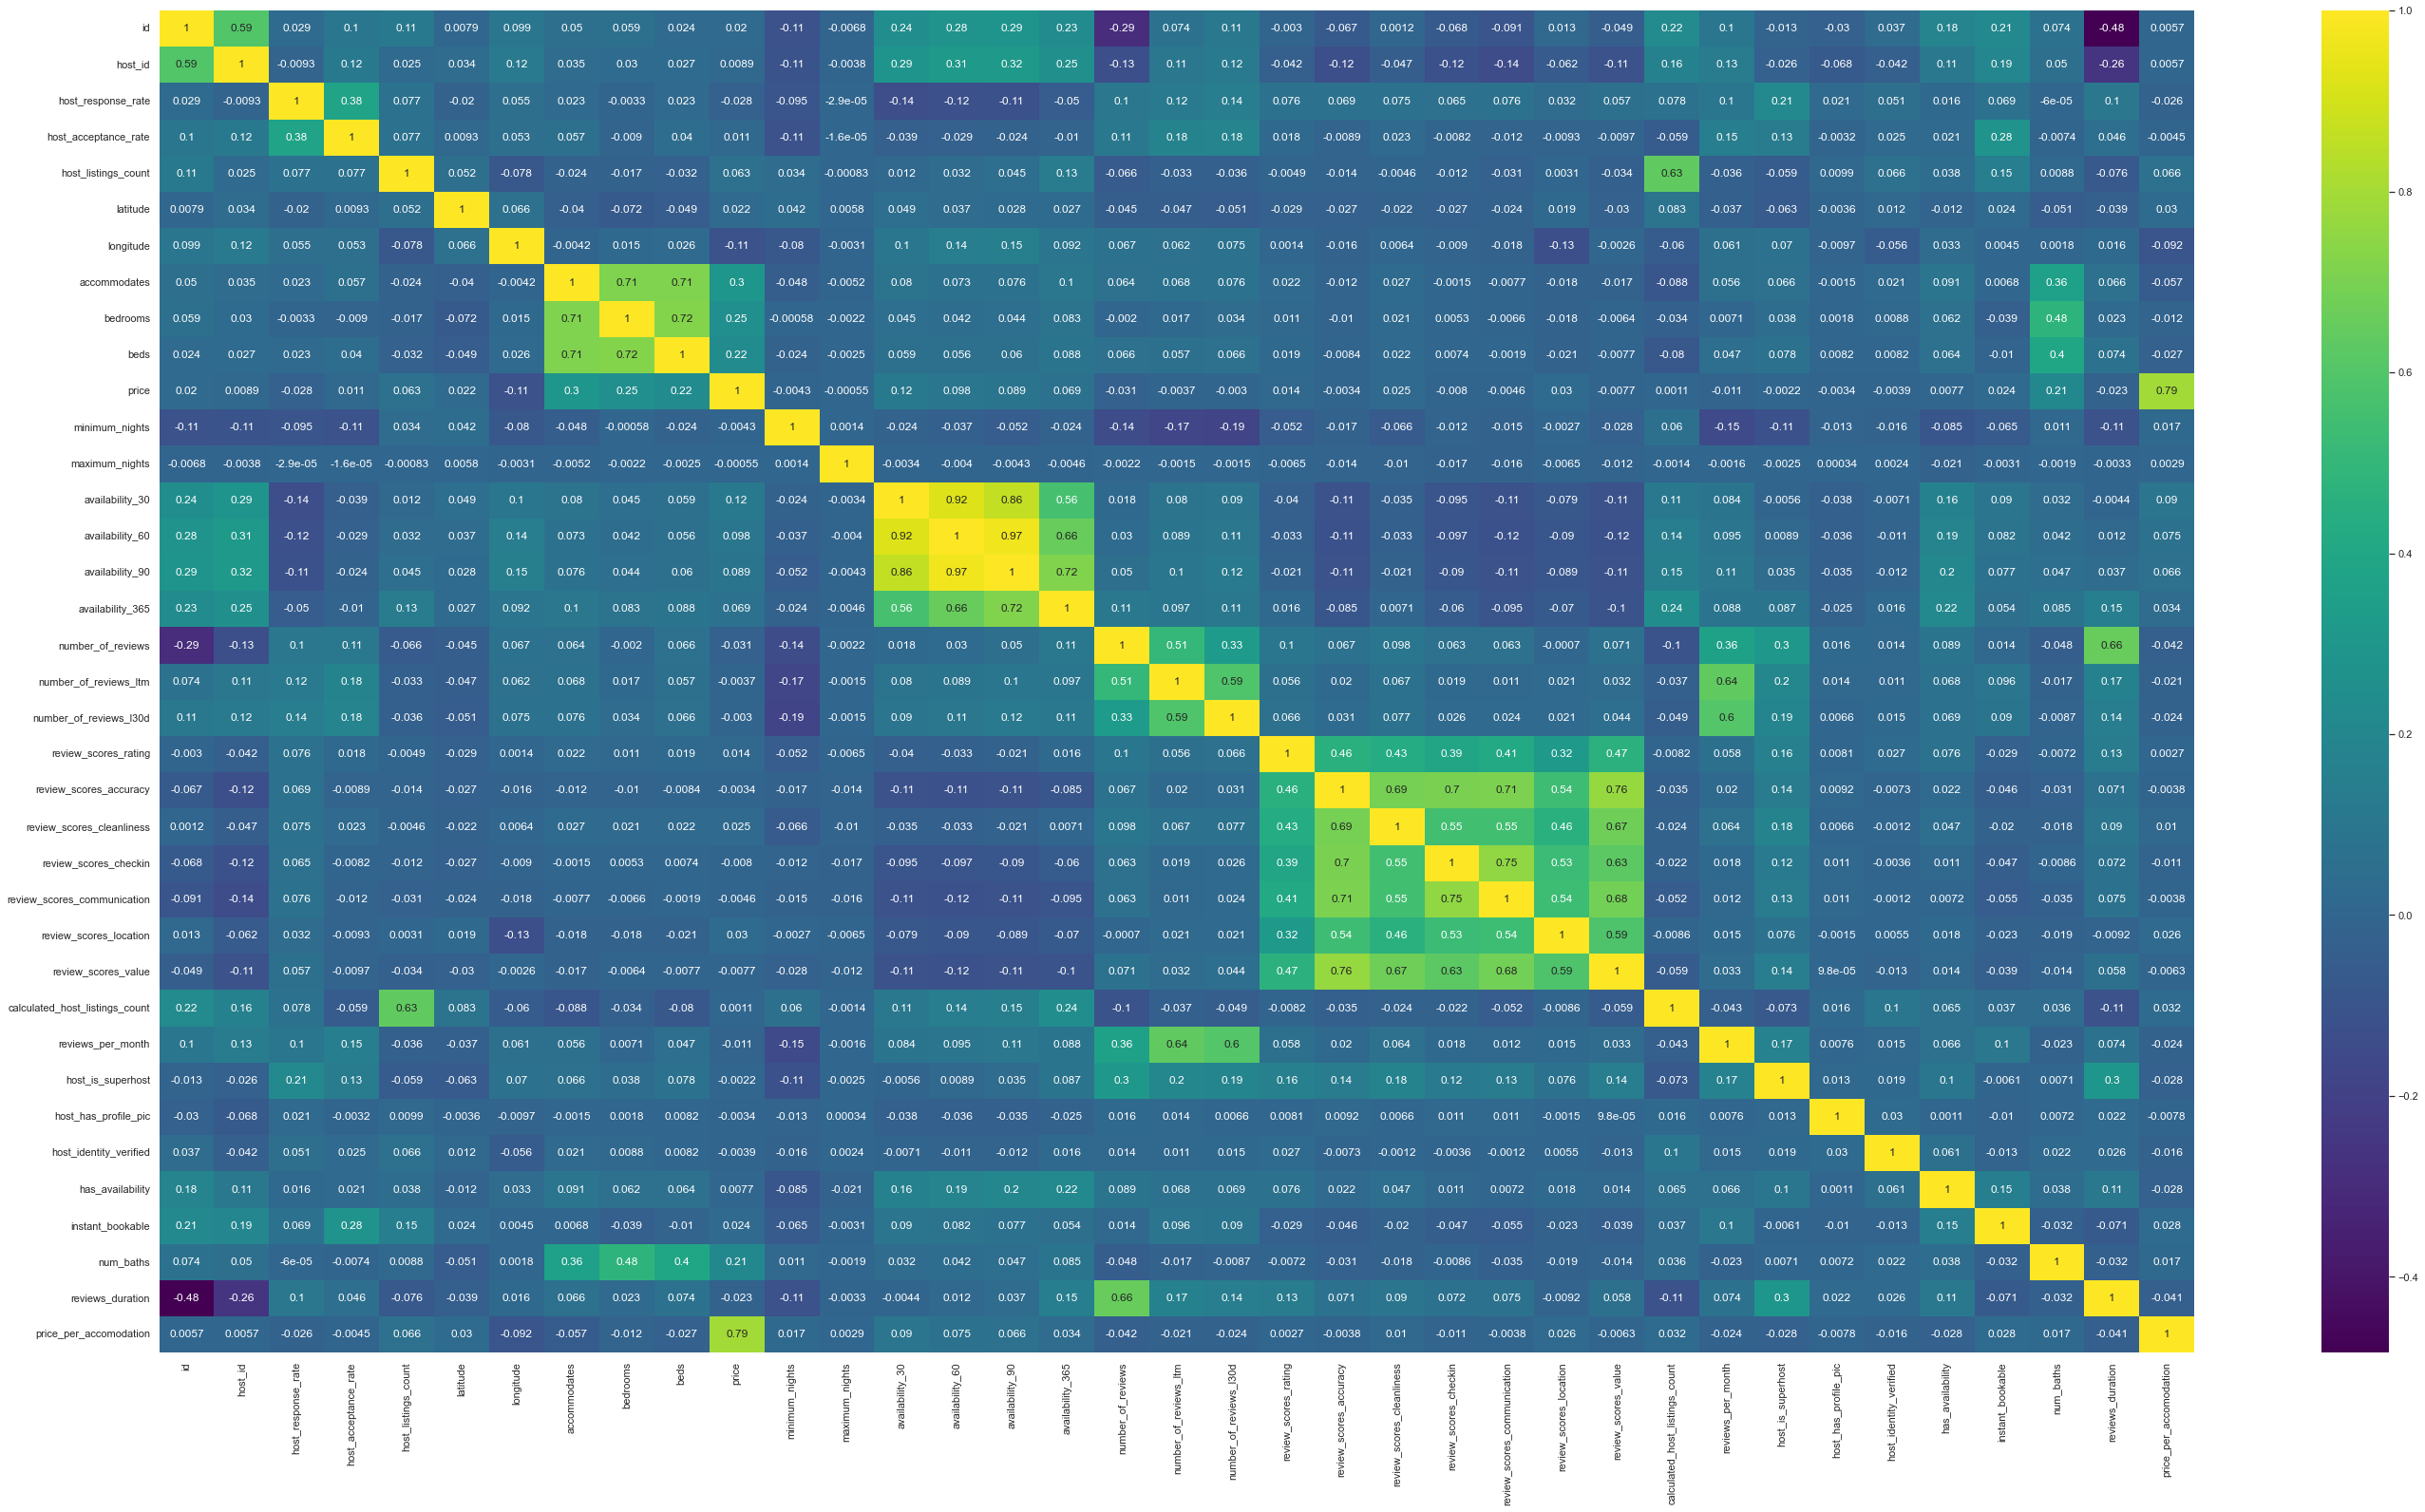

In [68]:
listings2 = listings

plt.figure(figsize=(48,26))
sns.set(font_scale=1)
sns.heatmap(listings2.corr(),annot=True,cmap='viridis')

**We can observe groupings of high correlations**

High Upper Right

- host_id
- id

That mid upper left square of green-ish yellow

- Beds
- Bedrooms
- Accomodates

That Center Grouping of mostly Yellow and green

- availablity_30
- availablity_60
- availablity_90
- availablity_365

That diagonal to the right of availablity grouping

- number_of_reviews
- number_of_reviews_ltm
- number_of_130

Down and Right from there

- review_scores_accuracy
- review_scores_cleanliness
- review_scores_checkin
- review_scores_communication
- review_scores_location
- review_scores_value

One offs

- (0.66) host_listing_count and calculated_host_listing_count
- (0.79) price and pirce_per_accommodation
- (0.66) number_of_reviews and reviews_duration
- (0.64) number_of_reviews_ltm, reviews_per_month_130d, and reviews_per_month

To determine which variables we will keep, a correlation plot of the variables against the dependent variable 'price' will inform us which varaibles have the highest correlation. We will then keep the highest ranking variable within the group to avoid multicollinearity. 

Text(0.5, 1.0, 'Correlation Plot between Price and Other Numerical Variables')

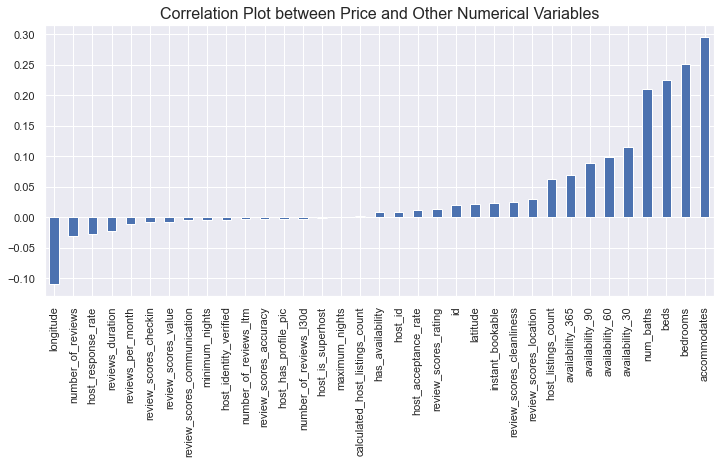

In [69]:
plt.figure(figsize = (12,5))
sns.set(font_scale=1)
listings2.corr()['price'].sort_values().drop(['price','price_per_accomodation']).plot(kind='bar').set_title('Correlation Plot between Price and Other Numerical Variables', fontsize=16)
#price_per_accommodation is excluded due to it calculated from price column

<a id="defineReg"></a> 
> ##  Define and Prepare Your Regression Variables 
> 
Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. 

> #### [10 points]

<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

**Here we are deleting variables that have high colinearity based on the observations from the correlation and which have a high ranking against price.**

1. accomodates
2. bedrooms (delete)
3. beds (delete)
4. num_bath
5. availability_30
6. availability_60 (delete)
7. availability_90 (delete)
8. availability_365 (delete)
9. host_listing_count
10. review_scores_location
11. review_scores_cleanliness (delete)
12. instant_bookable
13. latitude
14. id (delete)
15. review_scores_rating (delete)
16. host_acceptance_rating
17. host_id (delete)
18. has_availability
19. calculated_host_listings_count (delete)
20. maximum_nights (delete)
21. host_is_superhost (delete)
22. number_of_reviews_l30d (delete)
23. host_has_profile_pic
24. review_scores_accuracy (delete)
25. number_of_reviews_ltm (delete)
26. host_identity_verified
27. minimum_nights
28. review_scores_communication (delete)
29. review_scores_value (delete)
30. review_scores_checkin (delete)
31. reviewd_per_month
32. reviews_duration (delete)
33. host_response_rate
34. number_of_reviews
35. longtitude

In [70]:
drop_variables = ['price_per_accomodation','bedrooms','beds','availability_60','availability_90','availability_365','review_scores_cleanliness','id','review_scores_rating','host_id',
                  'calculated_host_listings_count','maximum_nights','host_is_superhost','number_of_reviews_l30d','review_scores_accuracy','number_of_reviews_ltm',
                  'review_scores_communication','review_scores_value','review_scores_checkin','reviews_duration','last_scraped','host_since']


listings2 = listings2.drop(drop_variables, axis=1)

print(listings2.shape)
print(listings2.columns)

(35953, 37)
Index(['name', 'description', 'neighborhood_overview', 'host_name',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_neighbourhood',
       'host_listings_count', 'host_verifications', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'amenities',
       'price', 'minimum_nights', 'availability_30', 'number_of_reviews',
       'first_review', 'last_review', 'review_scores_location',
       'reviews_per_month', 'host_has_profile_pic', 'host_identity_verified',
       'has_availability', 'instant_bookable', 'num_baths', 'bath_type',
       'room_privacy', 'domicile_type'],
      dtype='object')


## Variable Selection - Categorical Variables
To determine which categorical variables to drop, we look at number of unique values in each variable to see if it will be do-able for one-hot encode.

In [71]:
listings2[['name','description','neighborhood_overview','host_name','host_location','host_about','host_response_time','host_neighbourhood',
        'host_verifications','neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed','property_type','room_type','amenities',
        'first_review','last_review','bath_type','room_privacy','domicile_type']].describe().transpose()

count unique                                top  \
name                          35953  34905     Water View King Bed Hotel Room   
description                   35953  32744                            missing   
neighborhood_overview         35953  18433                            missing   
host_name                     35953   8877                               June   
host_location                 35953   1573  New York, New York, United States   
host_about                    35953  14416                            missing   
host_response_time            35953      5                            missing   
host_neighbourhood            35953    445                            missing   
host_verifications            35953    528                 ['email', 'phone']   
neighbourhood                 35953    208                            missing   
neighbourhood_cleansed        35953    223                 Bedford-Stuyvesant   
neighbourhood_group_cleansed  35953      5                          Manhattan   
property_type                 35953     66                 entire rental-unit   
room_type                     35953      4                    Entire home/apt   
amenities                     35953  29940        ["Long term stays allowed"]   
first_review                  35953   3073                         2021-10-22   
last_review                   35953   2445                         2021-10-22   
bath_type                     35953      2                            private   
room_privacy                  35953      3                             entire   
domicile_type                 35953     37                        rental-unit   

                               freq  
name                             27  
description                    1130  
neighborhood_overview         13610  
host_name                       316  
host_location                 20989  
host_about                    14529  
host_response_time            15397  
host_neighbourhood             6613  
host_verifications             3234  
neighbourhood                 13610  
neighbourhood_cleansed         2638  
neighbourhood_group_cleansed  15734  
property_type                 15280  
room_type                     19242  
amenities                       117  
first_review                   8990  
last_review                    8990  
bath_type                     24906  
room_privacy                  19207  
domicile_type                 26926

We then drop the variables that have too many unique values which will be difficult to work with one-hot encode.

In [72]:
drop_variables2 = ['name','description','neighborhood_overview','host_name','host_location','host_about','host_neighbourhood',
                   'host_verifications','neighbourhood','neighbourhood_cleansed','property_type','amenities',
                   'first_review','last_review']


listings2 = listings2.drop(drop_variables2, axis=1)

print(listings2.shape)
print(listings2.columns)

(35953, 23)
Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_listings_count', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'room_type', 'accommodates', 'price', 'minimum_nights',
       'availability_30', 'number_of_reviews', 'review_scores_location',
       'reviews_per_month', 'host_has_profile_pic', 'host_identity_verified',
       'has_availability', 'instant_bookable', 'num_baths', 'bath_type',
       'room_privacy', 'domicile_type'],
      dtype='object')


There are 37 unique values in domicile_type.  We decided to group some of the smaller group into 'OTHER' category.

In [73]:
listings2['domicile_type']=listings2['domicile_type'].replace(['train', 'in-law', 'tower', 'island','farm', 
                                                               'cave','dorm','lighthouse','Bus','castle','tent','barn',
                                                               'earth-house','houseboat','boat','cottage','floor','villa',
                                                               'tiny-house','rv','bungalow','resort','room','place',
                                                               'aparthotel'], 'OTHER')

After looking at number of unique value categorical column, we decided to keep only host_response_time, neighbourhood_group_cleansed, room_type, bath_type, room_privacy, and domicile_type because they 

In [74]:
listings2[['host_response_time','neighbourhood_group_cleansed','room_type','bath_type','room_privacy','domicile_type']].describe().transpose()

count unique              top   freq
host_response_time            35953      5          missing  15397
neighbourhood_group_cleansed  35953      5        Manhattan  15734
room_type                     35953      4  Entire home/apt  19242
bath_type                     35953      2          private  24906
room_privacy                  35953      3           entire  19207
domicile_type                 35953     13      rental-unit  26926

One-hot encode categorical variables then drop originals.

In [75]:
Categoricals_to_convert = ['host_response_time','neighbourhood_group_cleansed','room_type','bath_type','room_privacy','domicile_type']

# using pd get dummies for the category columns we are keeping
dummies = pd.get_dummies(listings2[Categoricals_to_convert],drop_first=True)

#dropping original columns
listings_df = listings2.drop(Categoricals_to_convert,axis=1)

#concating dummies to the data frame
listings_df = pd.concat([listings_df,dummies],axis=1)

#convert boolean variables to int so they can be included in VIF calculations
boolean_variables = ['host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']
listings_df[boolean_variables] = listings_df[boolean_variables].astype(int)

listings_df.head()

host_response_rate  host_acceptance_rate  host_listings_count  latitude  \
0           86.330958             75.619603                    6  40.75356   
1           50.000000             88.000000                    1  40.68494   
3           88.000000             33.000000                    1  40.66265   
4          100.000000            100.000000                    1  40.76457   
5           86.330958             75.619603                    1  40.80380   

   longitude  accommodates  price  minimum_nights  availability_30  \
0  -73.98559             1  150.0              30                6   
1  -73.95765             3   75.0               1                0   
3  -73.99454             4  275.0               5                7   
4  -73.98317             2   61.0               2                3   
5  -73.96751             1   75.0               2                0   

   number_of_reviews  review_scores_location  reviews_per_month  \
0                 48                    4.86               0.34   
1                408                    4.72               5.09   
3                  1                    4.00               0.01   
4                485                    4.86               3.63   
5                118                    4.94               0.90   

   host_has_profile_pic  host_identity_verified  has_availability  \
0                     1                       1                 1   
1                     1                       1                 1   
3                     1                       1                 1   
4                     1                       0                 1   
5                     1                       1                 1   

   instant_bookable  num_baths  host_response_time_missing  \
0                 0        1.0                           1   
1                 0        1.0                           0   
3                 0        1.5                           0   
4                 0        1.0                           0   
5                 0        1.0                           1   

   host_response_time_within a day  host_response_time_within a few hours  \
0                                0                                      0   
1                                1                                      0   
3                                1                                      0   
4                                0                                      0   
5                                0                                      0   

   host_response_time_within an hour  neighbourhood_group_cleansed_Brooklyn  \
0                                  0                                      0   
1                                  0                                      1   
3                                  0                                      1   
4                                  1                                      0   
5                                  0                                      0   

   neighbourhood_group_cleansed_Manhattan  \
0                                       1   
1                                       0   
3                                       0   
4                                       1   
5                                       1   

   neighbourhood_group_cleansed_Queens  \
0                                    0   
1                                    0   
3                                    0   
4                                    0   
5                                    0   

   neighbourhood_group_cleansed_Staten Island  room_type_Hotel room  \
0                                           0                     0   
1                                           0                     0   
3                                           0                     0   
4                                           0                     0   
5                                           0                     0   

   room_type_Private room  room_t

<AxesSubplot:>

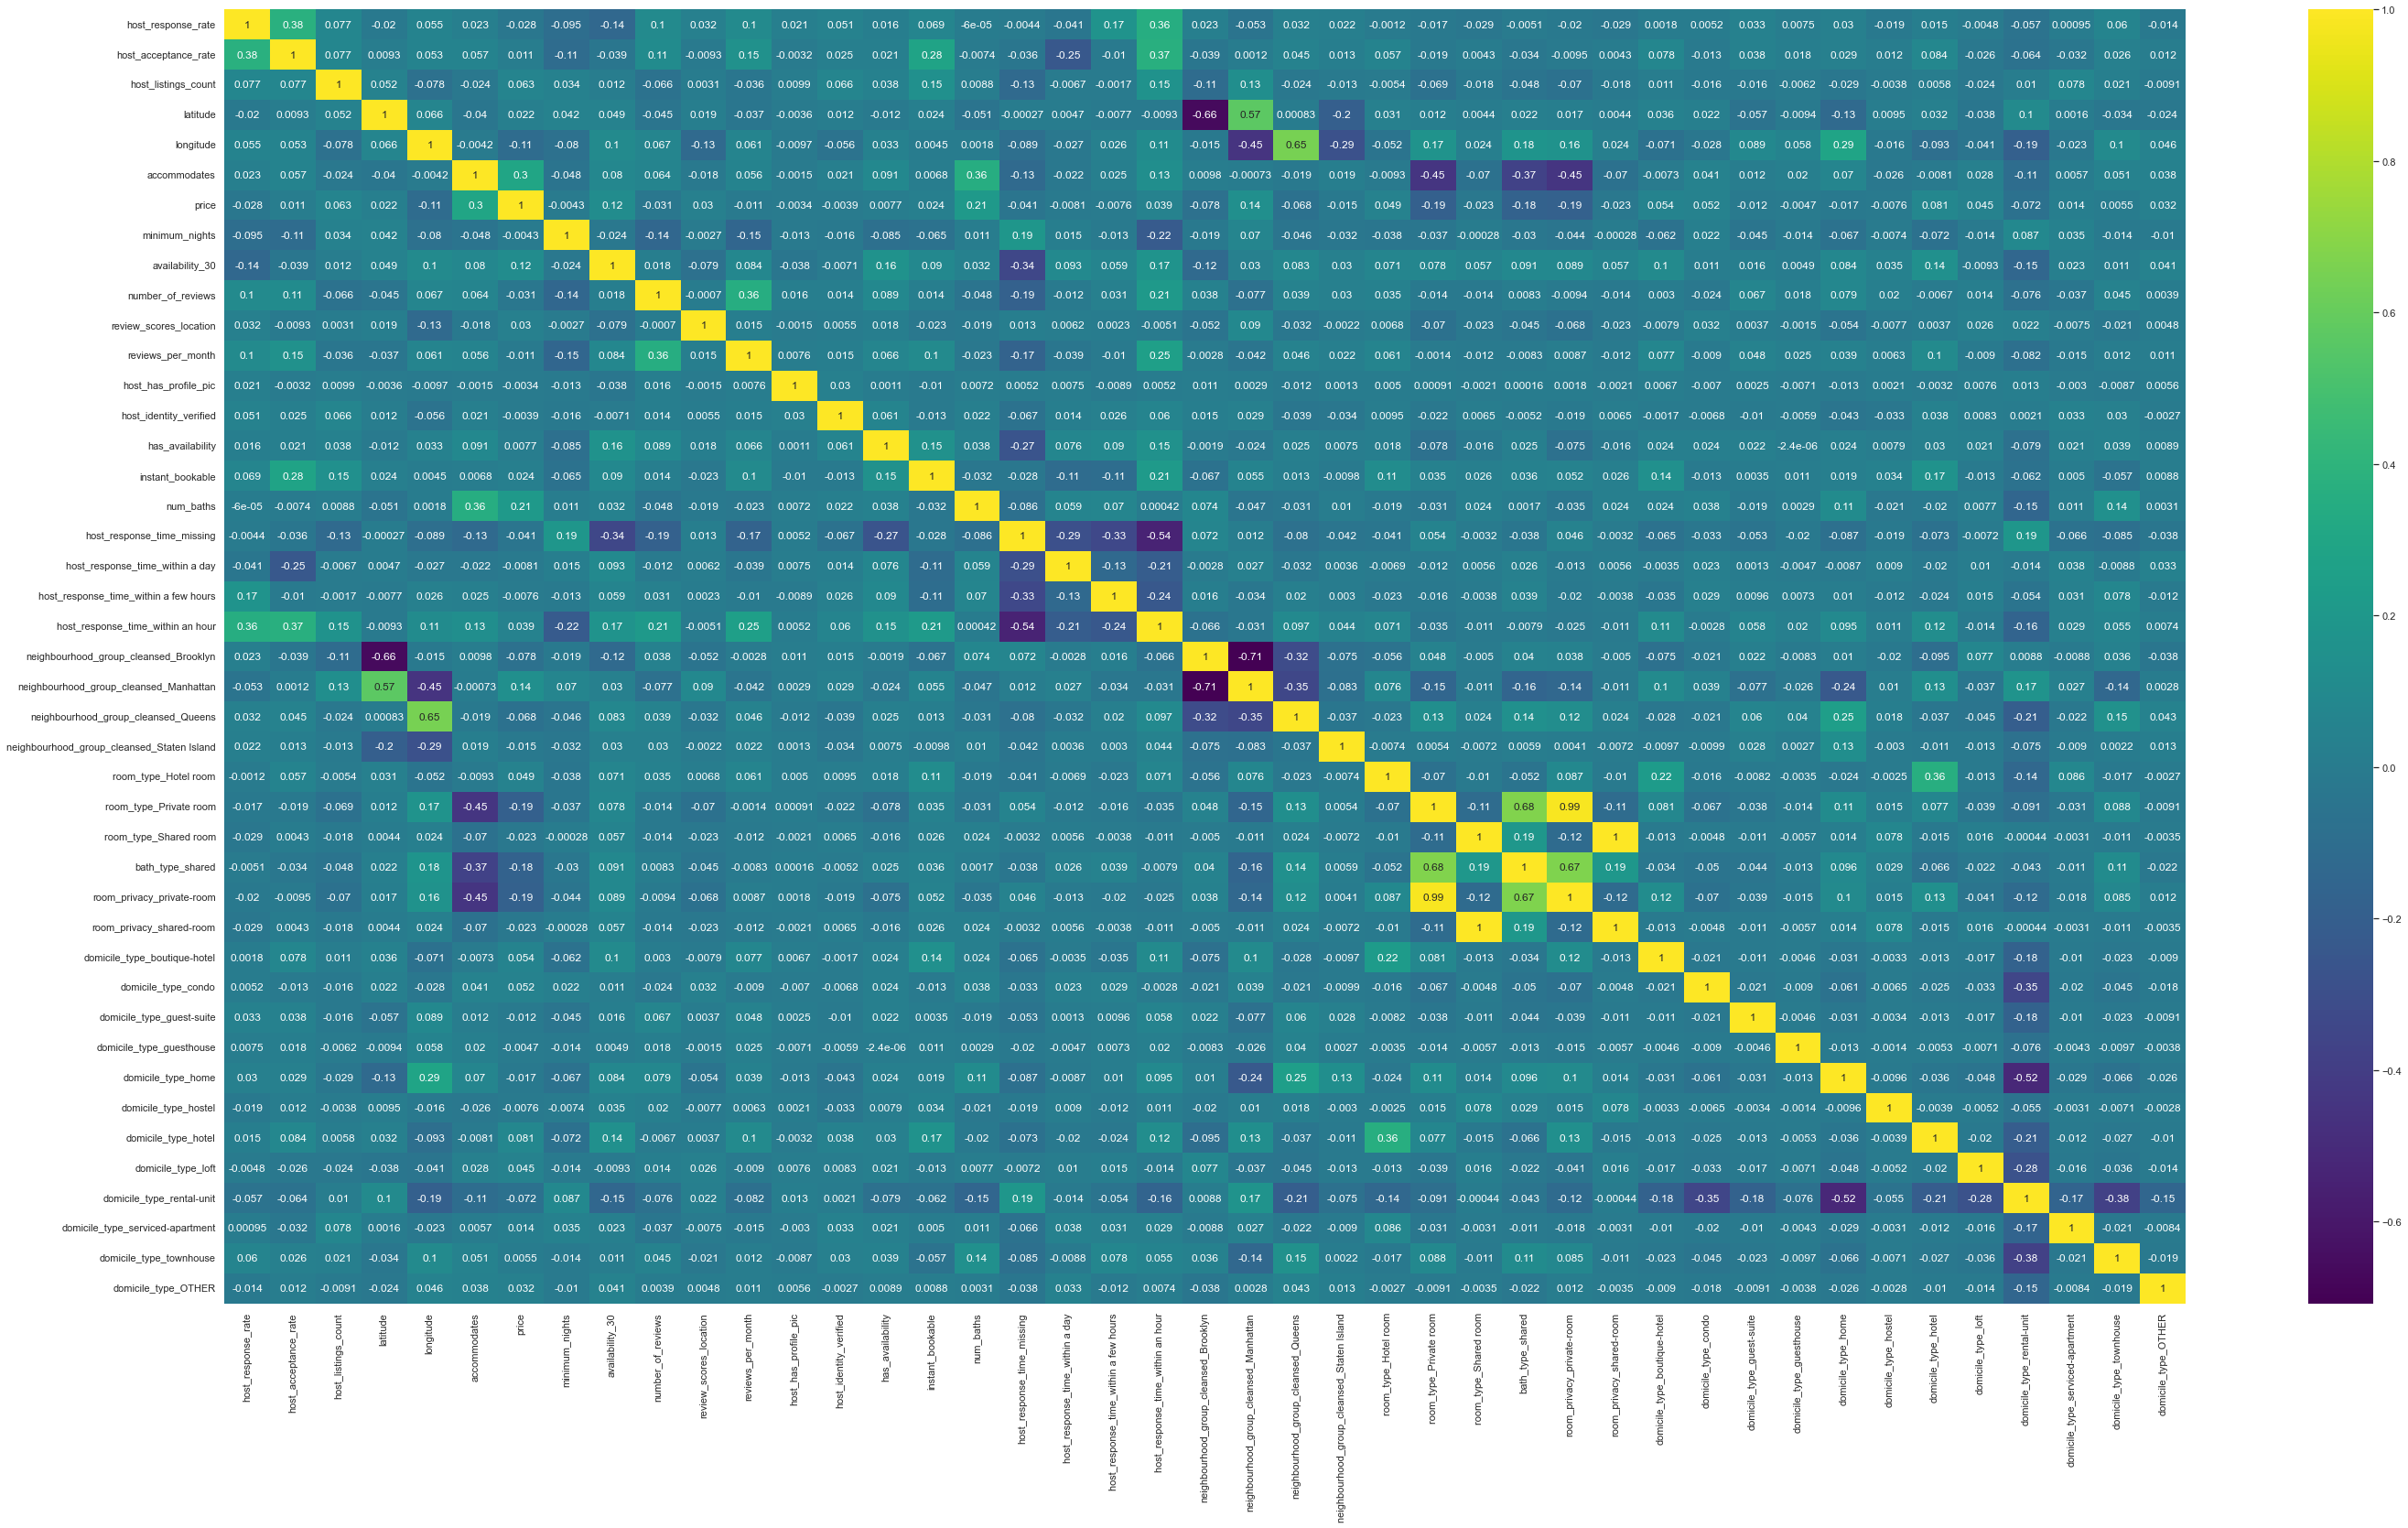

In [76]:
plt.figure(figsize=(48,26))
sns.set(font_scale=1)
sns.heatmap(listings_df.corr(),annot=True,cmap='viridis')

room_privacy has high correlation with room_type and bath_type so we dicided to drop room_privacy from the dataset.

In [77]:
listings_df.drop(['room_privacy_private-room','room_privacy_shared-room'], axis=1, inplace=True)

## A closer look on response variable, **Price**

From the histogram and QQ-plot, the variable show heavily righ-skewed distribution.

Skewness: 19.876857
Kurtosis: 572.762624


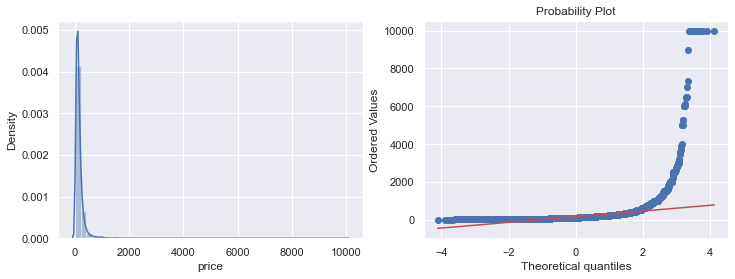

In [78]:
import matplotlib
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.distplot(listings_df['price'], ax=ax[0])
stats.probplot(listings_df['price'], dist="norm", plot=ax[1])

print("Skewness: %f" % listings_df['price'].skew())
print("Kurtosis: %f" % listings_df['price'].kurt())

Log transformation might help making the response variable more normally distributed.

Skewness: 0.704550
Kurtosis: 1.485291


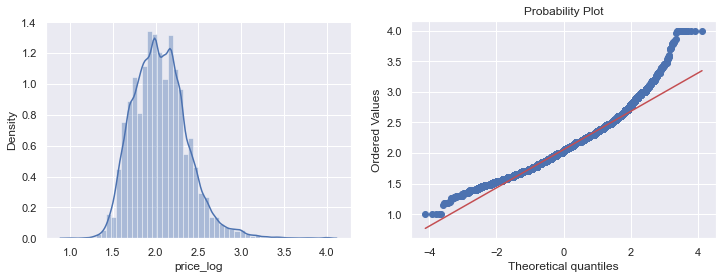

In [79]:
listings_df['price_log'] = np.log10(listings_df['price'])

fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.distplot(listings_df['price_log'], ax=ax[0])
stats.probplot(listings_df['price_log'], dist="norm", plot=ax[1])

print("Skewness: %f" % listings_df['price_log'].skew())
print("Kurtosis: %f" % listings_df['price_log'].kurt())

### **Remove Outliers and describe target variable**

**Normalizing the data:**
With log transformation, both histogram and QQ plot show much more normal distribution of price

**Investigation of outliers:**
We then dig into more details for each extremely high and low price listings by going through their urls.  We found that:

**All listings above 5,000 USD** are either 
- Hotel advertisement lisitings with zero availability which do not allow guests to book through Airbnb
- Normal listings with zero availability which do not allow guests to book and/or hosts have not been active for over a year.  This looks like the hosts set the extremely high price to deactivate the listings without deleting from Airbnb website.

**All listings below 14 USD** (yes!  you can stay in NYC for 14 USD a night, exchange for cats sittng for the host) are either
- Hotel advertisement lisitings with zero availability which do not allow guests to book through Airbnb
- Normal listings with zero availability which do not allow guests to book.  This looks like the hosts set the extremely low price to deactivate the listings without deleting from Airbnb website.

We decided to leave the listings less than 14 USD and above 5,000 USD out from the dataset.  The histogram and QQ-plot still shows little right skewed distribution but over all look more normally distributed.

**Describe target variable:**
___
Price is our target variable. In order to normalize our data Log transformation is utilized. The target variable for all regression model is log_price.
___
* **price** -  Float16 value indicating the cost per night to stay at the listing. Values range from 0 – 10,000 in U.S. Dollars. There are 853 unique values in this column.
> **price_log** - is the natural log of price. <br>

<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

Skewness: 0.589623
Kurtosis: 0.768479


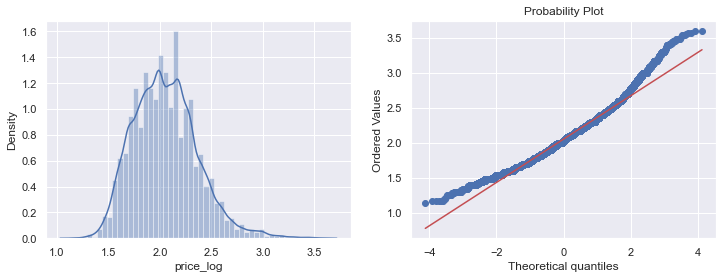

In [80]:
listings_cleaned = listings_df[(listings_df.price >= 14) & (listings_df.price < 5000)]
listings_cleaned['price_log'] = np.log10(listings_cleaned['price'])

fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.distplot(listings_cleaned['price_log'], ax=ax[0])
stats.probplot(listings_cleaned['price_log'], dist="norm", plot=ax[1])

print("Skewness: %f" % listings_cleaned['price_log'].skew())
print("Kurtosis: %f" % listings_cleaned['price_log'].kurt())

<a id="describeReg"></a>
> ## Data Preparation Part 2:
> Describe The Final Dataset: *Regression*
>
(include a description of any newly formed variables you created).

> #### [5 points]

### Final Dataset Columns (Regression)

* **host_response_rate** – This column is a percentage of how often a host replies to an inquiry sent to them on the Airbnb website. The data type is int16. The values are continuous from  0 through 100. This information is available on the Airbnb website to prospective guests. <br>
<br />
* **host_acceptance_rate** –  Conintous values from 0-100 and data type int16. This column is a percentage of how often a host will accept a guests request to stay vs reject this request. from  On Airbnb guests have the ability to choose their accommodations. Likewise, Hosts can accept or reject a guests request to stay. This could be a factor of scheduling and timing. Or a factor of a guests poor rating. Hosts and guests rate one another after a stay. The cumulative rating servers as a social credit on the website. This can influence a hosts decision to accept a guests request to stay at their place. <br>
<br />
* **host_listings_count** – Numeric value of the number of properties a host has listed on Airbnb. The count is not limited to the New York City geographical area that we are focusing on for this project. Data type of int16. Values range from blank, 0 – 3966. <br>
* **latitude** – Is measurement on a globe or map of location north or south of the equator. Geocentric latitude, which is the most common and one used here, is the arc subtended by an angle at Earth’s centre and measured in a north-south plane poleward from the Equator. Stated as floating point number (float64). Read as Degrees, minutes, seconds and decimal seconds (DMS). A far more gentlemanly way of referncing geocentric location is MGRS and is the preferred method amongst the more refined cartographic users.<br>
<br />
* **longitude** – Is a measurement of location east or west of the prime meridian at Greenwich, the specially designated imaginary north-south line that passes through both geographic poles and Greenwich, London. Also measured in degrees, minutes, seconds, and decimal seconds, longitude is the amount of arc created by drawing first a line from Earth’s centre to the intersection of the Equator and the prime meridian and then another line from Earth’s centre to any point elsewhere on the Equator. Stated as floating point number (float64).<br>
<br>
* **Accommodates** – Int16 data type of numeric values describing how many people the listed property can accommodate at one time. List is between 0 – 15. <br>
<br />

* **minimum_nights** -  This value is a Int16. This column indicates the number minimum number of nights a guest must reserve the listing for. Values range from 1 – 1250. With 128 unique values. <br>
<br />  
* **availability_30** – The number of nights the listing is available within the next 30 days. The availability could be a factor of bookings. Can also be a factor of the host living in the property, since some properties listed on Airbnb are hosts primary residence.Int16 Values range from 0-30. 50% of the observations have 0 availability. The mean is 7.03 std of 10.5.   <br>  
 * **number_of_reviews** - total number of reviews a listins has recieved. These reviews are written by guests who have stayed at the listing. <br />
<br>
* **review_scores_location** – Float16 data type. Scaled 0-5 guests are asked to rate the listing based on “Was the guest made aware of safety, transportation, points of interest and special considerations like noise or other situations that might affect their stay?” [Refernce: Airbnb help ratings](Aibnb.com/help/ratings). 26,664 observations have a rating. The mean is 4.8 std is 0.45 ranging from 0-5. 10,075 do not have a location rating. <br>
<br />
* **reviews_per_month** – Int16 value denoting how many reviews as listing has received per month / or hosts received per month?. ?how is this calculated? A ratio of the number of reviews divided by the total number of months this listing has been on Airbnb website. Vales range from 0.01 – 192.93. Mean is 1.3 std of 3.85. 9,415 observations are null.  <br>
<br />
* **review_scores_location** – Float16 data type. Scaled 0-5 guests are asked to rate the listing based on “Was the guest made aware of safety, transportation, points of interest and special considerations like noise or other situations that might affect their stay?” [Refernce: Airbnb help ratings](Aibnb.com/help/ratings). 26,664 observations have a rating. The mean is 4.8 std is 0.45 ranging from 0-5. 10,075 do not have a location rating. <br>
<br />
* **host_has_profile_pic** – Boolean value True / False denoting whether or not the host as uploaded a profile picture. The profile does not necessiarly mean it is of the hosts face. <br>
* **host_identity_verified** – Boolean value True False of whether or not the host has verified their identity. This value confirms the methods used in host_verifications passed Airbnb’s verification process. <br>
<br />
* **has_availability** – Bool value True / False indicating whether a listing is available at some time. 2096 observations are listed as (False), and 34,628 are (True). <br>    
<br />
* **instant_bookable** – Bool value True / False indicating whether or not a listing has the feature of “instant book” instant book allows prospective guests on the Airbnb website to immediately book without needing to send a request to the Host for approval. Feature is provided at no additional costs. Drawback to hosts is they lose some measure of control over who is booking their listing. 26,967 are not instant bookable and 9,757 are instant bookable. No missing values in this column.  <br>
<br />
* **num_baths** - Float16 value describing the number of baths a listing has. Half bath is represented by point five decimal. Indicating the bathroom does not contain a shower facility. E.G. 1.5 indicated 1 full bath that includes a toilet and shower with an additional facility that only contains a toilet. This column was created by parcing bathroom text. There are (20 ) unique values range from nan, 0 - 15.5 <br>
<br />
* **host_response_time** -  This column's data type is category that approximates how long it takes for a host to reply to an inquiry. The strings have a ordinal relationship. The sub categories were turned into dummy variables based on the following
> The fastest to slowest response are denoated as: “within an hour”, “within a few hours”, “within a day”, “a few days or more”. This information is available on the website to prospective guests. <br>
<br />
* **host_neighborhood_group_cleansed** -  Category data type denoted the which of the 5 bourgouhs in New York city the listing comes from. This columns was turned into dummy variables containing the following:
> Bronx, Brooklyn, Manhattan, Queens, and Staten Island. <br>
<br />
* **Room_type** – Category that is a more general description of the listed property type. Contains 4 unique values turned into the following dummy variables:
>Entire home/apt, private room, hotel room, shared room.   <br>
<br />  
* **bath_type** - Category feature describing if the bathrooms at the listing are "shared", "private" or nan (information is not listed). This columns was converted into dummy variables which contain the following:
> Private or Shared <br>
<br />
* **domicile_type** - Category feature describing the type of property is. They can range from house, apartment, condo etc the folliwing categories were turned into dummy variables: 
>domicile_type_boutique-hotel, domicile_type_condo, domicile_type_guest-suite, domicile_type_guesthouse,domicile_type_home, domicile_type_hostel ,domicile_type_hotel,domicile_type_loft, domicile_type_rental-unit, domicile_type_serviced-apartment, domicile_type_townhouse, domicile_type_OTHER <br>
<br />


___
Price is our target variable. In order to normalize our data Log transformation is utilized. The target variable for all regression model is log_price.
___
* **price** -  Float16 value indicating the cost per night to stay at the listing. Values range from 0 – 10,000 in U.S. Dollars. There are 853 unique values in this column.
> **price_log** - is the natural log of price. <br>

<p/>

In [81]:
listings_cleaned.shape

(35919, 42)

### Shape of final dataset
The final dataset that we will model with has 35,919 unqiue observations. with 42 columns that we will describe below. 

In [82]:
listings_cleaned.columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_listings_count',
       'latitude', 'longitude', 'accommodates', 'price', 'minimum_nights',
       'availability_30', 'number_of_reviews', 'review_scores_location',
       'reviews_per_month', 'host_has_profile_pic', 'host_identity_verified',
       'has_availability', 'instant_bookable', 'num_baths',
       'host_response_time_missing', 'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour',
       'neighbourhood_group_cleansed_Brooklyn',
       'neighbourhood_group_cleansed_Manhattan',
       'neighbourhood_group_cleansed_Queens',
       'neighbourhood_group_cleansed_Staten Island', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room', 'bath_type_shared',
       'domicile_type_boutique-hotel', 'domicile_type_condo',
       'domicile_type_guest-suite', 'domicile_type_guesthouse',
       'domicile_type_home', 'domicile_type_hostel

<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

<a id="M&EReg"></a>
___
# Modeling and Evaluation: *Regression* 
___

#### [70 points total]

<a id="ChooseReg"></a>
> ## Modeling and Evalation 1:
Choose and explain your evaluation metrics
> 

i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

> #### [10 points]

### Regression Model Evaluation Metric

There is no one size fits all metric for regression analysis. Throughout our regression modeling we will be looking at (3) Key Performance Inidicators (KPIs) for comparison; Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and R^2.  

* MAE is a simple metric which calculates the absolute difference between actual and predicted values. It is calculated by taking the absolute value of the actual values - the predicted values. The lower the number the better the model is performing. 

* RMSE - is the root of the squared distance bewteen actual and predicted values. Squaring avoids the cancellation of negativer terms and is the benefit of mean squared error (MSE) taking the squared root of this value results in RMSE and the advantage is the output value is in the same units of the dependent variable. A disadvantage of RMSE is that compared to MAE it is not as robust to outliers. The lower the number the better the model is performing. 

* MAPE - is similary to MAE where absolute values from actual (-) predicted, then divided by actuals to get a ratio. Often this value is multiplied by 100 to express the output in terms of a percentage. The lower the value the better the model is performing. Note: it is possible for MAPE values to exceed 100%. MAPE has several disadvantages, it assumes the unit of measurement has a meaningful (0) value. For instances temperature has an arbitrary (0) point. It is not always differentiable, which can result in problems while using it as the optimization criteria, it heavily penalizes negative errors caused by  perecentages cannot exceed 100% for its lower bounds but is unbounded in its upper limits, and the use of division means dividing by a zero values creates undefined values.  



* R^2 is a metric that tells the performance of your model, but is capturing the loss. With R^2 we have a baseline to compare a model which metrics provide. It is calculated by  subtracting (1) from the quotient of the Sum of squares residuals (SSR) by Total sum of squares (TSS); 1 - RSS/TSS. In this case the higher the value of R^2 the better. In that the a greater percentage of the variation is accounted for by the independent variables.
<br />

#### MAE

We used MAE as the determining criteria for our regression models.

> MAE formula is: $$ MAE = \frac{1}{N} *  \sum_{i=1}^N |y_i - \hat y_i| $$

We choose this metric because it is robust against outliers. Though it is not differentiable we can apply gradient descent to it for optimization. 
<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

**Create functions to evaluate regression estimators** (MAE, MAPE, RMSE, and R-squared)

Credit: <a>https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb</a>


In [83]:
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, r2_score

def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)
r2_scorer = make_scorer(score_func=r2_score, greater_is_better=True)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer,
                'R2': r2_scorer
               } 

<a id="SplitReg"></a>
> ## Modeling and Evaluation 2:
Choose the method you will use for dividing your data into training and testing splits: *Regression*
> 

i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate.

> #### [10 points]

### Methodology for dividing our data: Overal Methodology

Our work in Lab 2 includes a classification task and regression task. We applied a similar methodology across both methods. Due to unique constraints of each task some minor adjustments were made. 

The approach we applied to each task:

1) Set a side 10% of the data for validation. Randomization and stratification applied to ensure this set is representative of the data as whole. The validation set serves as an unseen source of data that will give us a good indication of how we might expect to perform in production. 

2) We scaled our independent variables. Scaling the allows each feature to contribute approximately proportionately to the final distance. Scaling allows us to understand rankings of feature importance.

3) Testing was done using 10-fold cross validation. Using a seed to ensure reproducible results. Cross-validation makes use of our limited data in order help estimate performance model against unseen data. In the folds randomization and stratification are techniques are used to ensure a representative sample across all folds. 

4) Apply grid search to in order to tune the parameters of each model to find the best results. 

5) Optimized models are then tested against data it has never seen before using the validation set. This step is performed only once. After running the validation set no adjustments to the model are made. The results of this validation step are then reported.  



### Methodology for dividing your Data : *Regression*

We will brief exceptions for to our methodology described that are unique to the regression task. 

> stratification was not used in the when seperating the data for validationa and cross-fold. Price is a continous variable. Unlike our classification task that looked at a binary True/False status of superhost. Price ranged from 14 - 5,000 dollars. Rather than impliment a someone arbituary cut off value, we left it alone. Randomization is used to extract validation and cross validation samples across the k folds. 
<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

In [84]:
#Split Modeling and Validation Datasets
from sklearn.model_selection import train_test_split

listings_modeling, listings_validation = train_test_split(listings_cleaned, test_size=0.1, random_state=42)

print("Size of modeling set (to be CV split): ",listings_modeling.shape)
print("Size of hold back validation set: ",listings_validation.shape)

Size of modeling set (to be CV split):  (32327, 42)
Size of hold back validation set:  (3592, 42)


In [85]:
#Create X and Y for modeling
X_price = listings_modeling.drop(['price','price_log'],axis=1) #droping rating_max
Y_price_log = listings_modeling['price_log']

#Create new X and Y for validation
X_price_valid = listings_validation.drop(['price','price_log'],axis=1) #droping rating_max
Y_price_log_valid = listings_validation['price_log']

In [86]:
#Standard scale the data
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

std.fit(X_price.values) # only std.fit on train set
X_price_std = std.transform(X_price.values)
X_price_valid_std = std.transform(X_price_valid.values)

## **Cross Validation**
Cross validation is performed using repeated holdout via KFold()

- Ten folds are used
- The split is: 90% training data and 10% test data
- A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [87]:
from sklearn.model_selection import KFold

cv_price = KFold(n_splits=10, shuffle=False)


> 
> ## Modeling and Evaluation 3:
> Create three different *Classification* models (e.g., random forest, KNN, and Logistic Regression).
> 

Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization

> #### [20 points]

Eight regression models were conducted using GridSearchCV to find the best regression model that fit the modeling dataset.
1) Linear Regression
2) Ridge Regression
3) Lasso Regression
4) Elastic Net Regression
5) Support Vector Regression
6) Random Forest Regressor
7) Extra Trees Regressor
8) K Neighbors Regressor



We created 2 functions for regression model and residual plots as below.

In [88]:
#Create function for regression models
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(modelNme, regEstimator, X, y, x_valid, y_valid, cv):
    
    print('Parameterization of the best estimator:',regEstimator,'\n')

    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    yhat = regEstimator.predict(x_valid)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean RMSE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))

    #print R2 for all folds 
    R2avg = scores['test_R2'].mean()
    print_str = "The average R2 for all cv folds is: \t\t\t {R2avg:.5}"
    print(print_str.format(R2avg=R2avg))
    print('---------------------------------------------------------------------')

    model_stat = pd.DataFrame()
    model_stat['Model_name'] = [str(modelNme)]
    model_stat['MAE_model'] = scores['test_MAE'].mean()
    model_stat['MAPE_model'] = scores['test_MAPE'].mean()
    model_stat['RMSE_model'] = scores['test_RMSE'].mean()
    model_stat['R2_model'] = scores['test_R2'].mean()
    model_stat['MAE_validation'] = mean_absolute_error(y_valid, yhat)
    model_stat['MAPE_validation'] = mape(y_valid, yhat)
    model_stat['RMSE_validation'] = rmse(y_valid, yhat)
    model_stat['R2_validation'] = r2_score(y_valid, yhat)

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    scoresResults['R2'] = scores['test_R2']
    print(scoresResults)
    
    return model_stat, model_stat['MAE_validation']

In [89]:
#Create Function for Prediction Error, Residual and Cook's D Plots
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import CooksDistance

def residualPlot(model, x_train, y_train, x_test, y_test):
    print('\n*********************************************\nPrediction Error, Residual and Cook\'s D Plots\n*********************************************')

    predictions = model.predict(x_train)
    residuals = y_train - predictions
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(residuals))

    plt.subplots(1, 2, figsize=(14, 4))
    plt.subplot(121)
    visualizer = PredictionError(model)
    visualizer.fit(x_train, y_train)
    visualizer.score(x_test, y_test)
    visualizer.finalize()

    plt.subplot(122)
    visualizer = ResidualsPlot(model, hist=False, qqplot=True)
    visualizer.fit(x_train, y_train)
    visualizer.score(x_test, y_test)
    visualizer.show()
    plt.show()

    plt.subplots(1, 2, figsize=(13,4))    
    plt.subplot(121)
    sns.regplot(predictions, model_norm_residuals_abs_sqrt,
                scatter=True,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plt.ylabel("Standarized residuals")
    plt.xlabel("Fitted value")

    y = np.array(y_train, dtype=float)
    x = np.array(x_train, dtype=float)
    plt.subplot(122)
    visualizer = CooksDistance()
    visualizer.fit(x, y)
    visualizer.show()

In [90]:
#Create dataframe to collect regression models stat
regModel_stat = pd.DataFrame()

<a id="OLS"></a>

# **1) Linear Regression**
Using <a id="regGridSearch"></a> Grid Search to find the best linear regression model

<a href="#bottom">Back to bottom</a>

In [91]:
#Create a Linear Regression object and perform a grid search to find the best parameters
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
parameters = {'fit_intercept':(True,False)}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv_price # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_price_std, Y_price_log)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': (True, False)},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

### Run tuned model on the train dataset and check performance of the model on validation set

Parameterization of the best estimator: LinearRegression() 

The average MAE for all cv folds is: 			 0.14464
The average MAE percentage (MAPE) for all cv folds is: 	 7.0455
The average RMSE for all cv folds is: 			 0.19537
The average R2 for all cv folds is: 			 0.61082
---------------------------------------------------------------------
Cross Validation Fold Mean Error Scores
        MAE      MAPE      RMSE        R2
0  0.145934  7.114262  0.198861  0.590098
1  0.143136  6.948284  0.194349  0.617331
2  0.144478  7.037231  0.194745  0.616183
3  0.142464  6.910741  0.196722  0.603820
4  0.147857  7.193599  0.204142  0.583974
5  0.143826  7.030210  0.192677  0.622462
6  0.143507  7.049771  0.188869  0.616943
7  0.146726  7.123767  0.195387  0.630205
8  0.143131  6.988943  0.193444  0.619950
9  0.145323  7.058666  0.194529  0.607221

*********************************************
Prediction Error, Residual and Cook's D Plots
*********************************************


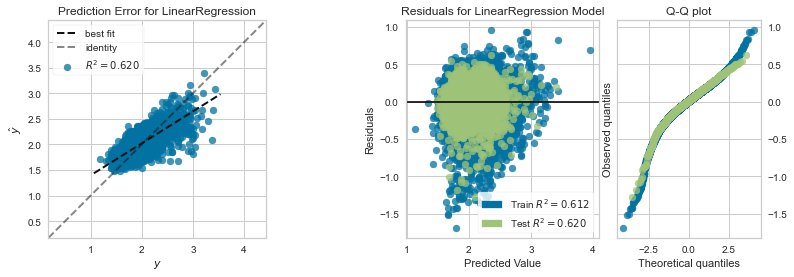

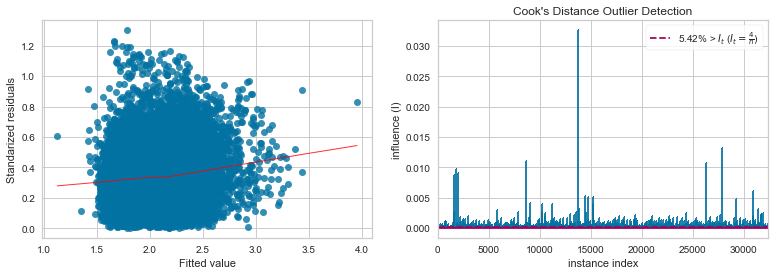

In [92]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
l, linMae = EvaluateRegressionEstimator('Linear Regression', regEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid, cv_price)
regModel_stat = regModel_stat.append(l)

#Plot rediction Error, Residual and Cook's D
residualPlot(regEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid)

**Yellow Brick Plot LR**
<a id="oldYB">

<a id="RidgeRegression"></a>
# **2) Ridge Regression**

Using <a id="ridgeGridSearch"></a> Grid Search to find the best ridge regression model

<a href="#bottom">Back to bottom</a>

In [93]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Ridge

ridgeReg = Ridge(fit_intercept=True, copy_X=True
                ,max_iter=1000, tol=0.0001, random_state=0)

#Test parameters 
ridgeAlpha = [0.001, 0.1, 1, 5, 10, 20]
ridgeSolver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
ridgeParameters = {'alpha': ridgeAlpha, 'solver': ridgeSolver}

#Create a grid search object using the parameters above
ridgeGridSearch = GridSearchCV(estimator=ridgeReg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=ridgeParameters
                   , cv=cv_price # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
ridgeGridSearch.fit(X_price_std, Y_price_log)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Ridge(max_iter=1000, random_state=0, tol=0.0001),
             n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 5, 10, 20],
                         'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg',
                                    'sag', 'saga']},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

### Run tuned model on the train dataset and check performance of the model on validation set

Parameterization of the best estimator: Ridge(alpha=0.001, max_iter=1000, random_state=0, solver='lsqr', tol=0.0001) 

The average MAE for all cv folds is: 			 0.14463
The average MAE percentage (MAPE) for all cv folds is: 	 7.0454
The average RMSE for all cv folds is: 			 0.19537
The average R2 for all cv folds is: 			 0.61083
---------------------------------------------------------------------
Cross Validation Fold Mean Error Scores
        MAE      MAPE      RMSE        R2
0  0.145932  7.114245  0.198870  0.590061
1  0.143147  6.948927  0.194349  0.617332
2  0.144481  7.037424  0.194750  0.616161
3  0.142455  6.910156  0.196719  0.603831
4  0.147837  7.192515  0.204114  0.584086
5  0.143827  7.030372  0.192680  0.622449
6  0.143504  7.049587  0.188859  0.616982
7  0.146716  7.123362  0.195381  0.630229
8  0.143121  6.988456  0.193437  0.619976
9  0.145324  7.058691  0.194535  0.607199

*********************************************
Prediction Error, Residual and Cook's D Plots
*****

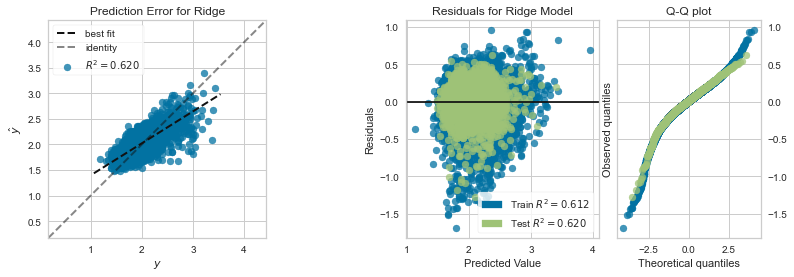

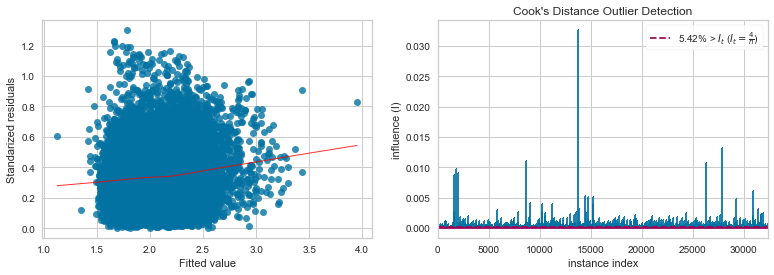

In [94]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
ridgeEstimator = ridgeGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
r, ridgeMae = EvaluateRegressionEstimator('Ridge Regression', ridgeEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid, cv_price)
regModel_stat = regModel_stat.append(r)

#Plot rediction Error, Residual and Cook's D
residualPlot(ridgeEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid)

**Ridge Yellow Brick Plot**
<a id="RidgeYB">

<a id="LASSO"></a>
# **3) Lasso Regression**

Using <a id="lassoGridSearch"></a> Grid Search to find the best least absolute shrinkage and selection operator (LASSO) regression model

<a href="#bottom">Back to bottom</a>

In [95]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Lasso


lassoReg = Lasso(fit_intercept=True, copy_X=True
           , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
lassoAlpha = [0.001, 0.01, 0.1, 1, 10, 20]
lassoSelection = ['cyclic','random']
lassoWarm_start = [True, False]
lassoParameters = {'alpha': lassoAlpha, 'selection': lassoSelection, 'warm_start': lassoWarm_start}

#Create a grid search object using the parameters above
lassoGridSearch = GridSearchCV(estimator=lassoReg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=lassoParameters
                   , cv=cv_price # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
lassoGridSearch.fit(X_price_std, Y_price_log)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Lasso(max_iter=10000, precompute=True, random_state=0),
             n_jobs=8,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 20],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

### Run tuned model on the train dataset and check performance of the model on validation set

Parameterization of the best estimator: Lasso(alpha=0.001, max_iter=10000, precompute=True, random_state=0,
      warm_start=True) 

The average MAE for all cv folds is: 			 0.14469
The average MAE percentage (MAPE) for all cv folds is: 	 7.0484
The average RMSE for all cv folds is: 			 0.19547
The average R2 for all cv folds is: 			 0.61046
---------------------------------------------------------------------
Cross Validation Fold Mean Error Scores
        MAE      MAPE      RMSE        R2
0  0.145693  7.102083  0.198830  0.590225
1  0.143377  6.960192  0.194421  0.617047
2  0.144520  7.040599  0.194797  0.615975
3  0.142308  6.902966  0.196756  0.603682
4  0.147870  7.194502  0.204182  0.583809
5  0.143907  7.032017  0.192946  0.621407
6  0.143645  7.056566  0.188889  0.616861
7  0.147009  7.138139  0.195727  0.628918
8  0.143269  6.996267  0.193596  0.619353
9  0.145328  7.060192  0.194507  0.607308

*********************************************
Prediction Error, Residual and Cook's

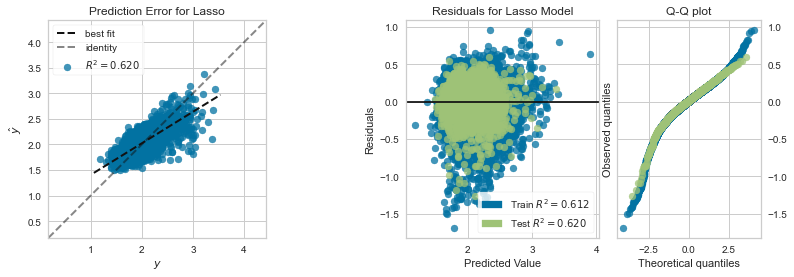

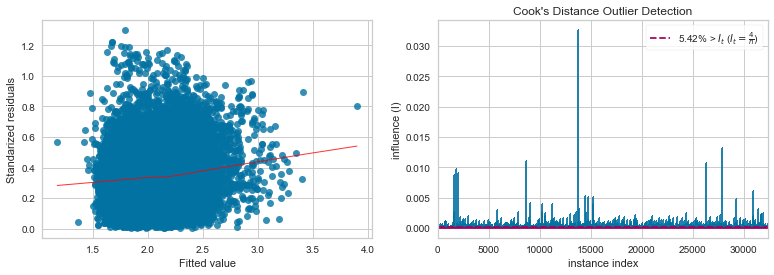

In [96]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
lassoEstimator = lassoGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
ls, lassoMae = EvaluateRegressionEstimator('Lasso Regression', lassoEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid, cv_price)
regModel_stat = regModel_stat.append(ls)

#Plot rediction Error, Residual and Cook's D
residualPlot(lassoEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid)

**LASSO Yellow Brick Plot**
<a id="LASSOYB">

<a id="Enet"></a>
# **4) Elastic Net Regression**

Using <a id="ElasticGridSearch"></a> Grid Search to find the best elastic net regression model.

<a href="#bottom">Back to bottom</a>

In [97]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import ElasticNet

elasticNet = ElasticNet(fit_intercept=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)
 
#Test parameters
elasticNetL1_ratio = [0.001, 0.01, 0.1, 0.5, 0.75, 1]
elasticNetAlpha = [0.001, 0.1, 1, 10]
elasticNetSelection = ['cyclic','random']
elasticNetWarm_start = [True, False]
elasticNetParameters = {'l1_ratio': elasticNetL1_ratio, 'alpha': elasticNetAlpha, 'selection': elasticNetSelection, 'warm_start': elasticNetWarm_start}

#Create a grid search object using the parameters above
elasticNetGridSearch = GridSearchCV(estimator=elasticNet
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=elasticNetParameters
                   , cv=cv_price # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
elasticNetGridSearch.fit(X_price_std, Y_price_log)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=ElasticNet(max_iter=10000, precompute=True,
                                  random_state=0),
             n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 10],
                         'l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.75, 1],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

### Run tuned model on the train dataset and check performance of the model on validation set

Parameterization of the best estimator: ElasticNet(alpha=0.001, l1_ratio=0.001, max_iter=10000, precompute=True,
           random_state=0, warm_start=True) 

The average MAE for all cv folds is: 			 0.14464
The average MAE percentage (MAPE) for all cv folds is: 	 7.0459
The average RMSE for all cv folds is: 			 0.19537
The average R2 for all cv folds is: 			 0.61083
---------------------------------------------------------------------
Cross Validation Fold Mean Error Scores
        MAE      MAPE      RMSE        R2
0  0.145923  7.113754  0.198858  0.590110
1  0.143148  6.948816  0.194341  0.617362
2  0.144492  7.037921  0.194759  0.616126
3  0.142465  6.910714  0.196706  0.603882
4  0.147860  7.193748  0.204133  0.584008
5  0.143825  7.030152  0.192667  0.622501
6  0.143518  7.050296  0.188872  0.616931
7  0.146750  7.125069  0.195407  0.630132
8  0.143133  6.989098  0.193440  0.619963
9  0.145329  7.058943  0.194523  0.607246

*********************************************
Prediction 

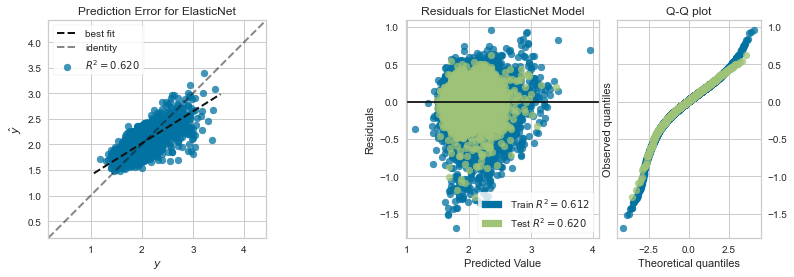

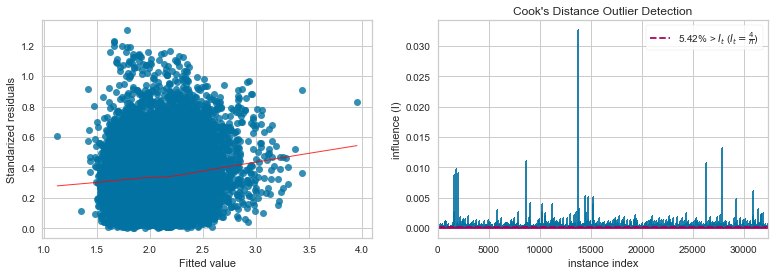

In [98]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
elasticNetEstimator = elasticNetGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
e, elasMae = EvaluateRegressionEstimator('Elastic Net Regression', elasticNetEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid, cv_price)
regModel_stat = regModel_stat.append(e)

#Plot rediction Error, Residual and Cook's D
residualPlot(elasticNetEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid)

**Elastic Net Yellow Brick**
<a id="EnetYB">

<a id="SVR"></a>
# **5) Support Vector Regression**

GridSearchCV was run but the code took longer than 25 minutes to run, so we decided to comment the code for this part out to save time when we run the final notebook.  The best model from GridSearchCV as mentioned below. 

Using <a id="SupportVectorGridSearch"></a> Grid Search to find the best support vector regression model.

<a href="#bottom">Back to bottom</a>

In [99]:
#Create a Linear regression object and perform a grid search to find the best parameters
from sklearn.svm import SVR
svr = SVR()

# Set up SVR parameters to test
svrCosts = [0.001, 0.1]
svrDefGamma = 1 / X_price.shape[1]  #This is the default value for the gamma parameter
svrGammas = [svrDefGamma, 0.1]
svrKernels = ['rbf','linear']
svrParameters = {'C': svrCosts, 'gamma' : svrGammas, 'kernel': svrKernels}

# Create a grid search object using the parameters above
svrGridSearch = GridSearchCV(estimator=svr
                  , n_jobs=4 # jobs to run in parallel
                  , verbose=1 # low verbosity
                  , param_grid=svrParameters
                  , cv=cv_price # KFolds = 10
                  , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
svrGridSearch.fit(X_price_std, Y_price_log)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=SVR(), n_jobs=4,
             param_grid={'C': [0.001, 0.1], 'gamma': [0.025, 0.1],
                         'kernel': ['rbf', 'linear']},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [106]:
svrGridSearch.best_estimator_

SVR(C=0.1, gamma=0.025)

### Run tuned model on the train dataset and check performance of the model on validation set

In [101]:
#Best model is SVR(C=0.1, gamma=0.025)
with warnings.catch_warnings():
   warnings.simplefilter('ignore')

from sklearn.svm import SVR

svrEstimator = SVR(C=0.1, gamma=0.025, verbose=1)
svrEstimator.fit(X_price_std, Y_price_log)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
s, svrMae = EvaluateRegressionEstimator('Support Vector Regression', svrEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid, cv_price)
regModel_stat = regModel_stat.append(s)

[LibSVM]Parameterization of the best estimator: SVR(C=0.1, gamma=0.025, verbose=1) 

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]The average MAE for all cv folds is: 			 0.12806
The average MAE percentage (MAPE) for all cv folds is: 	 6.185
The average RMSE for all cv folds is: 			 0.17946
The average R2 for all cv folds is: 			 0.67165
---------------------------------------------------------------------
Cross Validation Fold Mean Error Scores
        MAE      MAPE      RMSE        R2
0  0.129017  6.227073  0.182687  0.654064
1  0.127803  6.161454  0.178601  0.676834
2  0.127846  6.193546  0.179040  0.675589
3  0.127488  6.135457  0.182167  0.660274
4  0.131534  6.333983  0.189694  0.640776
5  0.127060  6.160199  0.175206  0.687825
6  0.126129  6.145422  0.171665  0.683550
7  0.130207  6.249280  0.181347  0.681443
8  0.126404  6.105530  0.178448  0.676588
9  0.127070  6.138446  0.175700  0.679577


<a id="RFReg"></a>
# **6) Random Forest Regressor**
GridSearchCV was run but the code took longer than 25 minutes to run, so we decided to comment the code for this part out to save time when we run the final notebook.  The best model from GridSearchCV as mentioned below. 

In [102]:
# We use RandomizedSearchCV, which is less expensive than GridSearchCV for our dataset, to help find the best model

from sklearn.ensemble import RandomForestRegressor
rfReg = RandomForestRegressor()
rfParameters = {'min_samples_split':[2,3,4,5]
             ,'n_estimators' : [500]
             ,'min_samples_leaf': [10, 25, 50]
            }

# from sklearn.model_selection import RandomizedSearchCV

rf_random = RandomizedSearchCV(estimator = rfReg, param_distributions = rfParameters, n_iter = 20, cv = cv_price, verbose=1, random_state=0, n_jobs=8, scoring=mae_scorer)

rf_random.fit(X_price_std, Y_price_log)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=RandomForestRegressor(), n_iter=20, n_jobs=8,
                   param_distributions={'min_samples_leaf': [10, 25, 50],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [500]},
                   random_state=0,
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False),
                   verbose=1)

In [103]:
rf_random.best_estimator_

RandomForestRegressor(min_samples_leaf=10, min_samples_split=5,
                      n_estimators=500)

### Run tuned model on the train dataset and check performance of the model on validation set

In [104]:
#Best model is RandomForestRegressor(min_samples_leaf=10, min_samples_split=5, n_estimators=500)

from sklearn.ensemble import RandomForestRegressor

rfRandomEstimator = RandomForestRegressor(min_samples_leaf=10, min_samples_split=5, n_estimators=500, n_jobs=8, random_state=0)
rfRandomEstimator.fit(X_price_std, Y_price_log)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
rf, rfMae = EvaluateRegressionEstimator('Random Forest Regressor', rfRandomEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid, cv_price)
regModel_stat = regModel_stat.append(rf)

Parameterization of the best estimator: RandomForestRegressor(min_samples_leaf=10, min_samples_split=5,
                      n_estimators=500, n_jobs=8, random_state=0) 

The average MAE for all cv folds is: 			 0.12194
The average MAE percentage (MAPE) for all cv folds is: 	 5.9124
The average RMSE for all cv folds is: 			 0.17196
The average R2 for all cv folds is: 			 0.69841
---------------------------------------------------------------------
Cross Validation Fold Mean Error Scores
        MAE      MAPE      RMSE        R2
0  0.123755  5.998334  0.175306  0.681451
1  0.122941  5.955879  0.172894  0.697157
2  0.120380  5.843160  0.171075  0.703813
3  0.122311  5.905173  0.175866  0.683371
4  0.125766  6.071355  0.183005  0.665663
5  0.120534  5.874666  0.166173  0.719185
6  0.119280  5.807917  0.165892  0.704475
7  0.123367  5.964931  0.171200  0.716094
8  0.122037  5.926973  0.172915  0.696332
9  0.119030  5.775662  0.165248  0.716567


<a id="ETrees"></a>
# **7) Extra Trees Regressor**
GridSearchCV was run but the code took longer than 25 minutes to run, so we decided to comment the code for this part out to save time when we run the final notebook.  The best model from GridSearchCV as mentioned below. 

Using <a id="ExtraTreesGridSearch"></a> Grid Search to find the best extra trees regressor model.

<a href="#bottom">Back to bottom</a>

In [107]:
from sklearn.ensemble import ExtraTreesRegressor

etReg = ExtraTreesRegressor()
etParameters = { 'min_samples_split':[2,3,4,5]
             ,'n_estimators' : [500]
             ,'min_samples_leaf': [10, 25, 50]
            }

from sklearn.model_selection import RandomizedSearchCV
extraTrees = RandomizedSearchCV(estimator = etReg, param_distributions = etParameters, n_iter = 20, cv = cv_price, verbose=1, random_state=0, n_jobs=8, scoring=mae_scorer)

extraTrees.fit(X_price_std, Y_price_log)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=ExtraTreesRegressor(), n_iter=20, n_jobs=8,
                   param_distributions={'min_samples_leaf': [10, 25, 50],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [500]},
                   random_state=0,
                   scoring=make_scorer(mean_absolute_error, greater_is_better=False),
                   verbose=1)

In [108]:
extraTrees.best_estimator_

ExtraTreesRegressor(min_samples_leaf=10, n_estimators=500)

### Run tuned model on the train dataset and check performance of the model on validation set

In [109]:
#Best model is ExtraTreesRegressor(min_samples_leaf=10, min_samples_split=3, n_estimators=500)
import warnings
with warnings.catch_warnings():
   warnings.simplefilter('ignore')

from sklearn.ensemble import ExtraTreesRegressor

etEstimator = ExtraTreesRegressor(min_samples_leaf=10, min_samples_split=3, n_estimators=500, verbose=1, n_jobs=8, random_state=0)
etEstimator.fit(X_price_std, Y_price_log)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
et, etMae = EvaluateRegressionEstimator('Extra Trees Regressor', etEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid, cv_price)
regModel_stat = regModel_stat.append(et)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    4.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Parameterization of the best estimator: ExtraTreesRegressor(min_samples_leaf=10, min_samples_split=3, n_estimators=500,
                    n_jobs=8, random_state=0, verbose=1) 



[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    4.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.5s
[Paral

The average MAE for all cv folds is: 			 0.12342
The average MAE percentage (MAPE) for all cv folds is: 	 5.9858
The average RMSE for all cv folds is: 			 0.1733
The average R2 for all cv folds is: 			 0.69375
---------------------------------------------------------------------
Cross Validation Fold Mean Error Scores
        MAE      MAPE      RMSE        R2
0  0.124446  6.022400  0.176864  0.675766
1  0.124010  6.001657  0.173748  0.694159
2  0.122028  5.916751  0.171794  0.701317
3  0.122887  5.935908  0.176678  0.680440
4  0.126031  6.091503  0.182821  0.666336
5  0.122331  5.959991  0.169335  0.708394
6  0.121743  5.952144  0.166616  0.701890
7  0.125359  6.057085  0.173417  0.708693
8  0.123061  5.985221  0.172591  0.697471
9  0.122352  5.935829  0.169157  0.702998


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


<a id="KNNReg"></a>
# **8) K Neighbors Regressor**
GridSearchCV was run but the code took longer than 25 minutes to run, so we decided to comment the code for this part out to save time when we run the final notebook.  The best model from GridSearchCV as mentioned below. 


Using <a id="KnnGridSearch"></a> Grid Search to find the best KNN regressor model.

<a href="#bottom">Back to bottom</a>

In [110]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor()

k_range = list(range(15))[1::2]

neighParameters = { 'n_neighbors' : k_range
                   , 'weights' : ['uniform', 'distance']
                   , 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
               }

neighGridSearch = GridSearchCV(estimator=neigh
                  , n_jobs=8 # jobs to run in parallel
                  , verbose=1 # low verbosity
                  , param_grid=neighParameters
                  , cv=cv_price # KFolds = 10
                  , scoring=mae_scorer)
neighGridSearch.fit(X_price_std, Y_price_log)

Fitting 10 folds for each of 56 candidates, totalling 560 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=KNeighborsRegressor(), n_jobs=8,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [111]:
neighGridSearch.best_estimator_

KNeighborsRegressor(n_neighbors=11, weights='distance')

### Run tuned model on the train dataset and check performance of the model on validation set

In [112]:
#Best model is KNeighborsRegressor(algorithm='ball_tree', n_neighbors=11, weights='distance')

from sklearn.neighbors import KNeighborsRegressor

knnEstimator = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=11, weights='distance', n_jobs=8)
knnEstimator.fit(X_price_std, Y_price_log)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
knnReg, knnMae = EvaluateRegressionEstimator('K Neighbors Regressor', knnEstimator, X_price_std, Y_price_log, X_price_valid_std, Y_price_log_valid, cv_price)
regModel_stat = regModel_stat.append(knnReg)

Parameterization of the best estimator: KNeighborsRegressor(algorithm='ball_tree', n_jobs=8, n_neighbors=11,
                    weights='distance') 

The average MAE for all cv folds is: 			 0.13418
The average MAE percentage (MAPE) for all cv folds is: 	 6.5099
The average RMSE for all cv folds is: 			 0.18794
The average R2 for all cv folds is: 			 0.63988
---------------------------------------------------------------------
Cross Validation Fold Mean Error Scores
        MAE      MAPE      RMSE        R2
0  0.133791  6.466198  0.191279  0.620757
1  0.135087  6.532928  0.187000  0.645723
2  0.134799  6.549459  0.190180  0.633964
3  0.133782  6.473030  0.189040  0.634157
4  0.137593  6.653926  0.196369  0.615052
5  0.133315  6.476732  0.185645  0.649516
6  0.131810  6.441696  0.181649  0.645669
7  0.136085  6.593899  0.188022  0.657561
8  0.132567  6.446857  0.185948  0.648834
9  0.132936  6.464145  0.184260  0.647595


<a id="AnalReg"></a>
> ## Modeling and Evaluation 4:
> Analyze the results using your chosen method of evaluation: *Regression*
> 

Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

#### [10 points
<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

The table below shows mean scores for MAE, MAPE, RMSE, and R-squared for all 8 regression models.

In [113]:
regModel_stat

Model_name  MAE_model  MAPE_model  RMSE_model  R2_model  \
0          Linear Regression   0.144638    7.045547    0.195372  0.610819   
0           Ridge Regression   0.144635    7.045374    0.195369  0.610831   
0           Lasso Regression   0.144693    7.048352    0.195465  0.610458   
0     Elastic Net Regression   0.144644    7.045851    0.195371  0.610826   
0  Support Vector Regression   0.128056    6.185039    0.179456  0.671652   
0    Random Forest Regressor   0.121940    5.912405    0.171957  0.698411   
0      Extra Trees Regressor   0.123425    5.985849    0.173302  0.693746   
0      K Neighbors Regressor   0.134177    6.509887    0.187939  0.639883   

   MAE_validation  MAPE_validation  RMSE_validation  R2_validation  
0        0.143146         7.041441         0.191249       0.619693  
0        0.143153         7.041650         0.191264       0.619632  
0        0.143128         7.040706         0.191289       0.619534  
0        0.143156         7.041951         0.191254       0.619675  
0        0.126520         6.182083         0.173768       0.686039  
0        0.118989         5.828576         0.164599       0.718299  
0        0.121496         5.962266         0.167537       0.708152  
0        0.132586         6.517428         0.181525       0.657384

Bar charts below display mean scores for MAE, MAPE, RMSE, and R-squared for all 8 regression models.  The scores are from when we fitted the best regression models from gride search to the validation dataset.

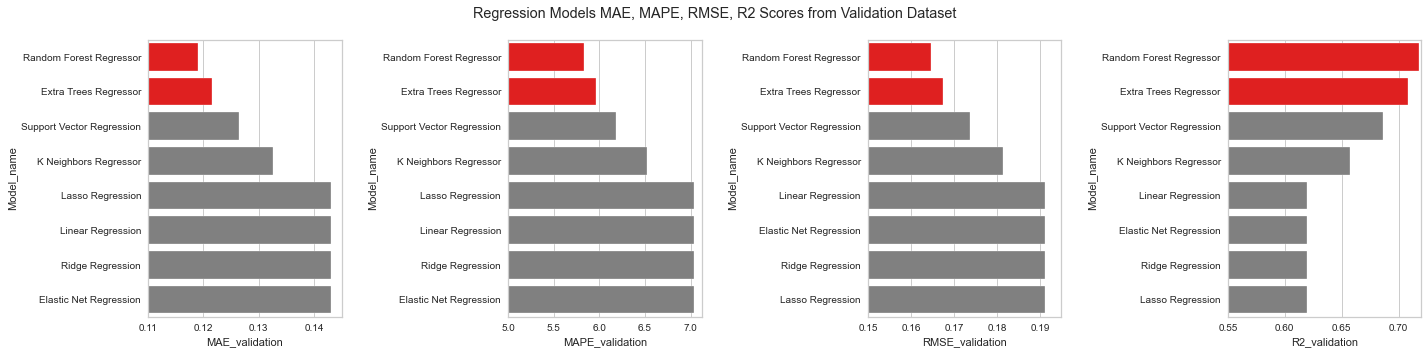

In [114]:
from heapq import nsmallest
from heapq import nlargest

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Regression Models MAE, MAPE, RMSE, R2 Scores from Validation Dataset')

mae_valid = np.array(regModel_stat.sort_values('MAE_validation').MAE_validation)
top2_maevalid = max(nsmallest(2, mae_valid))
clrs1 = ['grey' if (x > top2_maevalid) else 'red' for x in mae_valid]
sns.barplot(ax=axes[0], x="MAE_validation", y="Model_name", data=regModel_stat.sort_values('MAE_validation'), palette=clrs1)
axes[0].set_xlim(.11,.145)

mape_valid = np.array(regModel_stat.sort_values('MAPE_validation').MAPE_validation)
top2_mapevalid = max(nsmallest(2, mape_valid))
clrs2 = ['grey' if (x > top2_mapevalid) else 'red' for x in mape_valid]
sns.barplot(ax=axes[1], x="MAPE_validation", y="Model_name", data=regModel_stat.sort_values('MAPE_validation'), palette=clrs2)
axes[1].set_xlim(5,7.12)

rmse_valid = np.array(regModel_stat.sort_values('RMSE_validation').RMSE_validation)
top2_rmsevalid = max(nsmallest(2, rmse_valid))
clrs3 = ['grey' if (x > top2_rmsevalid) else 'red' for x in rmse_valid]
sns.barplot(ax=axes[2], x="RMSE_validation", y="Model_name", data=regModel_stat.sort_values('RMSE_validation'), palette=clrs3)
axes[2].set_xlim(.15,.195)

r2_valid = np.array(regModel_stat.sort_values('R2_validation', ascending=False).R2_validation)
top2_r2valid = min(nlargest(2, r2_valid))
clrs4 = ['grey' if (x < top2_r2valid) else 'red' for x in r2_valid]
sns.barplot(ax=axes[3], x="R2_validation", y="Model_name", data=regModel_stat.sort_values('R2_validation', ascending=False), palette=clrs4)
axes[3].set_xlim(.55,.72)

plt.tight_layout()

   **Best 2 models are Random Forrest Regressor and Extra Trees Regressor**

The bar charts above give a visual representation of our (8) regression models. MAE, MAPE, and RMSE a lower score means a better result, R^2 a higher score is better. Across all metrics the non parametric models out performed the parametric models. Interesting to note that Random Forest and Extra Trees are both unsupervised models. The variation in the dataset seems to be explained better by these non parametric models. This gives us some indication that price is non-linearly related to the independent variables. In the bias/variation trade off that exists within all models these non parametic tools are able to capture this variation present in our dataset. 

According to our preffered metric, MAE, the top two best models are Random Forest and Extra Trees Regressors.  While the best supervised model is Support Vector Regression (SVR). 

<a id="DissReg"></a>
> ## Modeling and Evaluation 5:
> Discuss the advantages of each model: *Regression*
> 

(if any) If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods.

> #### [10 points]

1) **Linear Regression**: This is an easy model to understand. As well as provides us with easy to interpret result. It is also a computationally inexpensive model to run. But this model suffers from high bias. Another advantage of Linear Regression is that since many people are familiar with the concept it is approachable to those without statitical backgrounds.  Linear regression while a proven model and has many uses it struggles with our dataset. The correlation plot shows that almost all variables have a pretty low correlation to price. Which supports the lackluster result we got with linear regression. 

2) **Ridge, LASSO and Elastic Net**: The main difference between Lasso and Ridge is the penalty term they use. Ridge uses 𝐿2 penalty term which limits the size of the coefficient vector. Lasso uses 𝐿1 penalty which imposes sparsity among the coefficients and thus, makes the fitted model more interpretable. Elasticnet is introduced as a compromise between these two techniques, and has a penalty which is a mix of 𝐿1 and 𝐿2 norms. The advantage of using these three modeling techniques is that it helps reduce the number of variables with the methods described above. Each model using a slightly different penalty term to eliminate low impactful variables. Another advantage of these models is that they can be used in tandem with other models such as KNN. When using these penalized regression models with KNN it help reduce the numbers of variables and decrease the affect of the curse of demontionality in KNN. 

3) **SVR:** is a great algrothim in many respects. Support Vector Regression is a supervised learning algorithm that is used to predict discrete values. The basic idea behind SVR is to find the best fit line. In SVR, the best fit line is the hyperplane that has the maximum number of points. Unlike other Regression models that try to minimize the error between the real and predicted value, the SVR tries to fit the best line within a threshold value. This feature makes it robust against outliers, decisions can be easily updated, and hyperlane feature helps the model generalize with high accuracy. One distinct disadvantage is that it is computationally expensive. The run time of the model exceeds the patience of our team members to sit and wait for the results. Our dataset has a lot of noise. SVR suffers when in the presence of noise. Despite this latent noise in our data SVR is our best supervised model. Since our dataset has outliers the advantagae of SVR to outliers is seen as our best performing supervised model. 

4) **Radom Forest & Extra Trees**: Unlike SVR,  Random Forest and Extra Trees can handle the noise in our dataset well. These non-parametric models capture the varaition and non linear relationships to price in the dataset efficiently. Random Forest algorithm is very stable. Even if a new data point is introduced in the dataset, the overall algorithm is not affected much since the new data may impact one tree, but it is very hard for it to impact all the trees. Another advantage is that results of Random Forest and Extra Trees provide results that are interpretable. Even if someone does not have a statistical background the output of the clustering algorithms provides an easy to follow results.  The Random Forest, a clustering algorithm, picked up on geo spacial importance without optimizing for location data. We would have expected neighborhood group (NYC boroughs) to be important. But Random Forest found clusters of high valued real estate efficiently.

5) **KNN**: is an easy to implement algorithm. Fundamentally, it is an easy to understand model, "birds of a feather flock together." One disadvantage of KNN is that is suffers from the curse of curse of dimensionality. In our modeling we gave KNN all independent variables and probably suffered from this approach. If given more time one approach to try and improve our KNN results would be to reduce the number of predictors in the model. This might improve the we got from KNN. 

From regression model matrics statistic summary table above, we can see the best MAE value for validation dataset are from Random Forrest Regression and Extra Trees Regression.  We then compare these two model MAE using hypothesis testing (t-test).

**Hypothesis Testing**
- H0: Both models have the same performance on the dataset.
- H1: Both models doesn’t have the same performance on the dataset.
- *Assume significance level at 0.05*
<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

In [115]:
from mlxtend.evaluate import paired_ttest_5x2cv

t, p = paired_ttest_5x2cv(estimator1=rfRandomEstimator,
                          estimator2=etEstimator,
                          X=X_price_valid_std, y=Y_price_log_valid,
                          random_seed=27, scoring=mae_scorer)

print('Random Forrest Regressor vs Extra Trees Regressor')
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[

Random Forrest Regressor vs Extra Trees Regressor
t statistic: 2.234
p value: 0.076


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


**Random Forest Regressor vs Extra Tree Regressor**: With a p-value of 0.076 (more than alpha=0.05), we cannot reject the null hypothesis and conclude with 95% confidence there is not enough evidence to suggest that there is a difference in the MAE score of these models.

### **Now let's compare the best unsupervised model, Random Forest Regressor, with the best supervised model, SVR**
We compare these two model MAE using hypothesis testing (t-test) with the same hypothesis as mentioned above.

In [116]:
from mlxtend.evaluate import paired_ttest_5x2cv

t, p = paired_ttest_5x2cv(estimator1=rfRandomEstimator,
                          estimator2=svrEstimator,
                          X=X_price_valid_std, y=Y_price_log_valid,
                          random_seed=27, scoring=mae_scorer)

print('Random Forrest Regressor vs Support Vector Regression')
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Random Forrest Regressor vs Support Vector Regression
t statistic: 6.228
p value: 0.002


**Random Forest Regressor vs Support Vector Regression**: With a p-value of 0.002 (less than alpha=0.05), we  reject the null hypothesis and conclude with 95% confidence there is a statistically significant difference in the MAE score of these models.

<a id="ImpReg"></a>
> ## Modeling and Evaluation 6
> Which attributes from your analysis are most important?: *Regression*
> 

Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

> #### [10 points]
<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

Our best regression model using MAE score is Random Forest.  The bar chart below displays top features importances for the model.

In [117]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
randomForrestReg_weights = rfRandomEstimator.feature_importances_.ravel()
randomForrestReg_feature_names = X_price_valid.columns.values
randomForrestReg_ft_imp_df = pd.DataFrame({'feature_names':randomForrestReg_feature_names, 'weights':randomForrestReg_weights, 'absolute_weights': np.abs(randomForrestReg_weights)})
randomForrestReg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False)

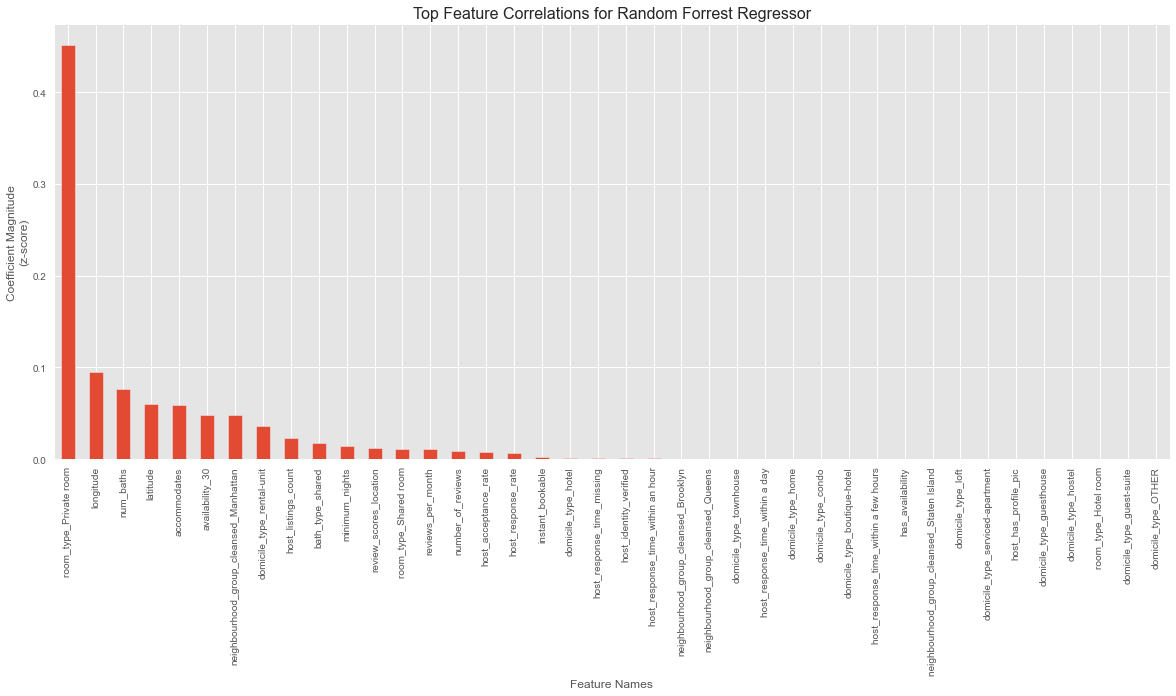

In [118]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

randomForrestReg_wt_plt_df = randomForrestReg_ft_imp_df.head(75)

randomForrestReg_weights = pd.Series(randomForrestReg_wt_plt_df['weights'].values,index=randomForrestReg_wt_plt_df['feature_names'])
ax = randomForrestReg_weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations for Random Forrest Regressor", fontsize=16)
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

Our best regression model using MAE as our preferred metric is **Random Forest**.  The bar chart below displays top features importances for the model.

1) **Room Privacy**: According to our Random Forest Model the most important feature when considering price is the privacy of the listing. Users put a premium on having accomdations that they do not have to share with hosts or other guests. This makes intuitive sense as well. If a room is shared than the guests would expect to pay less for such an accomoation. This is backed by shared room's rank on feature importance as number (13).

2) & 4) **Lat/Long**: Something that we didn't expect is latitude and longitude to be ranked so high. The Random Forest, a clustering algorithm, picked up on geo spacial importance without optimizing for location data. We would have expected neighborhood group (NYC boroughs) to be important. But Random Forest found clusters of high valued real estate efficiently. This makes sense, a common aphorism in real estate is location, location, location. Guests looking for a place to rent would pay a premium for prime listings that are centerally located, with access to public transportation, near night life and attractions. This results indicates that we might improve of price analysis by optimizing geospacial data for regression. 

3) & 5) **num_baths** and **accommodates**: These two variables while distinct both give an indication of size/square footage. The larger the listing the more bathrooms one might expect. The same is true for accommodates. 

6) **Availability_30**: As a refresher this variable describes the number of days a listing is available in a (30) day window. There is some noise in this variable. For instance, a highly desireable location may be booked and not have availability. Likewise, a un-desireable place could have lots of availability. However, a counter agruements exists. People's time preference is that dichotomy. The closer one books to their stay the more one might expect to pay. Where as booking farther in advance might give somebody a lower price. 

7) **neighborhood_group_cleaned_manhattan**: This variables indicates whether a listing is on Manhattan island. As discussed in lat/long location is important in the real estate game. Manhattan has some of the highest real estate in the country. It is centerally located, in most cases will be near subway stations, restaurants, with night life and attractions near by. 

<a id="Deploy"></a>
___
# Deployment: *Combined*

How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?
___
#### [5 points total]

Airbnb is platform that connects people who want to rent out their property to people who are looking for accomodations in that area. For guests the advantage can be relatively inexpensive accommodations. This is particuarly true for large groups who wish to stay together. Renting a house on Airbnb is often less expensive than a hotel.

The data set comes from Inside Airbnb. They offer the data set as a way for people to analyze how Airbnb is being used in their city. The dataset is collected from pubically available information on the Airbnb website. Inside Aribnb makes this dataset available on their website. Each webscrapte represents a snapshot of listings at a particular time. 

*Classification: SuperHost, interested parties* 

For people who are considering listing their own property(ies) on Airbnb classifying superhosts status based on host attributes provides valuable insights on characteristics of those hosts with the "Superhost" badge. Earning the status of Superhost means greater visibilty and increase in trust with prospective guests. Which contributes to a hosts potential earnings. Prediction of the of ones superhost status is not the ultimate goal. What our model does is bring to light which host attributes someone might want to focus on in order to achieve Superhost status. 

*Classification: SuperHost, use case for deployment* 

A potential use case for this type of superhost classification is an app. Airbnb hosts could enter their host metrics. The app could then reveal a path forward to achieve the coveted Superhost badge. For instance, how many more 5 star ratings they would need bring their rating above 4.8. Or for a new host specific recommendations on what to focus on for their first guests. 

*Classification: SuperHost, How would its effectiveness be measured*

Most apps effectiveness is measured in number of users. The rating of the app is another important metric. Surveys and sentiment of user review comments is tied into the feedback loop. Ultimately, this modeling would be effective if users found this data helpful in navigating the path to becoming a superhost or maintaining superhost status. App usage and ratings would reveal if users found this modeling useful in their quest to be superhosts.

*Classification: SuperHost, additional data to be collected and model updates*

Historical booking data is a prime source to help train our models. The model needs to be updated (4) times a year in synch with the quarterly superhost assessments done by Airbnb. Webscraping data at the time airbnb superhost grades are first released is important. It would allow us to have feature data representative of the same data airbnb fed into it's grading system. Time matched data for features and target would give us better predictive performance.


*Regression: Price, interested parties*

Hosts set their own price on Airbnb. Whether there a Real estate investors and ma & pa hosts on Airbnb everyone is interested in maximizing their potential earnings. Understanding which features drive price can help hosts make more informed decesions on how to set their price. It can also help those who are looking to purchase property with the intention of listing it airbnb for profit select listings that have the highest return on investment (ROI). 

*Regression: Price,  use case for deployment* 

All this analysis is relevant to investors. When making large purchases people tend to put a premium on information that helps them understand their investment. Our price regression is relevant in this space. Refining our results we might be able to offer a valuable service in that market. This model could be deployed as part of a consulting service. Finding a niche amongst investors who are looking to invest in real estate with the intent on listing on Airbnb might look to a consultant service to help evaluate risk and ROI.

*Regression: Price, How would its effectiveness be measured*

Utlimately the value would be derivied from the ability to market a consultant type service. If investors ROI meet their expectation we would expect repeat business. Customers using our service repeadetly indicated that our model is effective and useful. The same valuation is true of home owners used this service as well to maximize revenue.  

*Regression: Price, additional data to be collected and model updates*

Our analysis found that guests pay a premium for increased privacy. Latitude and longitude are included in our analysis as well. Our non parametric models picked up on this location data. It found clusters of high valued real estate. This is an indication that further optimizing geospacial data could further improve our results. We hope that we could model expected price of proximity to a subway station, stadium, nightlife etc, with further refinements and importing exogenous data sources.

Another type of data that would help with price predictions is events taking place in that locale. For instance, holidays, sporting events, music concerts, have potential to effect price. Includling this into the model would increase our price predicition to actual market conditions. 

With this in mind our model would need to be updated frequently to adjust for changing conditions. Currently we are using just a moment in time. The more frequently we sampled our data the better, but at what rate is too much we don't know. This is another problem we'd to solve before we go into the Airbnb consultanting business.   

<div style="text-align: right"> <a href="#main">Back to Table of Content</a> </div>

<a id="Ework"></a>
___
<a id="bottom"></a>
# Exceptional Work:  

You have free reign to provide additional modeling. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?
___
#### [10 points total]

The Following are hypelinks reference the Grid Searches. This technique is used on each model we ran to tune the hyperparameters. We submit this as our exceptional work. There is also a hyperlink at each location to take you back to here once you reviewed the work. 

**Classification Grid Searches:** <br />
Using <a href="#LegRegGridSearch">Grid Search</a> to find the best logistic regression classification model. <br />
Using <a href="#RandForestGridSearch">Grid Search</a> to find the best random forest classification model. <br />
Using <a href="#KnnGridSearch">Grid Search</a> to find the best KNN classification model.

**Regression Grid Searches:** <br />
Using <a href="#regGridSearch">Grid Search</a> to find the best regression models. <br />
Using <a href="#ridgeGridSearch">Grid Search</a> to find the best ridge regression model. <br />
Using <a href="#lassoGridSearch">Grid Search</a> to find the best (LASSO) regression model. <br />
Using <a href="#ElasticGridSearch">Grid Search</a> to find the best elastic net regression model. <br />
Using <a href="#SupportVectorGridSearch">Grid Search</a> to find the best support vector regression model. <br />
Using <a href="#ExtraTreesGridSearch">Grid Search</a> to find the best extra trees regressor model. <br />
Using <a href="#KnnGridSearch">Grid Search</a> to find the best KNN regressor model.

Also, notice how many models we did.. 

**Yellow Brick Plot** <br />
<a href="#oldYB">Linear</a> regression residual cook D, Prediction Error plots. <br />
<a href="#RidgeYB">Ridge</a> regression residual, cook D, Prediction Error plots. <br />
<a href="#LASSOYB">LASSO</a> reggression residual plot.residual, cook D, Prediction Error plots. <br />
<a href="#EnetYB">Elastic Net</a> reggression residual plot.residual, cook D, Prediction Error plots. <br />


**Optimal k Plot** <br />
<a href="#optimalK">Optimal</a> K plot.

**Creation of Host Level Data from listings** <br />
<a href="#hostdata">Creation</a> of host level data by aggregating host metrics from listings.csv. This created two distinct data sets from one intial web-scrape. Realizing we could aggregate host metrics based on ID was a clever change of perspective that improved our ability to classify superhost status.